In [795]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from scipy.fft import fft 
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import numpy.ma as ma
import numpy.linalg as linalg
import time
import math as m
import pandas as pd
from pandas import DataFrame
import statsmodels as stats
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.stattools import ccf
from seasonal import fit_seasons, adjust_seasons, periodogram


In [796]:
#FUNCIÓN PARA HACER LA CORRELACIÓN ESPACIAL, ES DECIR UN ÍNDICE CON UN MAPA,
#AUNQUE PODRÍA SER TAMBIÉN ENTRE DOS INDICES PARA n1=1
def IndexRegression(Data,Index,alfa):
    [n1,n2]=Data.shape #los datos introducidos en Data tienen que tener dimesión n1=espacio, n2=tiempo 
    #inicializamos las matrices
    Cor=ma.empty([n1,])
    Pvalue=ma.empty([n1,])
    reg=ma.empty([n1,])
    reg_sig=ma.empty([n1,])
    for nn in range(n1): #para cada punto del espacio hacemos la correlación de Pearson
        bb=pearsonr(Data[nn,:],Index) #bb tiene dos salidas: la primera es corre y la segunda es p-value 
        Cor[nn]=bb[0]
        Pvalue[nn]=bb[1]
    #generamos una variable que es para que no se muestren mas que los valores de Cor cuando la correlacion
    #es significativa
    Cor_sig=ma.masked_where(Pvalue>alfa,Cor)
    #generamos el mapa de regresión mediante multiplicación matricial. Ojo con las dimensiones!!
    reg=Data.dot(Index)/ (n2-1)
    #igualmente, hacemos una máscara para que sólo se muestre el mapa de regresión cuando es significativo
    reg_sig=ma.masked_where(Pvalue>alfa,reg)
    return Cor,Pvalue,Cor_sig,reg,reg_sig

In [797]:
fil=nc.Dataset('SST_era5_1979_2020_remallado.nc')
#fil.variables

fil.variables

{'time': <class 'netCDF4._netCDF4.Variable'>
 int32 time(time)
     standard_name: time
     long_name: time
     units: hours since 1900-01-01 00:00:00.0
     calendar: gregorian
     axis: T
 unlimited dimensions: time
 current shape = (500,)
 filling on, default _FillValue of -2147483647 used,
 'lon': <class 'netCDF4._netCDF4.Variable'>
 float64 lon(lon)
     standard_name: longitude
     long_name: longitude
     units: degrees_east
     axis: X
 unlimited dimensions: 
 current shape = (181,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'lat': <class 'netCDF4._netCDF4.Variable'>
 float64 lat(lat)
     standard_name: latitude
     long_name: latitude
     units: degrees_north
     axis: Y
 unlimited dimensions: 
 current shape = (91,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'expver': <class 'netCDF4._netCDF4.Variable'>
 float64 expver(expver)
     long_name: expver
     axis: Z
 unlimited dimensions: 
 current shape = (2,)
 filling on, defa

In [798]:
lat=fil.variables['lat'][:]
lon=fil.variables['lon'][:]
SST = fil.variables['sst'][:]
SST.shape

(500, 2, 91, 181)

In [799]:
nt, nexpver, nlat, nlon = SST.shape
SST=SST[:-8,0,:,:]
SST=SST[228:,:,:]
SST=np.squeeze(SST)
SST.shape

(264, 91, 181)

In [800]:
nm = 12
nyears = 22

In [801]:
SST=SST.reshape(nyears,nm,nlat*nlon)
SST1=SST.mean(2)
SST1.shape


(22, 12)

<ipython-input-802-83e3c7d7834d>:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(SST1[:,4],color='Blue',Marker='o',label='Evolucion de autovalores')


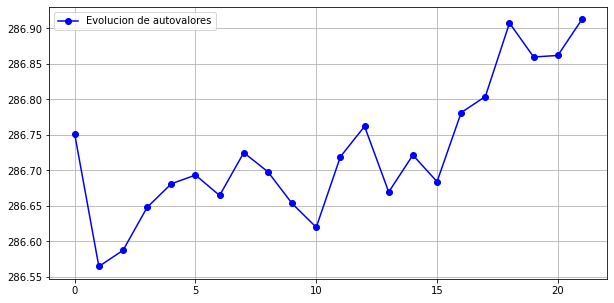

In [802]:
fig,ax = plt.subplots(figsize = (10,5))
plt.plot(SST1[:,4],color='Blue',Marker='o',label='Evolucion de autovalores')
plt.legend()
plt.grid()

<ipython-input-803-d1c5732e4060>:3: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(SST1d[:,4],color='Blue',Marker='o',label='Evolucion de autovalores')


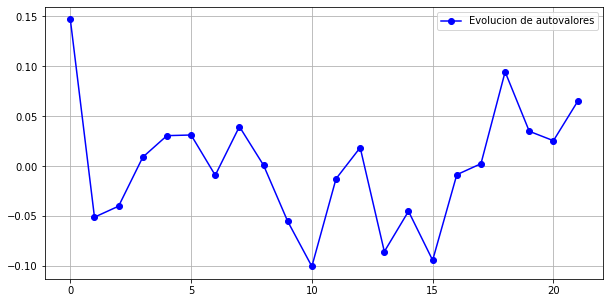

In [803]:
SST1d=signal.detrend(SST1,axis=0)
fig,ax = plt.subplots(figsize = (10,5))
plt.plot(SST1d[:,4],color='Blue',Marker='o',label='Evolucion de autovalores')
plt.legend()
plt.grid()

<ipython-input-804-3d1c84fcc11a>:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(SST1d[:,4]-SST1[:,4],color='Blue',Marker='o')


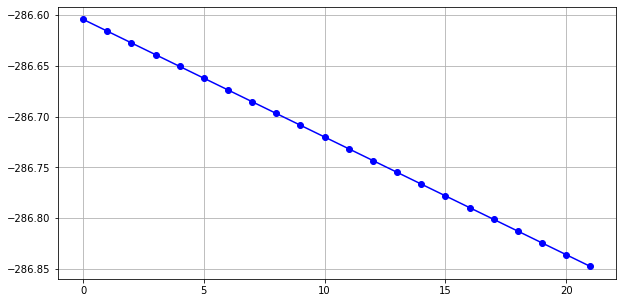

In [804]:
fig,ax = plt.subplots(figsize = (10,5))
plt.plot(SST1d[:,4]-SST1[:,4],color='Blue',Marker='o')
plt.grid()

In [805]:
SST=SST.reshape(nyears,nm,nlat*nlon)
SST=signal.detrend(SST,axis=0)

In [806]:
SST=SST.reshape(nyears*nm,nlat,nlon)
SST.shape

(264, 91, 181)

In [807]:
lonmin,lonmax,latmin,latmax = -40,10,0,20
AT = SST[:,:,(lon>lonmin)&(lon<lonmax)][:,(lat>latmin)&(lat<latmax),:]
yrs = np.arange(1999,2020)
lon_AT= lon[(lon>lonmin)&(lon<lonmax)]
lat_AT=lat[(lat>latmin)&(lat<latmax)]

In [808]:

nt,nlat2,nlon2=AT.shape

In [809]:
AT=AT.reshape(nyears, nm, nlat2,nlon2)



In [810]:

AT_e=AT.reshape(nyears,nm,nlat2*nlon2)[:,[0],:].mean(1) #ponemos los datos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
AT_e=(AT_e-AT_e.mean(0))
AT_e.shape
AT_f=AT.reshape(nyears,nm,nlat2*nlon2)[:,[1],:].mean(1) #ponemos los datos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
AT_f=(AT_f-AT_f.mean(0))
AT_f.shape

AT_m=AT.reshape(nyears,nm,nlat2*nlon2)[:,[2],:].mean(1) #ponemos los datos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
AT_m=(AT_m-AT_m.mean(0))
AT_m.shape

AT_a=AT.reshape(nyears,nm,nlat2*nlon2)[:,[3],:].mean(1) #ponemos los datos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
AT_a=(AT_a-AT_a.mean(0))
AT_a.shape

AT_y=AT.reshape(nyears,nm,nlat2*nlon2)[:,[4],:].mean(1) #ponemos los datos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
AT_y=(AT_y-AT_y.mean(0))
AT_y.shape

AT_j=AT.reshape(nyears,nm,nlat2*nlon2)[:,[5],:].mean(1) #ponemos los datos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
AT_j=(AT_j-AT_j.mean(0))
AT_j.shape

AT_l=AT.reshape(nyears,nm,nlat2*nlon2)[:,[6],:].mean(1) #ponemos los datos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
AT_l=(AT_l-AT_l.mean(0))
AT_l.shape

AT_u=AT.reshape(nyears,nm,nlat2*nlon2)[:,[7],:].mean(1) #ponemos los datos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
AT_u=(AT_u-AT_u.mean(0))
AT_u.shape

AT_s=AT.reshape(nyears,nm,nlat2*nlon2)[:,[8],:].mean(1) #ponemos los datos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
AT_s=(AT_s-AT_s.mean(0))
AT_s.shape

AT_o=AT.reshape(nyears,nm,nlat2*nlon2)[:,[9],:].mean(1) #ponemos los datos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
AT_o=(AT_o-AT_o.mean(0))
AT_o.shape

AT_n=AT.reshape(nyears,nm,nlat2*nlon2)[:,[10],:].mean(1) #ponemos los datos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
AT_n=(AT_n-AT_n.mean(0))
AT_n.shape

AT_d=AT.reshape(nyears,nm,nlat2*nlon2)[:,[11],:].mean(1) #ponemos los datos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
AT_d=(AT_d-AT_d.mean(0))
AT_d.shape
AT_inv=[]
AT_pri=[]
AT_ver=[]
AT_oto=[]
for i in range (nyears-1):
    AT_inv=np.concatenate([AT_inv,AT_d[i,],AT_e[i+1,],AT_f[i+1,]])                     
    AT_pri=np.concatenate([AT_pri,AT_m[i+1,],AT_a[i+1,],AT_y[i+1,]])
    AT_ver=np.concatenate([AT_ver,AT_j[i+1,],AT_l[i+1,],AT_u[i+1,]])
    AT_oto=np.concatenate([AT_oto,AT_s[i+1,],AT_o[i+1,],AT_n[i+1,]])



In [811]:
AT=AT.reshape(nyears*nm,nlat2*nlon2)
AT_ver=AT_ver.reshape(21*3,nlat2*nlon2)
AT_pri=AT_pri.reshape(21*3,nlat2*nlon2)
AT_oto=AT_oto.reshape(21*3,nlat2*nlon2)
AT_inv=AT_inv.reshape(21*3,nlat2*nlon2)

In [812]:
#AHORA CARGOS LOS DATOS DE CLOROFILA DE ANGOLA BENGUELA


In [813]:
fil1=nc.Dataset('dataset-oc-glo-chl-multi_cci-l4-chl_4km_monthly_Mauritania.nc')
#fil.variables

fil1.variables

{'CHL': <class 'netCDF4._netCDF4.Variable'>
 float32 CHL(time, latitude, longitude)
     _FillValue: -999.0
     long_name: Chlorophyll-a concentration in seawater (not log-transformed), generated by as a blended combination of OCI, OCI2, OC2 and OCx algorithms, depending on water class memberships
     units: milligram m-3
     grid_mapping: grid_mapping
     standard_name: mass_concentration_of_chlorophyll_a_in_sea_water
     units_nonstandard: mg m^-3
     type: surface
     source: Aqua,Suomi-NPP,Sentinel-3a-MODISA,VIIRSN,OLCIa-L3
     valid_min: 0.01
     valid_max: 66.83439
     missing_value: -999.0
     cell_methods: time: mean
     _ChunkSizes: [  1 256 256]
     coordinates: time latitude longitude 
 unlimited dimensions: 
 current shape = (264, 361, 480)
 filling on,
 'time': <class 'netCDF4._netCDF4.Variable'>
 int32 time(time)
     valid_min: 0
     long_name: time
     axis: T
     calendar: gregorian
     time_origin: 1970-01-01 00:00:00
     units: seconds since 1970-01

In [814]:
lat1=fil1.variables['latitude'][:]
lon1=fil1.variables['longitude'][:]
CHL = fil1.variables['CHL'][:]

CHL

masked_array(
  data=[[[0.7891469597816467, 0.7567903995513916, 0.7845714688301086,
          ..., --, --, --],
         [0.8474737405776978, 0.8340903520584106, 0.7911350727081299,
          ..., --, --, --],
         [0.8292140960693359, 0.7988582253456116, 0.7540442943572998,
          ..., --, --, --],
         ...,
         [0.20340585708618164, 0.23872512578964233, 0.2222614288330078,
          ..., --, --, --],
         [--, 0.3679681420326233, 0.2848780155181885, ..., --, --, --],
         [--, --, 0.3318702280521393, ..., --, --, --]],

        [[0.6007984280586243, 0.6422363519668579, 0.6151503920555115,
          ..., --, --, --],
         [0.5500120520591736, 0.5637951493263245, 0.6043592095375061,
          ..., --, --, --],
         [0.4461413323879242, 0.4783385396003723, 0.5300307869911194,
          ..., --, --, --],
         ...,
         [0.1715412437915802, 0.1628270000219345, 0.15411552786827087,
          ..., 0.35971054434776306, 0.31270283460617065,
          0.

In [815]:
nt, nlat1, nlon1 = CHL.shape
CHL

masked_array(
  data=[[[0.7891469597816467, 0.7567903995513916, 0.7845714688301086,
          ..., --, --, --],
         [0.8474737405776978, 0.8340903520584106, 0.7911350727081299,
          ..., --, --, --],
         [0.8292140960693359, 0.7988582253456116, 0.7540442943572998,
          ..., --, --, --],
         ...,
         [0.20340585708618164, 0.23872512578964233, 0.2222614288330078,
          ..., --, --, --],
         [--, 0.3679681420326233, 0.2848780155181885, ..., --, --, --],
         [--, --, 0.3318702280521393, ..., --, --, --]],

        [[0.6007984280586243, 0.6422363519668579, 0.6151503920555115,
          ..., --, --, --],
         [0.5500120520591736, 0.5637951493263245, 0.6043592095375061,
          ..., --, --, --],
         [0.4461413323879242, 0.4783385396003723, 0.5300307869911194,
          ..., --, --, --],
         ...,
         [0.1715412437915802, 0.1628270000219345, 0.15411552786827087,
          ..., 0.35971054434776306, 0.31270283460617065,
          0.

In [816]:
CHL=np.squeeze(CHL)
CHL.shape

(264, 361, 480)

In [817]:
nm = 12
nyears = int(nt/nm)
nyears


22

In [818]:
CHL=CHL.reshape(nyears,nm,nlat1*nlon1)
SST1=CHL.mean(2)
SST1.shape


(22, 12)

<ipython-input-819-83e3c7d7834d>:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(SST1[:,4],color='Blue',Marker='o',label='Evolucion de autovalores')


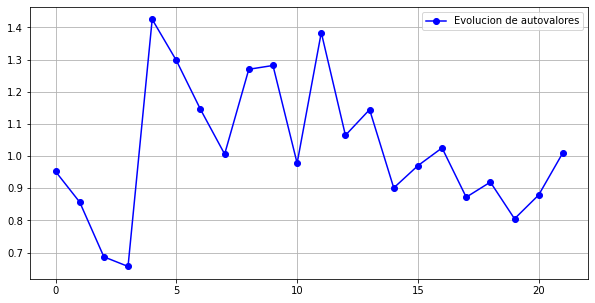

In [819]:
fig,ax = plt.subplots(figsize = (10,5))
plt.plot(SST1[:,4],color='Blue',Marker='o',label='Evolucion de autovalores')
plt.legend()
plt.grid()

<ipython-input-820-d1c5732e4060>:3: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(SST1d[:,4],color='Blue',Marker='o',label='Evolucion de autovalores')


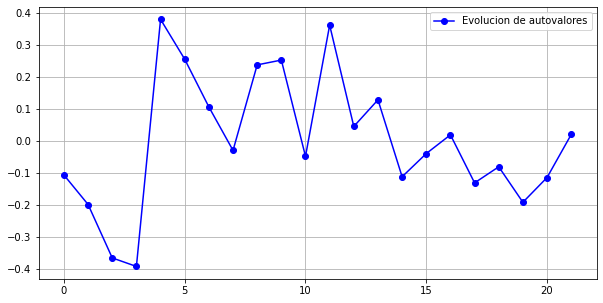

In [820]:
SST1d=signal.detrend(SST1,axis=0)
fig,ax = plt.subplots(figsize = (10,5))
plt.plot(SST1d[:,4],color='Blue',Marker='o',label='Evolucion de autovalores')
plt.legend()
plt.grid()

<ipython-input-821-3d1c84fcc11a>:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(SST1d[:,4]-SST1[:,4],color='Blue',Marker='o')


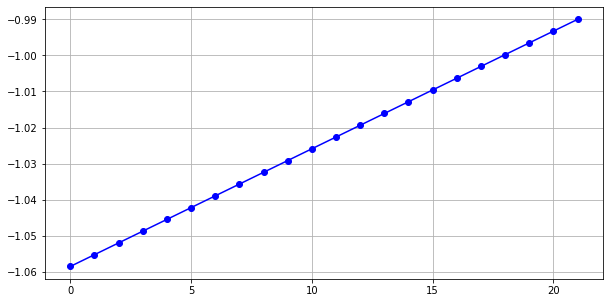

In [821]:
fig,ax = plt.subplots(figsize = (10,5))
plt.plot(SST1d[:,4]-SST1[:,4],color='Blue',Marker='o')
plt.grid()

In [822]:
CHL=CHL.reshape(nyears*nm,nlat1,nlon1)
CHL.shape

(264, 361, 480)

In [823]:

lonmin1,lonmax1,latmin1,latmax1 =  -18,-12,10,15
CH = CHL[:,:,(lon1>lonmin1)&(lon1<lonmax1)][:,(lat1>latmin1)&(lat1<latmax1),:]
yrs = np.arange(1998,2020)
lon_CH= lon1[(lon1>lonmin1)&(lon1<lonmax1)]
lat_CH=lat1[(lat1>latmin1)&(lat1<latmax1)]

CH.shape

(264, 120, 144)

In [824]:
nt,nlat2,nlon2=CH.shape

In [825]:
CH=CH.reshape(nyears, nm, nlat2,nlon2)
nm=12
nt=nm*nyears

In [826]:
CH_e=CH.reshape(nyears,nm,nlat2*nlon2)[:,[0],:].mean(1) #ponemos los dCHos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
CH_e=(CH_e-CH_e.mean(0))
CH_e.shape
CH_f=CH.reshape(nyears,nm,nlat2*nlon2)[:,[1],:].mean(1) #ponemos los dCHos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
CH_f=(CH_f-CH_f.mean(0))
CH_f.shape

CH_m=CH.reshape(nyears,nm,nlat2*nlon2)[:,[2],:].mean(1) #ponemos los dCHos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
CH_m=(CH_m-CH_m.mean(0))
CH_m.shape

CH_a=CH.reshape(nyears,nm,nlat2*nlon2)[:,[3],:].mean(1) #ponemos los dCHos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
CH_a=(CH_a-CH_a.mean(0))
CH_a.shape

CH_y=CH.reshape(nyears,nm,nlat2*nlon2)[:,[4],:].mean(1) #ponemos los dCHos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
CH_y=(CH_y-CH_y.mean(0))
CH_y.shape

CH_j=CH.reshape(nyears,nm,nlat2*nlon2)[:,[5],:].mean(1) #ponemos los dCHos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
CH_j=(CH_j-CH_j.mean(0))
CH_j.shape

CH_l=CH.reshape(nyears,nm,nlat2*nlon2)[:,[6],:].mean(1) #ponemos los dCHos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
CH_l=(CH_l-CH_l.mean(0))
CH_l.shape

CH_u=CH.reshape(nyears,nm,nlat2*nlon2)[:,[7],:].mean(1) #ponemos los dCHos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
CH_u=(CH_u-CH_u.mean(0))
CH_u.shape

CH_s=CH.reshape(nyears,nm,nlat2*nlon2)[:,[8],:].mean(1) #ponemos los dCHos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
CH_s=(CH_s-CH_s.mean(0))
CH_s.shape

CH_o=CH.reshape(nyears,nm,nlat2*nlon2)[:,[9],:].mean(1) #ponemos los dCHos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
CH_o=(CH_o-CH_o.mean(0))
CH_o.shape

CH_n=CH.reshape(nyears,nm,nlat2*nlon2)[:,[10],:].mean(1) #ponemos los dCHos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
CH_n=(CH_n-CH_n.mean(0))
CH_n.shape

CH_d=CH.reshape(nyears,nm,nlat2*nlon2)[:,[11],:].mean(1) #ponemos los dCHos como si fueran
#años, meses, espacio y sólo promediamos el mes 0 que es enero
CH_d=(CH_d-CH_d.mean(0))
CH_d.shape
CH_inv=[]
CH_pri=[]
CH_ver=[]
CH_oto=[]

for i in range (21):
    CH_inv=np.concatenate([CH_inv,CH_d[i,],CH_e[i+1,],CH_f[i+1,]])                     
    CH_pri=np.concatenate([CH_pri,CH_m[i+1,],CH_a[i+1,],CH_y[i+1,]])
    CH_ver=np.concatenate([CH_ver,CH_j[i+1,],CH_l[i+1,],CH_u[i+1,]])
    CH_oto=np.concatenate([CH_oto,CH_s[i+1,],CH_o[i+1,],CH_n[i+1,]])



In [827]:
######AQUÍ ESTÁ LA OTRA PARTE PARA SELECCIONAR ESTACIONES
CH_pri=CH_pri.reshape(3*21,nlat2*nlon2)
CH_ver=CH_ver.reshape(21*3,nlat2*nlon2)
CH=CH.reshape(nyears*nm,nlat2*nlon2)
CH_oto=CH_oto.reshape(3*21,nlat2*nlon2)
CH_inv=CH_inv.reshape(21*3,nlat2*nlon2)

In [87]:

C=np.dot(np.transpose(CH),AT)
C.shape

(17280, 250)

In [90]:
eof,d,eof2=linalg.svd(C,0)

In [91]:
d.shape

(250,)

In [831]:
scf=np.power(d,2)/sum(np.power(d,2))
sum(scf[:3])

0.9637949241563337

<ipython-input-832-2218e305c4db>:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(np.cumsum(scf[:50]),color='Blue',Marker='o',label='Evolucion de covarianzas cuadradas')


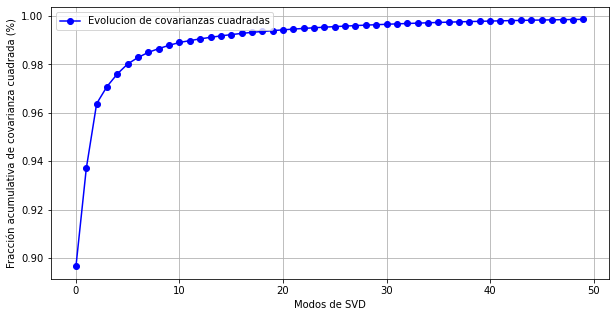

In [832]:


fig,ax = plt.subplots(figsize = (10,5))
plt.plot(np.cumsum(scf[:50]),color='Blue',Marker='o',label='Evolucion de covarianzas cuadradas')
ax.set_xlabel('Modos de SVD')
ax.set_ylabel('Fracción acumulativa de covarianza cuadrada (%)')
plt.legend()
plt.grid()


In [833]:

###############################################################################
#AQUÍ YA NO SE COMO SEGUIR, HE INTENTADO DIBUJAR LA FRACCIÓN ACMULATIVA 
#QUE EXPLICA LA COVARIANZA AL CUADRADO Y LUEGO INTENTO SACAR FIGURAS PERO ESTOY PERDIDO, PARA LA EOF DE SST
#SALE ALGO COHERENTE PERO EN CLOROFILA NO VEO NADA INTERESANTE Y PARECE NO FUNCIONAR


##############################################################################

In [834]:
CH.shape

(264, 17280)

In [835]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: statsmodels in c:\users\miguel\anaconda3\lib\site-packages (0.12.0)



In [93]:
PC=np.dot(CH,eof[:,:5])
PC

masked_array(
  data=[[ 38932.06263563,    219.55755137,  -7239.89799635,
          17542.73577201,  -3969.36594731],
        [ 26753.02354772,  -6350.15910554,   3482.64846606,
          12620.48315113,   6777.19028226],
        [ 41834.76845365, -15937.01185654,  -5544.36831742,
          25845.06410559,   4735.01476996],
        ...,
        [ 16541.99187146,   4851.65624096,   8500.01737508,
          -1643.01507638,   1821.86610546],
        [ 15836.91338749,   4419.69794991,   7979.67925819,
          -1510.7174191 ,   1511.75240476],
        [ 15220.15441806,   4063.0855511 ,   7731.60006208,
          -1766.62747341,   1519.86626589]],
  mask=False,
  fill_value=-999.0)

In [94]:
PCs=(PC-np.mean(PC,0))/np.std(PC,0)
PCs.shape
nyears=22
nm=12
nt=264

Text(0.5, 1.0, 'Primera componente principal ')

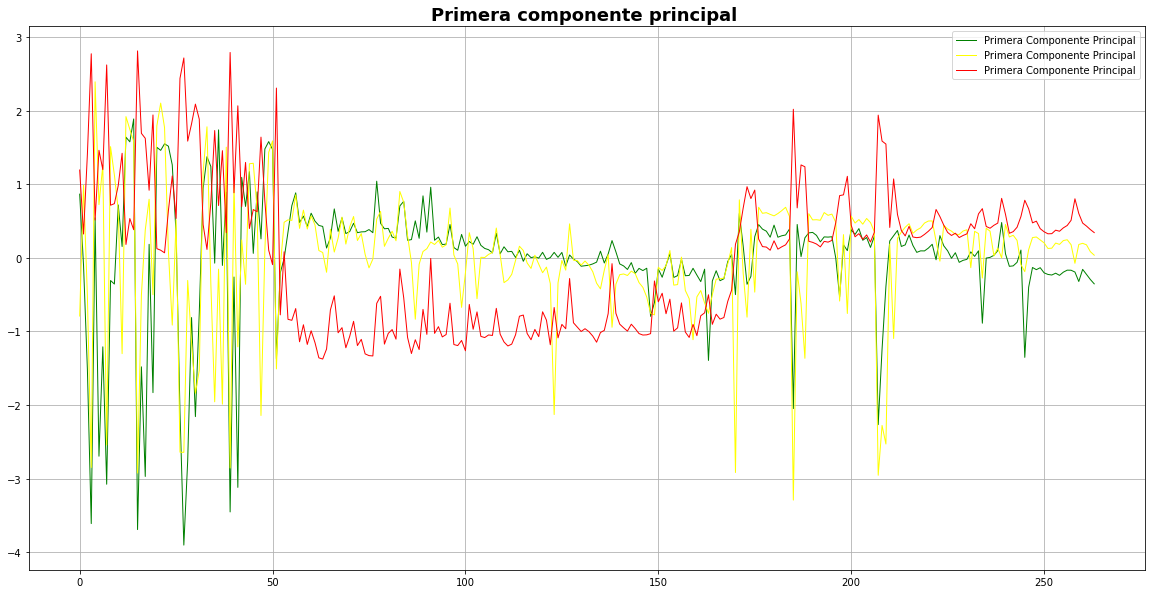

In [95]:
PCp=PCs.reshape(nyears*nm,5)
fig,ax=plt.subplots(figsize = (20,10))
ax.plot(np.arange(nt),signal.detrend(PCp[:,1]),linewidth= 1,color='green',label='Primera Componente Principal')
ax.plot(np.arange(nt),signal.detrend(PCp[:,2]),linewidth= 1,color='yellow',label='Primera Componente Principal')
ax.plot(np.arange(nt),signal.detrend(PCp[:,0]),linewidth= 1,color='red',label='Primera Componente Principal')
ax.grid()
ax.legend()
ax.set_title('Primera componente principal ',fontsize=18,weight='bold')

Text(0, 0.5, 'Anomalía normalizada')

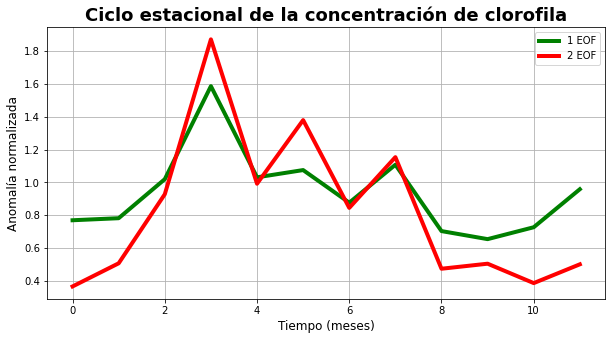

In [839]:
PC_var=PCs.reshape(nyears,nm,5).std(0)
PCpinto=np.squeeze(PC_var)
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(np.arange(nm),PCpinto[:,0],linewidth= 4,color='green',label='1 EOF')
ax.plot(np.arange(nm),PCpinto[:,1],linewidth= 4,color='red',label='2 EOF')
ax.grid()
ax.legend()
ax.set_title('Ciclo estacional de la concentración de clorofila',fontsize=18,weight='bold')
ax.set_xlabel('Tiempo (meses)',fontsize=12)
ax.set_ylabel('Anomalía normalizada',fontsize=12)

In [840]:
#ME CENTRO EN VERANO POR LO QUE PARECE

In [841]:
#la máxima varianza se da en junio, por lo que hay que 

In [842]:
CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(CH),np.transpose(PCs[:,0]),0.01)

C:\Users\Miguel\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Text(0.5, 1.0, 'Regresion de la PC1 ')

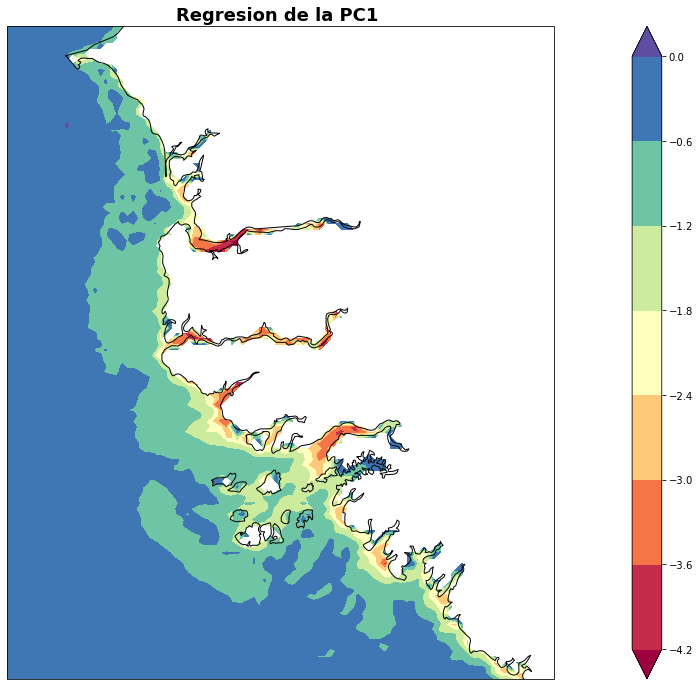

In [843]:
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,regEOF.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Regresion de la PC1 ',fontsize=18,weight='bold')

Text(0.5, 1.0, 'Regresion de la PC2 ')

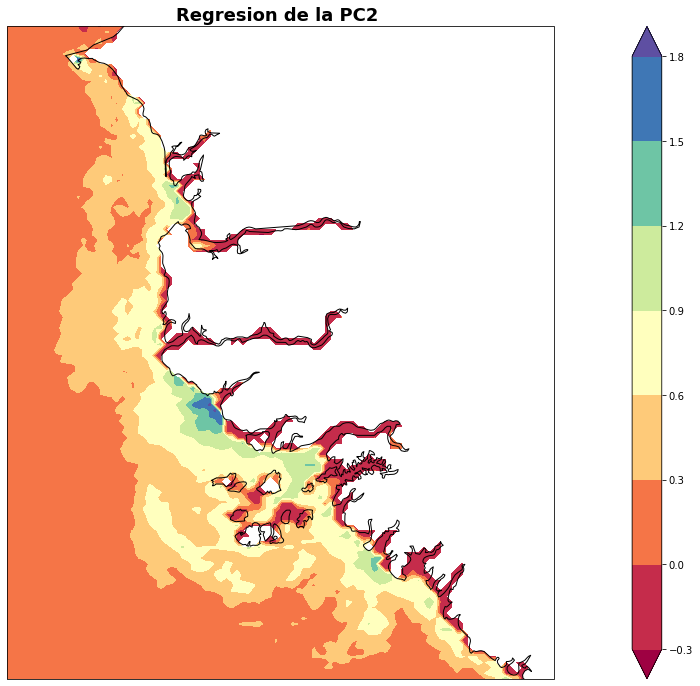

In [844]:
CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(CH),np.transpose(PCs[:,1]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,regEOF.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Regresion de la PC2 ',fontsize=18,weight='bold')

In [96]:
PC=np.dot(AT,eof2[:,:5])


In [98]:
PCss=(PC-np.mean(PC,0))/np.std(PC,0)


Text(0, 0.5, 'Anomalía normalizada')

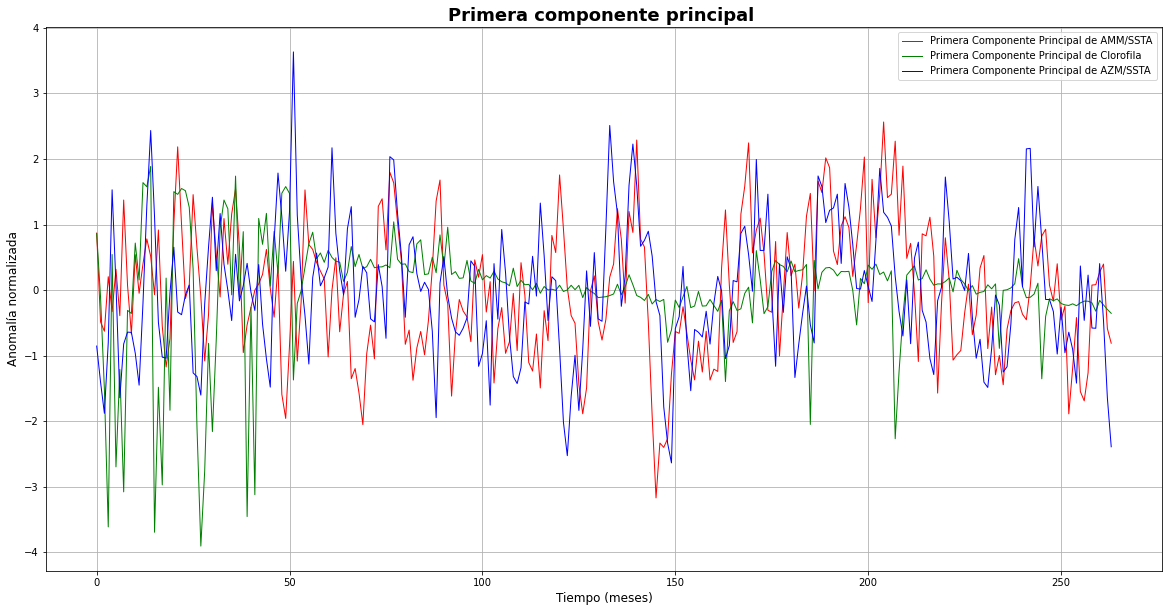

In [99]:
PCpp=PCss.reshape(nyears*nm,5)
fig,ax=plt.subplots(figsize = (20,10))
ax.plot(np.arange(nt),signal.detrend(PCss[:,1]),linewidth= 1,color='red',label='Primera Componente Principal de AMM/SSTA')
ax.plot(np.arange(nt),signal.detrend(PCs[:,1]),linewidth= 1,color='green',label='Primera Componente Principal de Clorofila')
ax.plot(np.arange(nt),signal.detrend(PCss[:,0]),linewidth= 1,color='blue',label='Primera Componente Principal de AZM/SSTA')

ax.grid()
ax.legend()
ax.set_title('Primera componente principal ',fontsize=18,weight='bold')
ax.set_xlabel('Tiempo (meses)',fontsize=12)
ax.set_ylabel('Anomalía normalizada',fontsize=12)

In [848]:
(PCss[:,0]).shape

(264,)

Text(0.5, 1.0, 'Regresion de la PC1 ')

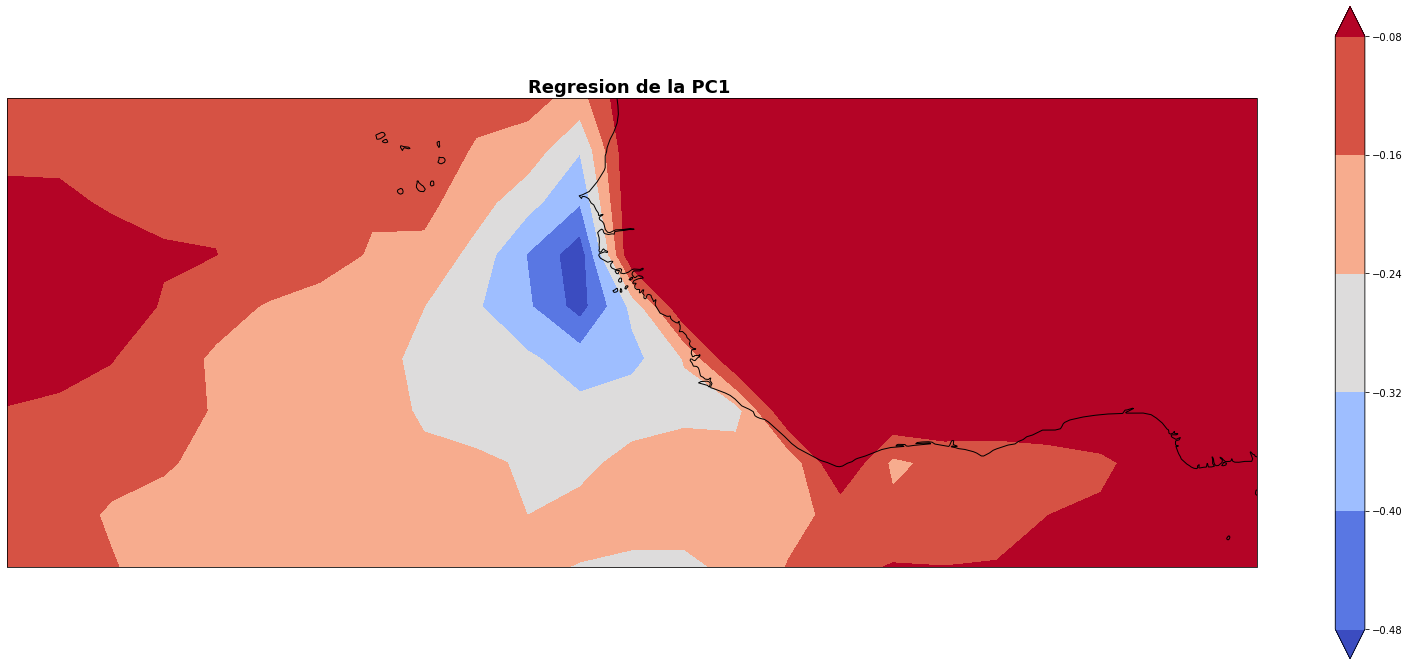

In [849]:
CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT),np.transpose(PCss[:,0]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Regresion de la PC1 ',fontsize=18,weight='bold')

Text(0.5, 1.0, 'Correlación de la PC1 ')

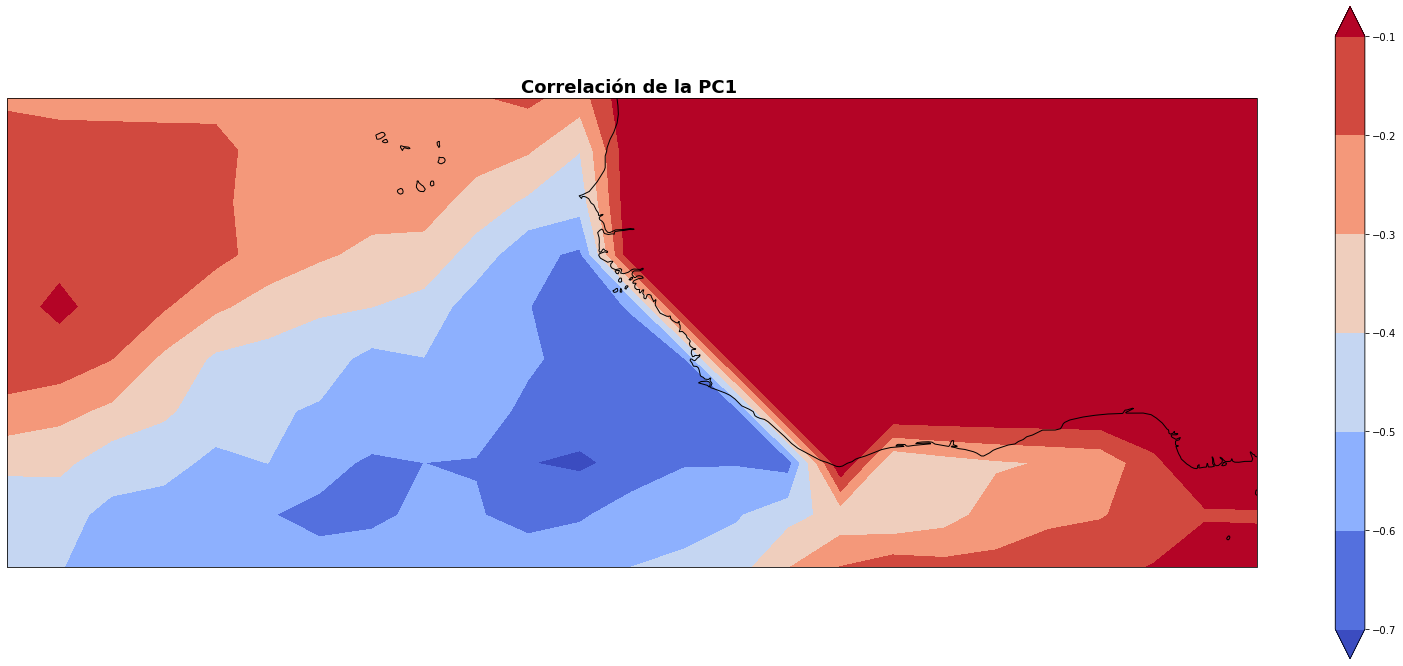

In [850]:
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,CEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Correlación de la PC1 ',fontsize=18,weight='bold')

Text(0.5, 1.0, 'Regresion de la PC2 ')

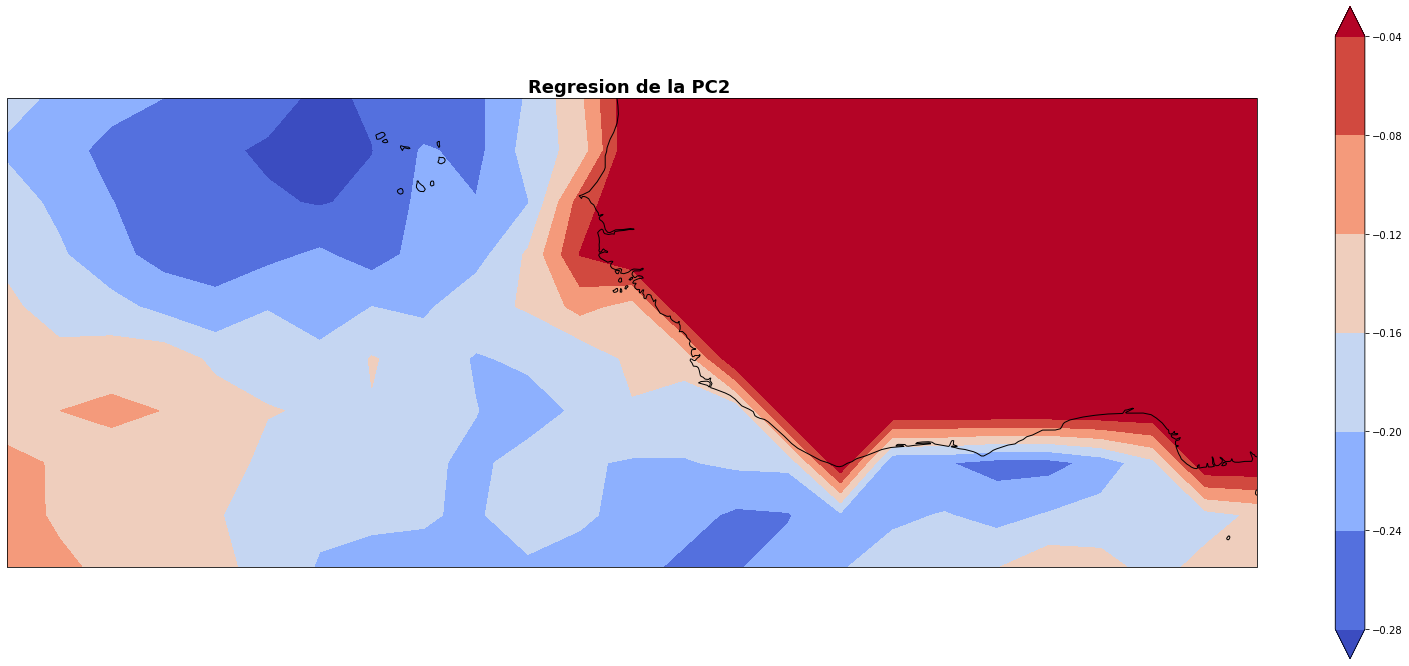

In [851]:
CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT),np.transpose(PCss[:,1]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Regresion de la PC2 ',fontsize=18,weight='bold')

Text(0.5, 1.0, 'Correlación de la PC2 ')

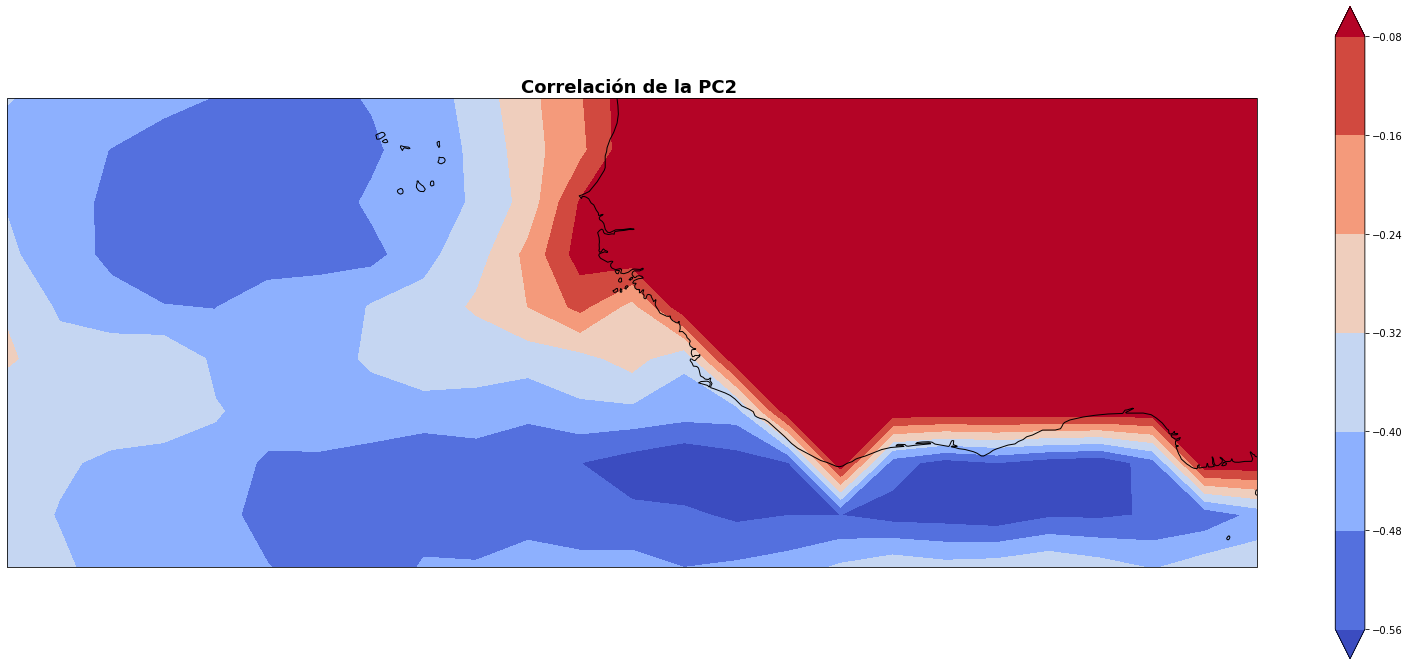

In [852]:
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,CEOF.reshape(len(lat_AT),len(lon_AT)),cmap='coolwarm',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('Correlación de la PC2 ',fontsize=18,weight='bold')

In [853]:
#SOY TONTO, HABÍA UTILIZADO EL COEFICIENTE DE EXPANSIÓN DE LA SST NO DE CLOROFILA¡¡¡¡¡

#A CONTINUACIÓN GEMERO LAS COMPOSITES

In [859]:
cio=PCss[:,1][PCss[:,1]>2]

ind=np.where(PCss[:,1]>2)
ind=np.asarray(ind[0])
ind.shape
ind=pd.unique(ind)
ind

#DEBES INTRODUCIR EL ARRAY QUE APARECE DENTRO DEL CORCHETE DE LA IZQUIERDA DE PCs

array([ 21, 140, 169, 189, 199, 204, 207], dtype=int64)

In [860]:
cio=PCs[[ 21, 140, 169, 189, 199, 204, 207 ],0]

In [861]:
ciom=PCss[:,0][PCss[:,0]>2]

ini=np.where(PCss[:,0]>2)
ini=np.asarray(ini[0])
ini.shape
ini=pd.unique(ini)
ini

array([ 14,  51,  61,  76, 133, 139, 241, 242], dtype=int64)

In [862]:
ciom=PCs[[  14,  51,  61,  76, 133, 139, 241, 242],0]

In [863]:
EE=CH[ini]
FF=CH[ind]

AA=AT[ini]
BB=AT[ind]

C:\Users\Miguel\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Text(0.5, 1.0, 'CORRELACIÓN DE ANOMALÍAS MÁXIMAS EC1')

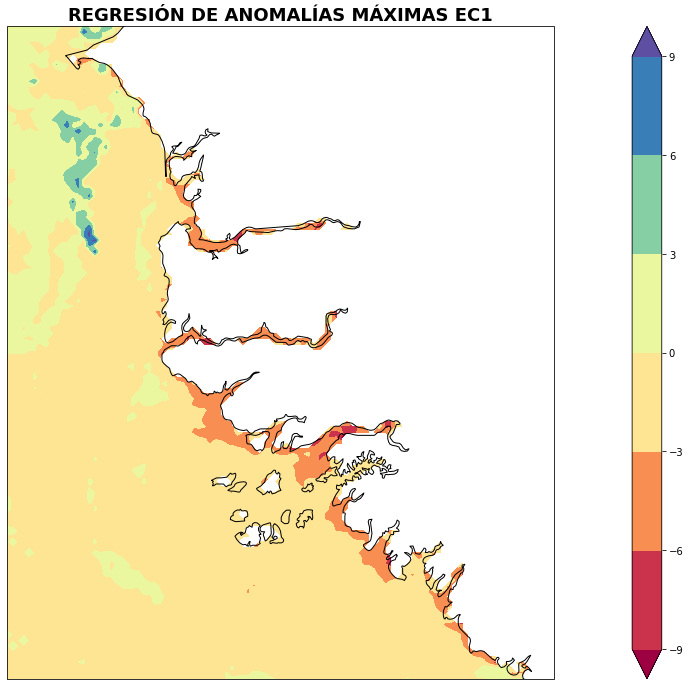

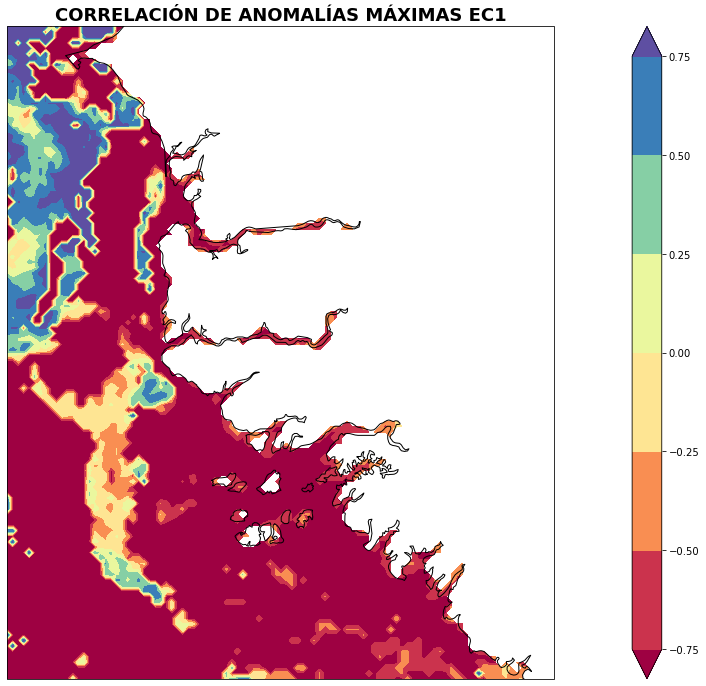

In [864]:
CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(EE),np.transpose(ciom),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,regEOF.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('REGRESIÓN DE ANOMALÍAS MÁXIMAS EC1',fontsize=18,weight='bold')

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,CEOF.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('CORRELACIÓN DE ANOMALÍAS MÁXIMAS EC1',fontsize=18,weight='bold')

Text(0.5, 1.0, 'CORRELACIÓN DE ANOMALÍAS MÁXIMAS EC1')

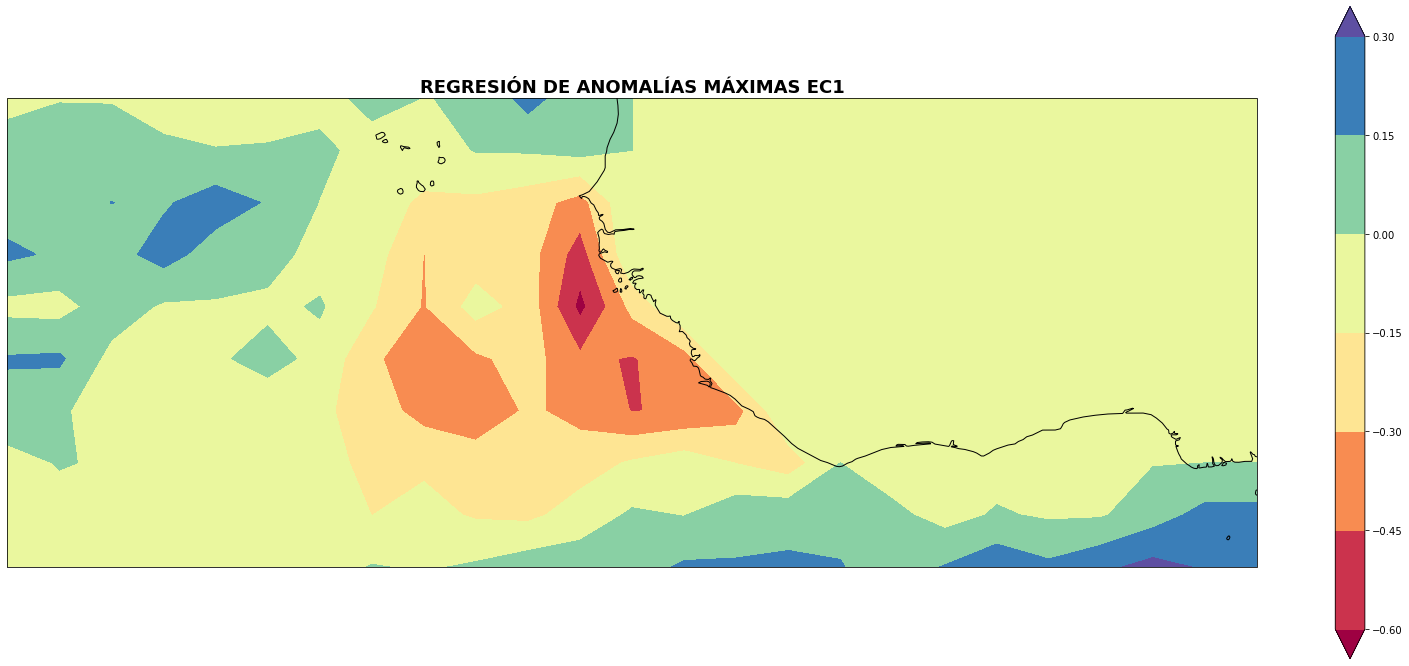

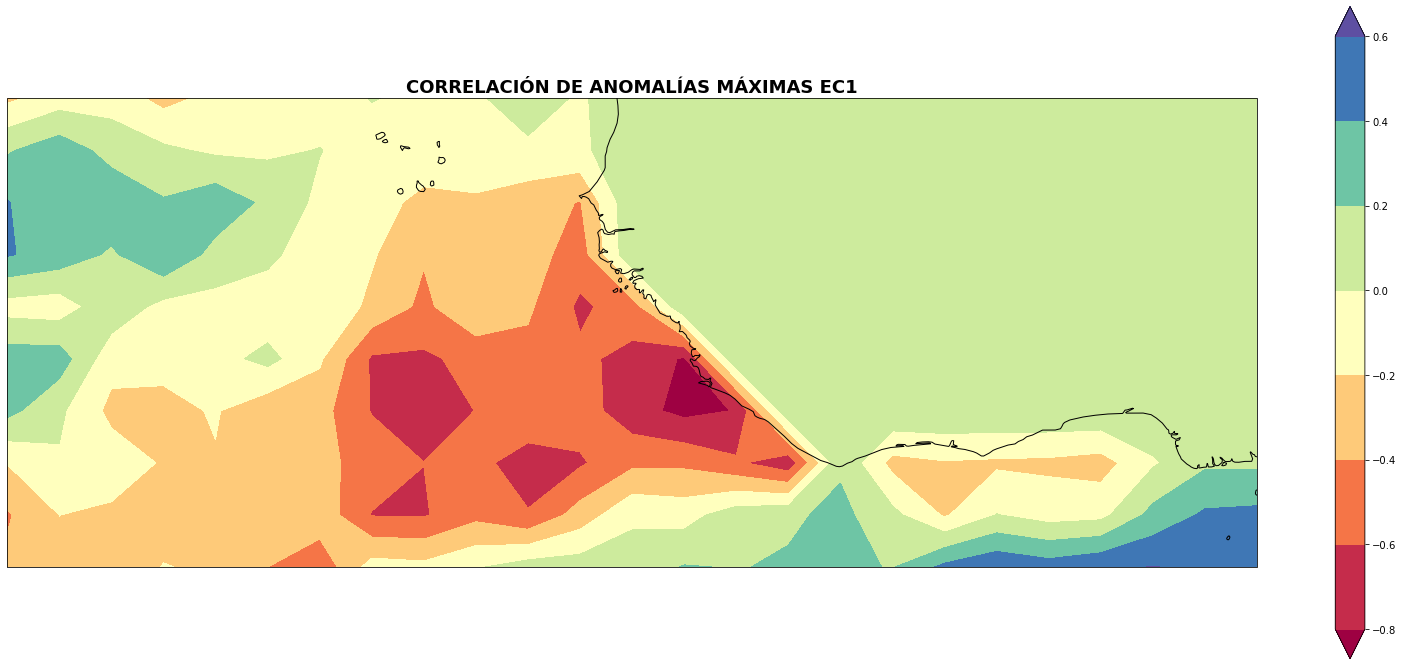

In [865]:
CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AA),np.transpose(ciom),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('REGRESIÓN DE ANOMALÍAS MÁXIMAS EC1',fontsize=18,weight='bold')

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,CEOF.reshape(len(lat_AT),len(lon_AT)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('CORRELACIÓN DE ANOMALÍAS MÁXIMAS EC1',fontsize=18,weight='bold')

Text(0.5, 1.0, 'CORRELACIÓN DE ANOMALÍAS MÁXIMAS EC1')

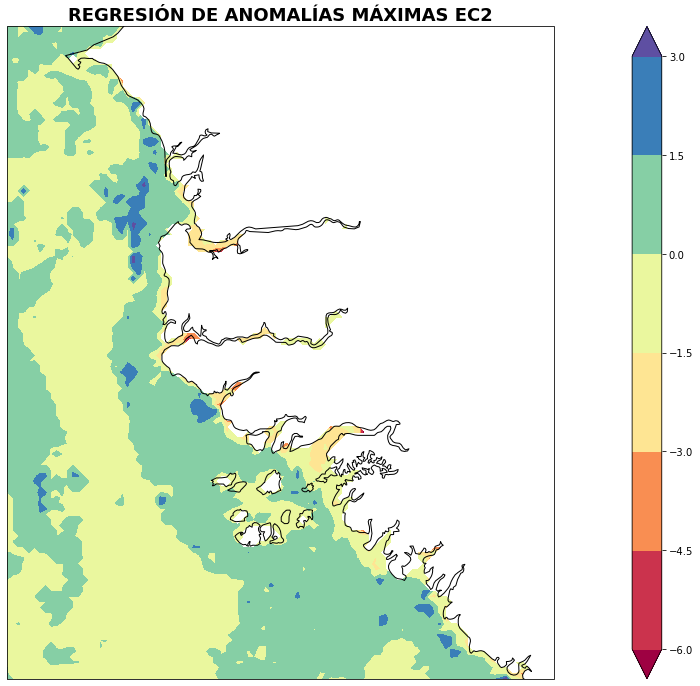

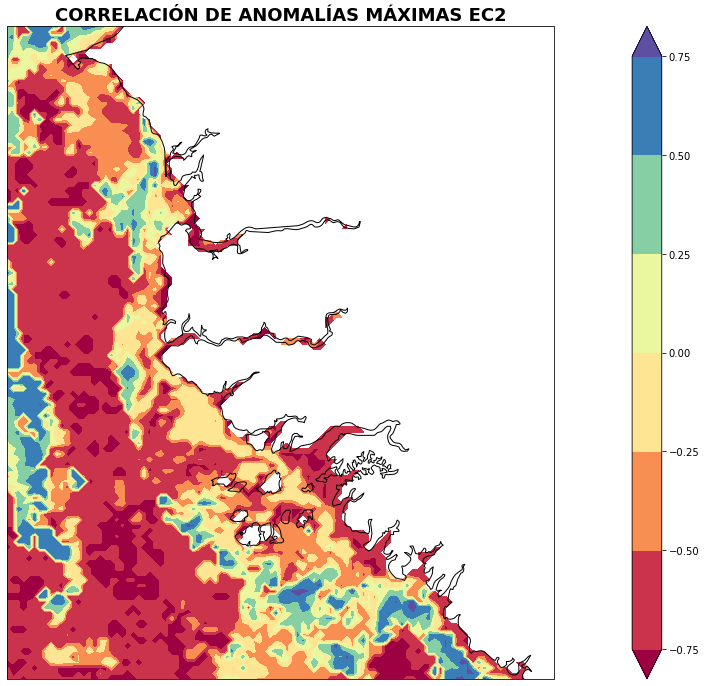

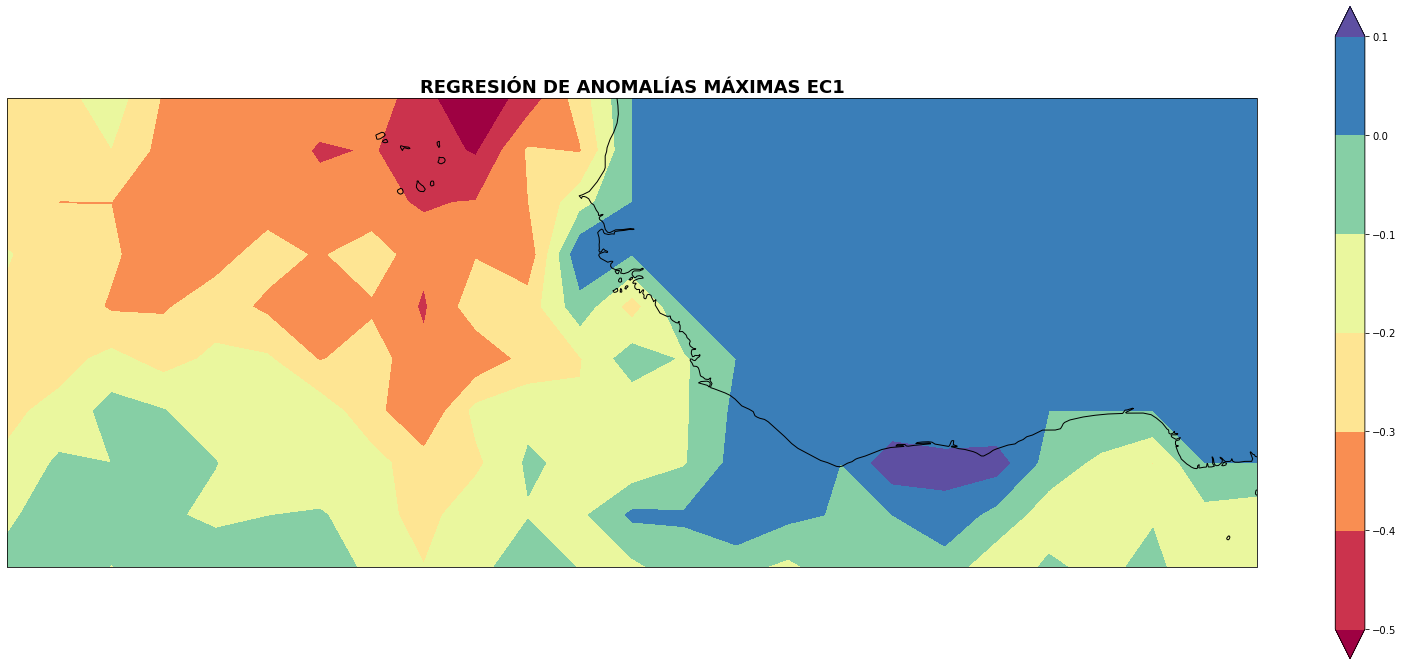

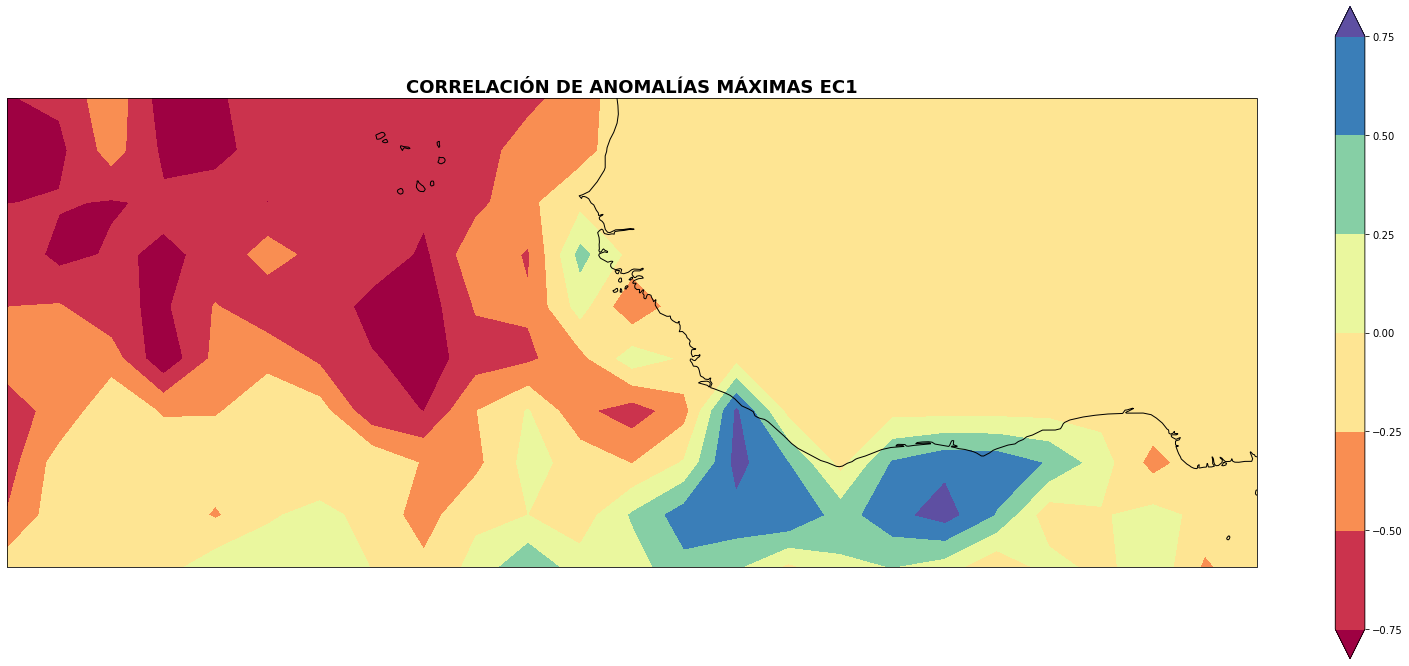

In [867]:
CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(FF),np.transpose(cio),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,regEOF.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('REGRESIÓN DE ANOMALÍAS MÁXIMAS EC2',fontsize=18,weight='bold')

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,CEOF.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('CORRELACIÓN DE ANOMALÍAS MÁXIMAS EC2',fontsize=18,weight='bold')

CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(BB),np.transpose(cio),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('REGRESIÓN DE ANOMALÍAS MÁXIMAS EC1',fontsize=18,weight='bold')

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,CEOF.reshape(len(lat_AT),len(lon_AT)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('CORRELACIÓN DE ANOMALÍAS MÁXIMAS EC1',fontsize=18,weight='bold')

Text(0.5, 1.0, 'REGRESIÓN DE ANOMALÍAS MÁXIMAS EC2')

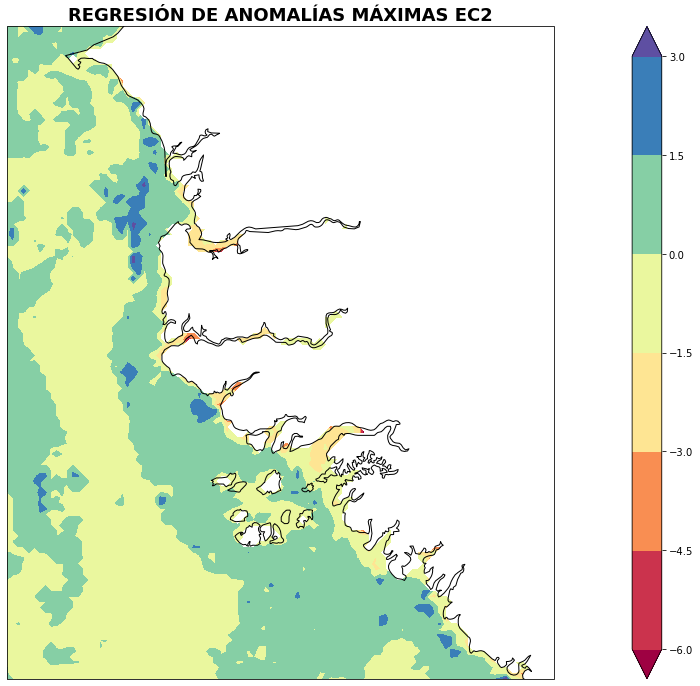

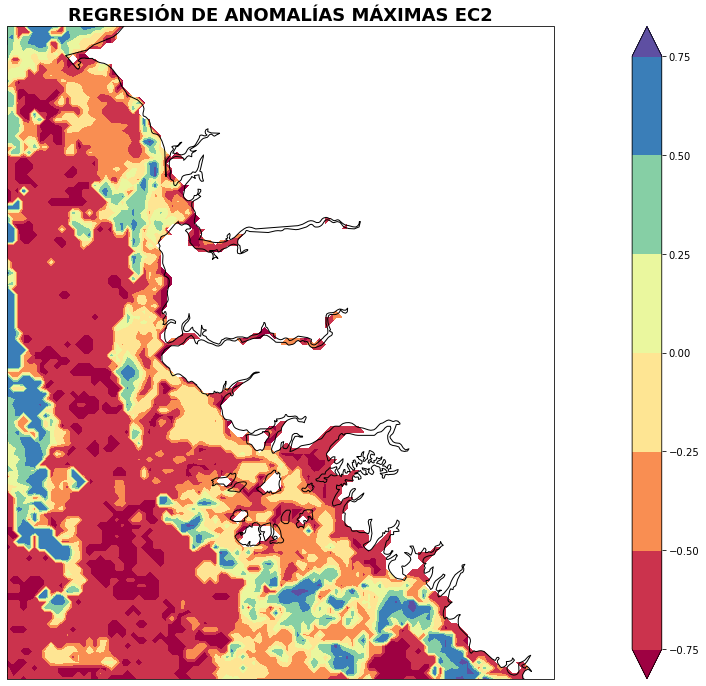

In [866]:
CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(FF),np.transpose(cio),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,regEOF.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('REGRESIÓN DE ANOMALÍAS MÁXIMAS EC2',fontsize=18,weight='bold')

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,CEOF.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('REGRESIÓN DE ANOMALÍAS MÁXIMAS EC2',fontsize=18,weight='bold')

In [755]:
cio=PCss[:,1][PCss[:,1]<-2]

ind=np.where(PCss[:,1]<-2)
ind=np.asarray(ind[0])
ind.shape
ind=pd.unique(ind)
ind

#DEBES INTRODUCIR EL ARRAY QUE APARECE DENTRO DEL CORCHETE DE LA IZQUIERDA DE PCs

array([  2,   9,  17,  18,  19,  28,  38,  39,  48,  49,  50,  52,  60,
        63,  66,  67,  68,  69,  70,  71,  72,  80,  81,  82,  83,  84,
        85,  92,  93,  97, 103, 104, 106, 107, 109, 112, 113, 114, 115,
       117, 124, 125, 126, 127, 131, 144, 145, 146, 147, 148, 149, 150,
       151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 165, 166, 177,
       213, 218, 222, 223, 224, 227, 231, 233, 234, 235, 236, 252, 253,
       255, 256, 257, 262, 263], dtype=int64)

In [756]:
cio=PCs[[  2,   9,  17,  18,  19,  28,  38,  39,  48,  49,  50,  52,  60,
        63,  66,  67,  68,  69,  70,  71,  72,  80,  81,  82,  83,  84,
        85,  92,  93,  97, 103, 104, 106, 107, 109, 112, 113, 114, 115,
       117, 124, 125, 126, 127, 131, 144, 145, 146, 147, 148, 149, 150,
       151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 165, 166, 177,
       213, 218, 222, 223, 224, 227, 231, 233, 234, 235, 236, 252, 253,
       255, 256, 257, 262, 263],0]

In [757]:
ciom=PCss[:,0][PCss[:,0]<-2]

ini=np.where(PCss[:,0]<-2)
ini=np.asarray(ini[0])
ini.shape
ini=pd.unique(ini)
ini

array([  0,   1,   2,   3,   6,   7,   8,   9,  10,  11,  17,  18,  25,
        26,  27,  43,  44,  45,  55,  75,  87,  88,  93,  94,  95,  99,
       100, 102, 107, 108, 109, 110, 120, 121, 122, 123, 124, 125, 126,
       128, 147, 148, 149, 150, 153, 154, 155, 156, 157, 159, 163, 164,
       176, 181, 182, 185, 186, 209, 211, 216, 217, 228, 229, 230, 231,
       232, 235, 236, 237, 249, 251, 252, 253, 254, 258, 259, 262, 263],
      dtype=int64)

In [758]:
ciom=PCs[[0,   1,   2,   3,   6,   7,   8,   9,  10,  11,  17,  18,  25,
        26,  27,  43,  44,  45,  55,  75,  87,  88,  93,  94,  95,  99,
       100, 102, 107, 108, 109, 110, 120, 121, 122, 123, 124, 125, 126,
       128, 147, 148, 149, 150, 153, 154, 155, 156, 157, 159, 163, 164,
       176, 181, 182, 185, 186, 209, 211, 216, 217, 228, 229, 230, 231,
       232, 235, 236, 237, 249, 251, 252, 253, 254, 258, 259, 262, 263],0]

Text(0.5, 1.0, 'REGRESIÓN DE ANOMALÍAS MÍNIMAS EC2')

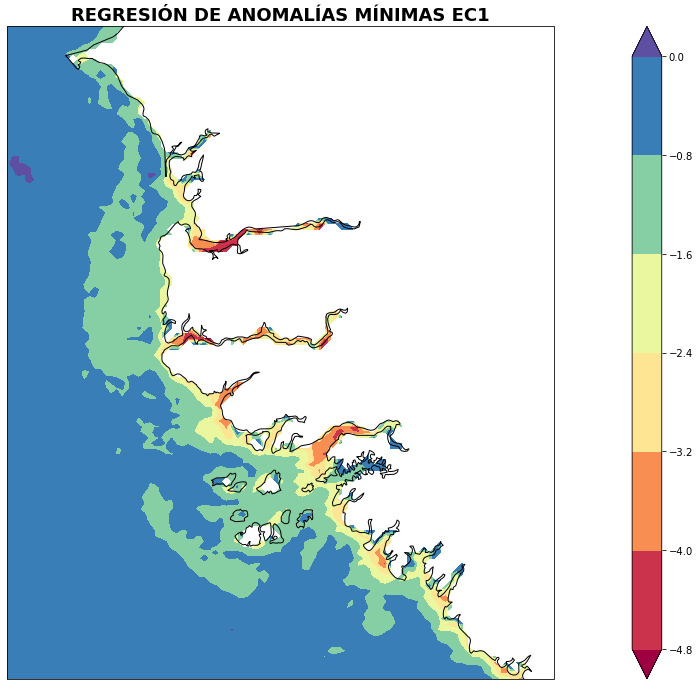

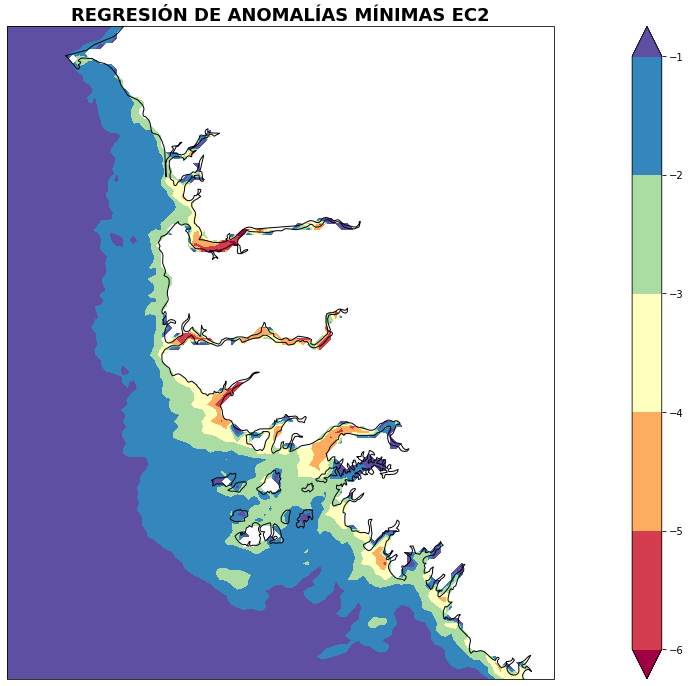

In [759]:
EE=CH[ini]
FF=CH[ind]

CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(EE),np.transpose(ciom),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,regEOF.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('REGRESIÓN DE ANOMALÍAS MÍNIMAS EC1',fontsize=18,weight='bold')

CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(FF),np.transpose(cio),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,regEOF.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('REGRESIÓN DE ANOMALÍAS MÍNIMAS EC2',fontsize=18,weight='bold')

In [760]:
PCci=stats.tsa.tsatools.detrend(PCss[:,1])
PCchl=stats.tsa.tsatools.detrend(PCs[:,0])
PCcc=stats.tsa.tsatools.detrend(PCss[:,0])


Text(0, 0.5, 'Anomalía normalizada')

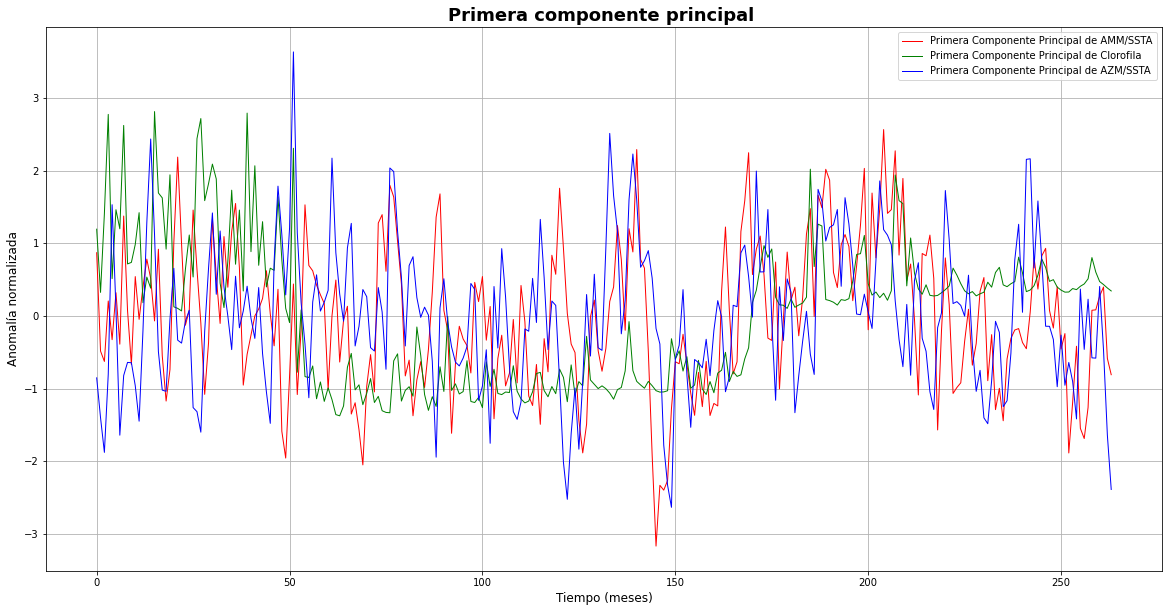

In [761]:
fig,ax=plt.subplots(figsize = (20,10))
ax.plot(np.arange(nt),(PCci),linewidth= 1,color='red',label='Primera Componente Principal de AMM/SSTA')
ax.plot(np.arange(nt),(PCchl),linewidth= 1,color='green',label='Primera Componente Principal de Clorofila')
ax.plot(np.arange(nt),(PCcc),linewidth= 1,color='blue',label='Primera Componente Principal de AZM/SSTA')

ax.grid()
ax.legend()
ax.set_title('Primera componente principal ',fontsize=18,weight='bold')
ax.set_xlabel('Tiempo (meses)',fontsize=12)
ax.set_ylabel('Anomalía normalizada',fontsize=12)

In [762]:
np.corrcoef(PCcc,PCchl) #AQUÍ SI QUE SE INTUYE UN POCO MÁS

array([[1.        , 0.02912748],
       [0.02912748, 1.        ]])

In [763]:
np.corrcoef(PCci,PCchl)

array([[1.       , 0.2284317],
       [0.2284317, 1.       ]])

In [764]:
#NO PARECE HABER CORRELACIÓN SIGNIFICATIVA

In [765]:
y1=stats.tsa.stattools.ccovf(PCchl,PCci)
y2=stats.tsa.stattools.ccovf(PCchl,PCcc)
seasons, trend = fit_seasons(y1)
trendy1=trend
seasons, trend = fit_seasons(y1)
trendy2=trend


Text(0.5, 1.0, 'Autocorrelación y Correlación Cruzada con ambos modos ')

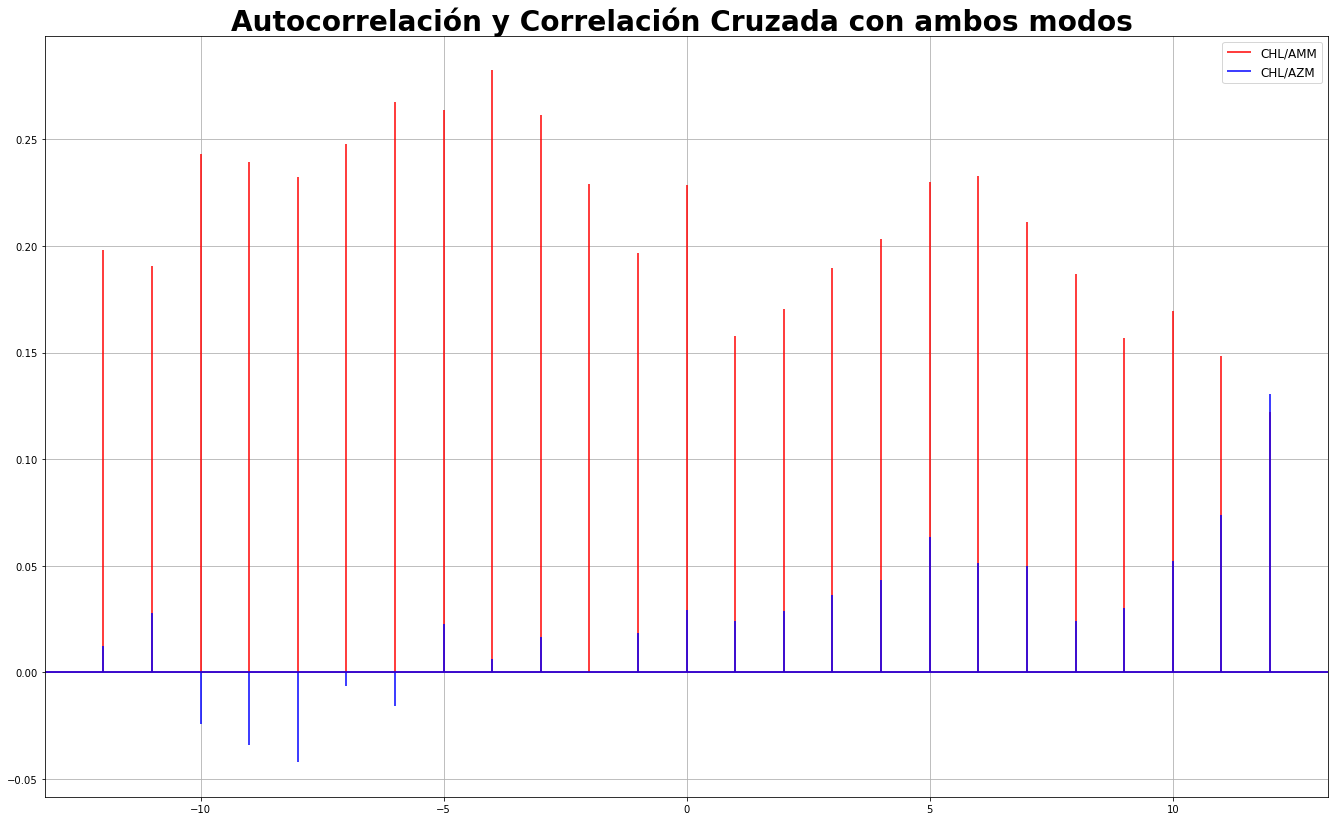

In [766]:
fig=plt.subplots(1, 1, sharex=False,figsize=(23,14))
plt.xcorr(PCci,PCchl,maxlags=12,color='red',label='CHL/AMM')
plt.xcorr(PCcc,PCchl,maxlags=12,color='blue',label='CHL/AZM')

plt.grid()
plt.legend(fontsize=12)
plt.title('Autocorrelación y Correlación Cruzada con ambos modos ',fontsize=28,weight='bold')

In [767]:
!pip install seasonal

In [768]:
seasons, trend = fit_seasons(PCcc)
trendPCcc=trend

C:\Users\Miguel\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [769]:
seasons, trend = fit_seasons(PCci)
trendPCci=trend

In [770]:
seasons, trend = fit_seasons(PCchl)
trendPCchl=trend

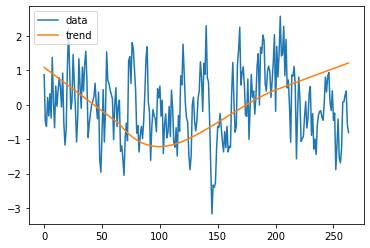

In [771]:
plt.figure()
plt.plot(PCci, label='data')
plt.plot(trend, label='trend')
plt.legend(loc='upper left')

In [772]:
nt=264

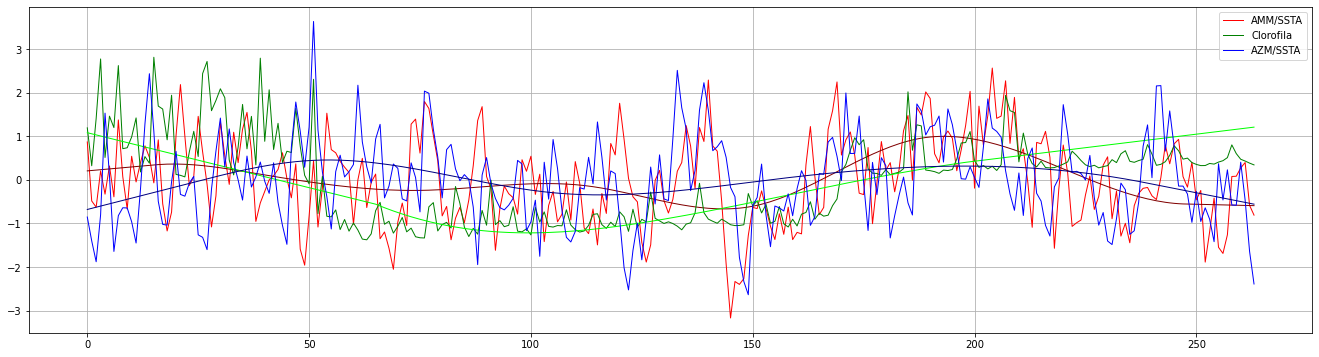

In [773]:
fig,ax=plt.subplots(1, 1, sharex=False,figsize=(23,6))
ax.plot(np.arange(nt),(PCci),linewidth= 1,color='red',label='AMM/SSTA')
ax.plot(np.arange(nt),(trendPCci),linewidth= 1,color='maroon')
ax.plot(np.arange(nt),(PCchl),linewidth= 1,color='green',label='Clorofila')
ax.plot(np.arange(nt),(trendPCchl),linewidth= 1,color='lime')
ax.plot(np.arange(nt),(PCcc),linewidth= 1,color='blue',label='AZM/SSTA')
ax.plot(np.arange(nt),(trendPCcc),linewidth= 1,color='navy')
ax.grid()
ax.legend()


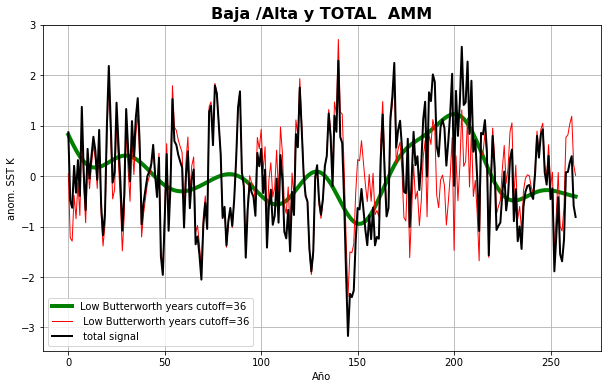

In [774]:
nyc=36
n=10
Wn=1/18 #VOY FILTRANDO POR ESTACIONES f=1/3 Wn=2*f
b,a=signal.butter(n, Wn, btype='low', analog=False, output='ba', fs=None)
#Filtro la señal ampliada y me quedo con la parte central:
lowamm = signal.filtfilt(b,a,PCci)

b,a=signal.butter(n, Wn, btype='high', analog=False, output='ba', fs=None)
#Filtro la señal ampliada y me quedo con la parte central:
high = signal.filtfilt(b,a,PCci)

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('Baja /Alta y TOTAL  AMM',fontsize=16,weight='bold')
ax.set_xlabel('Año')
ax.set_ylabel('anom. SST K')
ax.plot(np.arange(nt),lowamm,linewidth= 4,color='green',label='Low Butterworth years cutoff='+str(nyc))
ax.plot(np.arange(nt),high,linewidth= 1,color='red',label=' Low Butterworth years cutoff='+str(nyc))
ax.plot(np.arange(nt),PCci,linewidth= 2,color='black',label=' total signal')

ax.legend()
ax.grid()

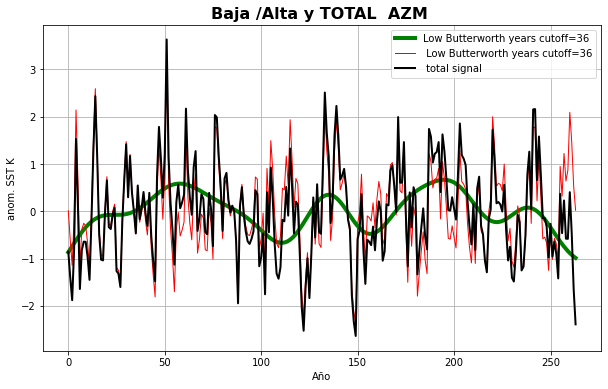

In [775]:
nyc=36
n=10
Wn=1/18
b,a=signal.butter(n, Wn, btype='low', analog=False, output='ba', fs=None)
#Filtro la señal ampliada y me quedo con la parte central:
lowazm = signal.filtfilt(b,a,PCcc)

b,a=signal.butter(n, Wn, btype='high', analog=False, output='ba', fs=None)
#Filtro la señal ampliada y me quedo con la parte central:
high = signal.filtfilt(b,a,PCcc)

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('Baja /Alta y TOTAL  AZM ',fontsize=16,weight='bold')
ax.set_xlabel('Año')
ax.set_ylabel('anom. SST K')
ax.plot(np.arange(nt),lowazm,linewidth= 4,color='green',label='Low Butterworth years cutoff='+str(nyc))
ax.plot(np.arange(nt),high,linewidth= 1,color='red',label=' Low Butterworth years cutoff='+str(nyc))
ax.plot(np.arange(nt),PCcc,linewidth= 2,color='black',label=' total signal')

ax.legend()
ax.grid()

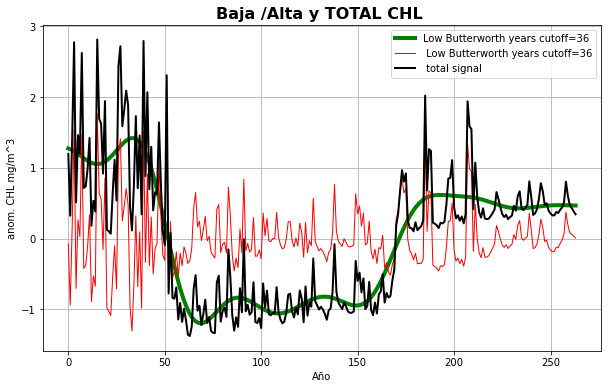

In [776]:
nyc=36
n=10
Wn=1/18
b,a=signal.butter(n, Wn, btype='low', analog=False, output='ba', fs=None)
#Filtro la señal ampliada y me quedo con la parte central:
lowchl = signal.filtfilt(b,a,PCchl)

b,a=signal.butter(n, Wn, btype='high', analog=False, output='ba', fs=None)
#Filtro la señal ampliada y me quedo con la parte central:
high = signal.filtfilt(b,a,PCchl)

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title('Baja /Alta y TOTAL CHL ',fontsize=16,weight='bold')
ax.set_xlabel('Año')
ax.set_ylabel('anom. CHL mg/m^3')
ax.plot(np.arange(nt),lowchl,linewidth= 4,color='green',label='Low Butterworth years cutoff='+str(nyc))
ax.plot(np.arange(nt),high,linewidth= 1,color='red',label=' Low Butterworth years cutoff='+str(nyc))
ax.plot(np.arange(nt),PCchl,linewidth= 2,color='black',label=' total signal')

ax.legend()
ax.grid()

In [777]:
seasons, trend = fit_seasons(lowazm)
trendPCcc=trend
seasons, trend = fit_seasons(lowamm)
trendPCci=trend
seasons, trend = fit_seasons(lowchl)
trendPCchlo=trend

Text(0.5, 1.0, 'ECs de Clorofila Y 2 PRIMERAS EOFS SST Butterworth')

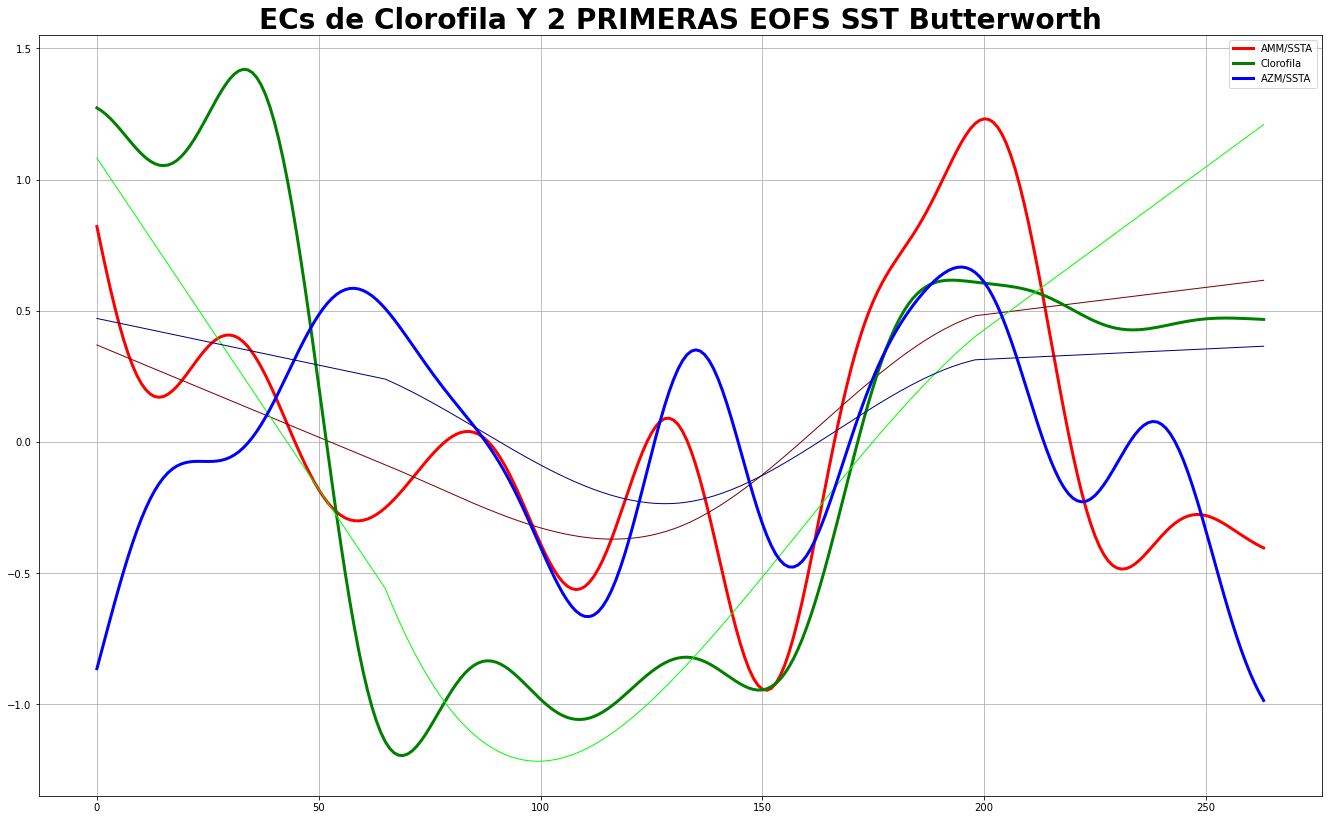

In [778]:
fig,ax=plt.subplots(1, 1, sharex=False,figsize=(23,14))
ax.plot(np.arange(nt),(lowamm),linewidth= 3,color='red',label='AMM/SSTA')
ax.plot(np.arange(nt),(trendPCci),linewidth= 1,color='maroon')
ax.plot(np.arange(nt),(lowchl),linewidth= 3,color='green',label='Clorofila')
ax.plot(np.arange(nt),(trendPCchl),linewidth= 1,color='lime')
ax.plot(np.arange(nt),(lowazm),linewidth= 3,color='blue',label='AZM/SSTA')
ax.plot(np.arange(nt),(trendPCcc),linewidth= 1,color='navy')
ax.grid()
ax.legend()
ax.set_title('ECs de Clorofila Y 2 PRIMERAS EOFS SST Butterworth',fontsize=28,weight='bold')

Text(0.5, 1.0, 'Correlación Cruzada con ambos modos SST ')

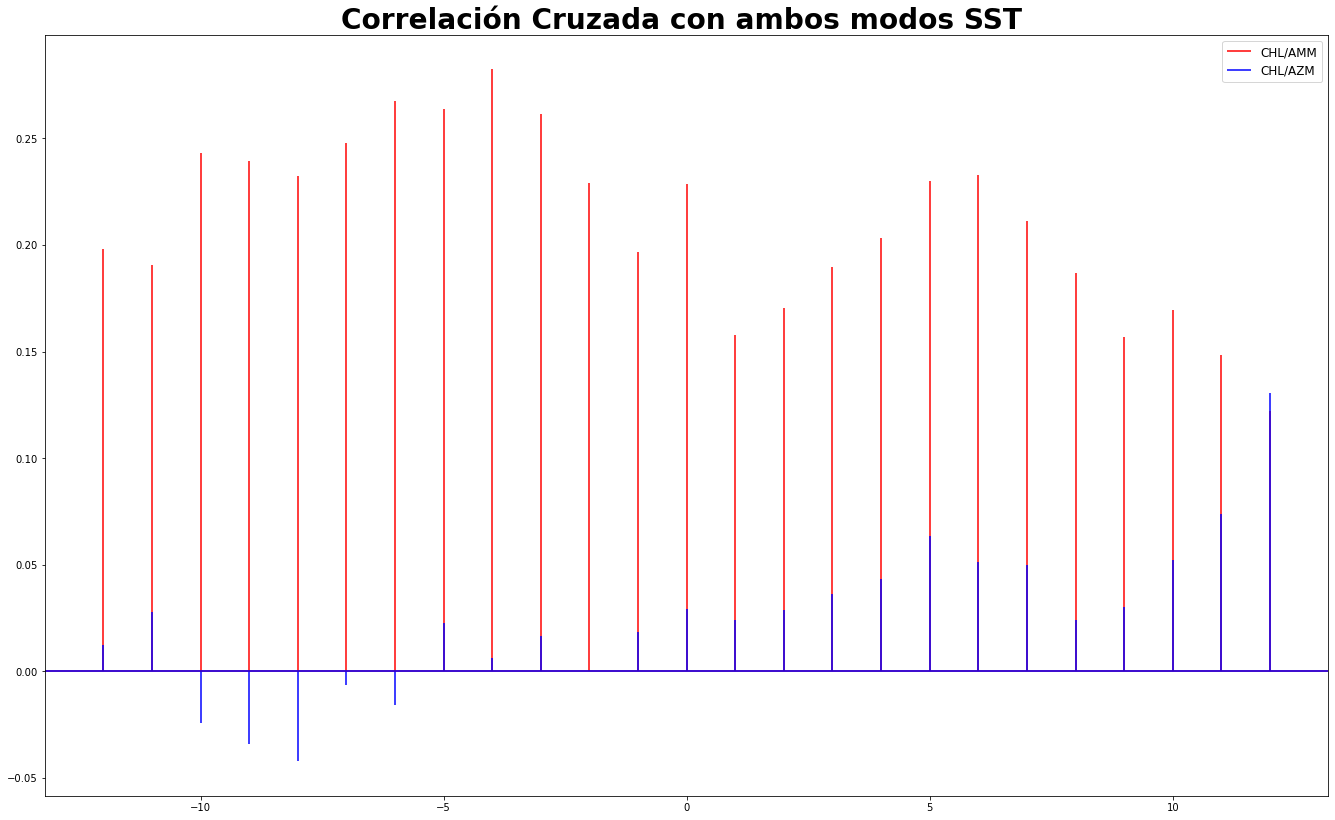

In [779]:
plt.figure(figsize=(23,14))
plt.xcorr(PCci,PCchl,maxlags=12,color='red',label='CHL/AMM')
plt.xcorr(PCcc,PCchl,maxlags=12,color='blue',label='CHL/AZM')

plt.grid()
plt.grid()
plt.legend(fontsize=12)
plt.title('Correlación Cruzada con ambos modos SST ', fontsize=28, weight='bold')
   

Text(0.5, 1.0, 'Autocorrelación CHL')

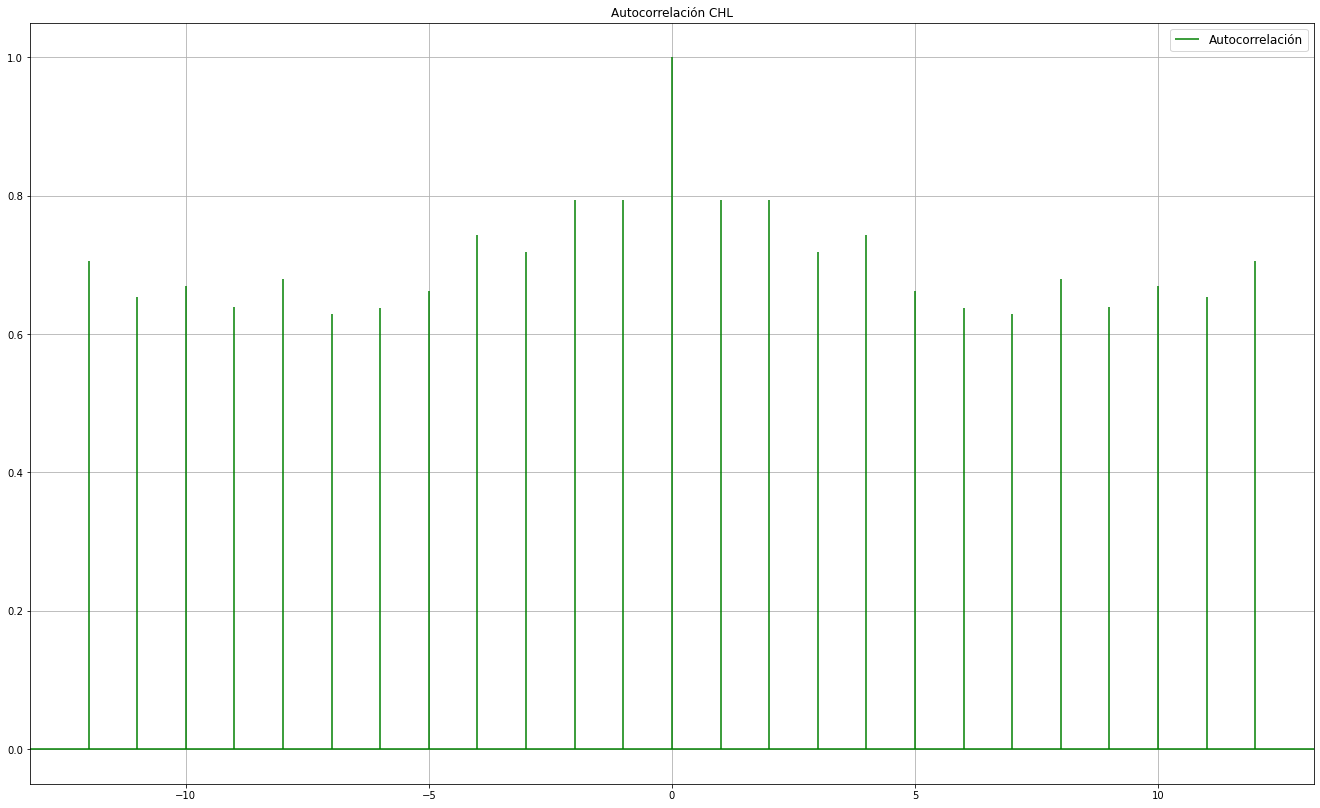

In [780]:
       
          
plt.figure(figsize=(23,14))
plt.xcorr(PCchl,PCchl,maxlags=12,color='green',label='Autocorrelación')
plt.grid()
plt.legend(fontsize=12)
plt.title('Autocorrelación CHL')

<ipython-input-781-229452e526fc>:31: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(np.cumsum(scf[:50]),color='Blue',Marker='o',label='Evolucion de covarianzas cuadradas')
C:\Users\Miguel\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Correlación entre ambas variables CHL1
(0.3755139918323069, 0.0024238447316849614)
(-0.19886824259363525, 0.11816773746507245)
Correlación entre ambas variables CHL2
(-0.11187121793705579, 0.3827101202478607)
(0.20876953090776867, 0.10058519862424499)


Text(0.5, 1.0, 'PRIMAVERA EC4')

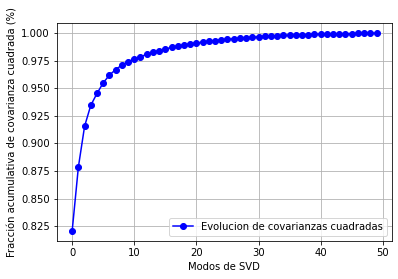

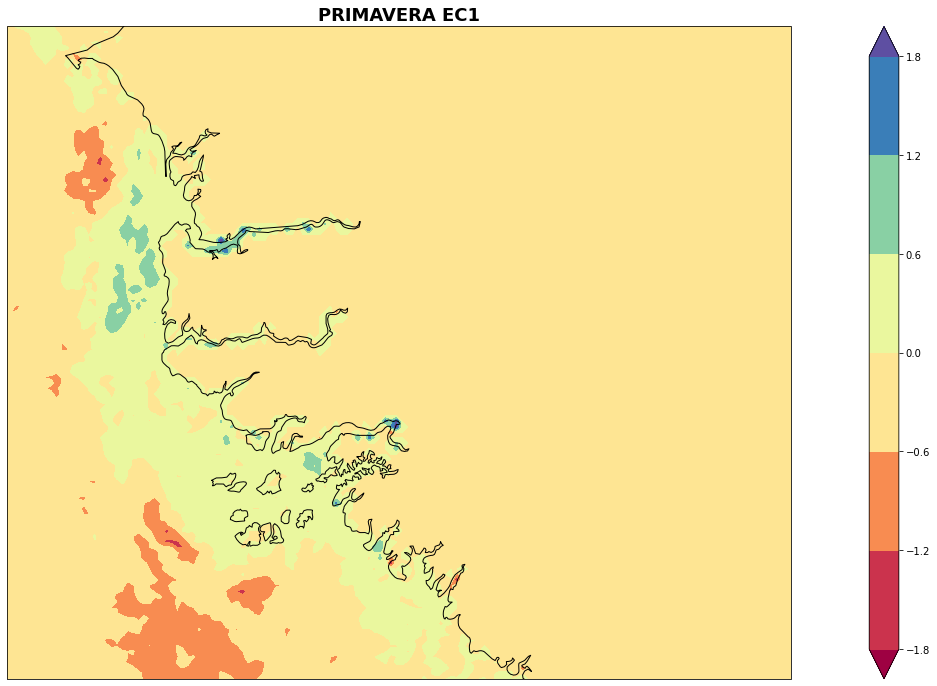

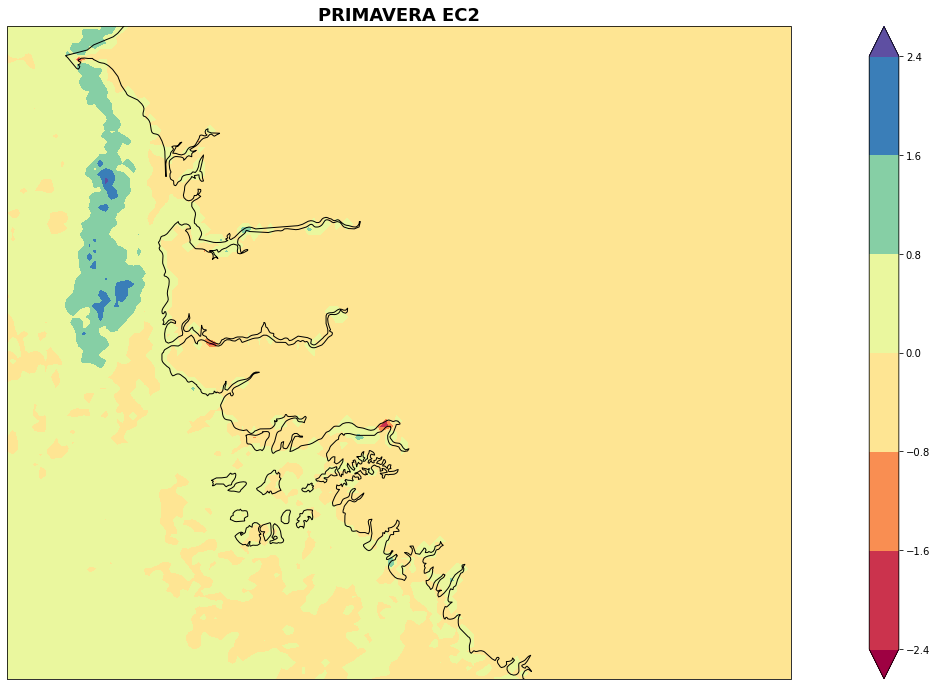

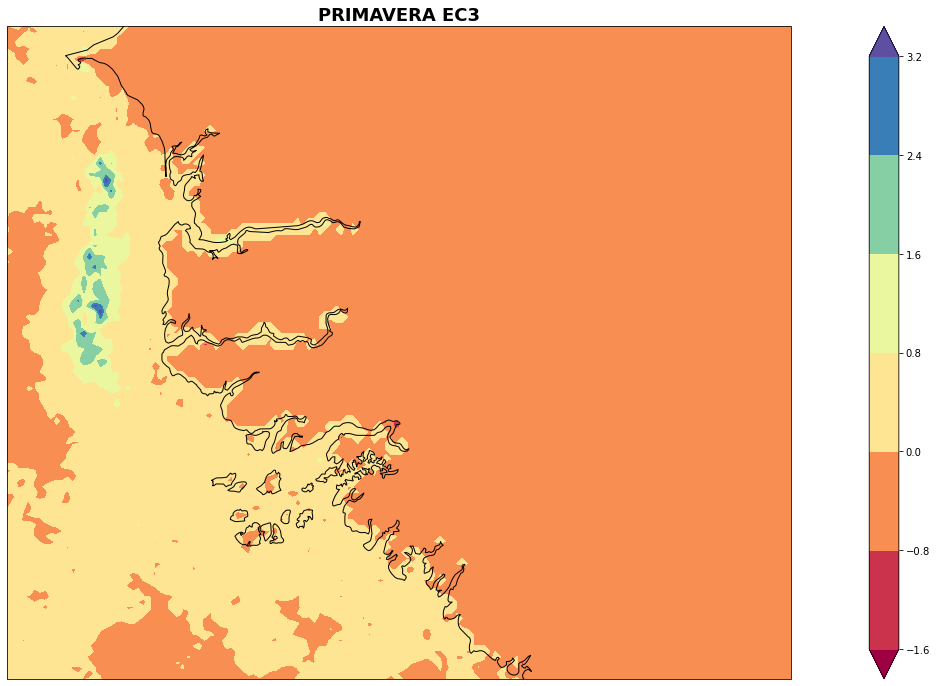

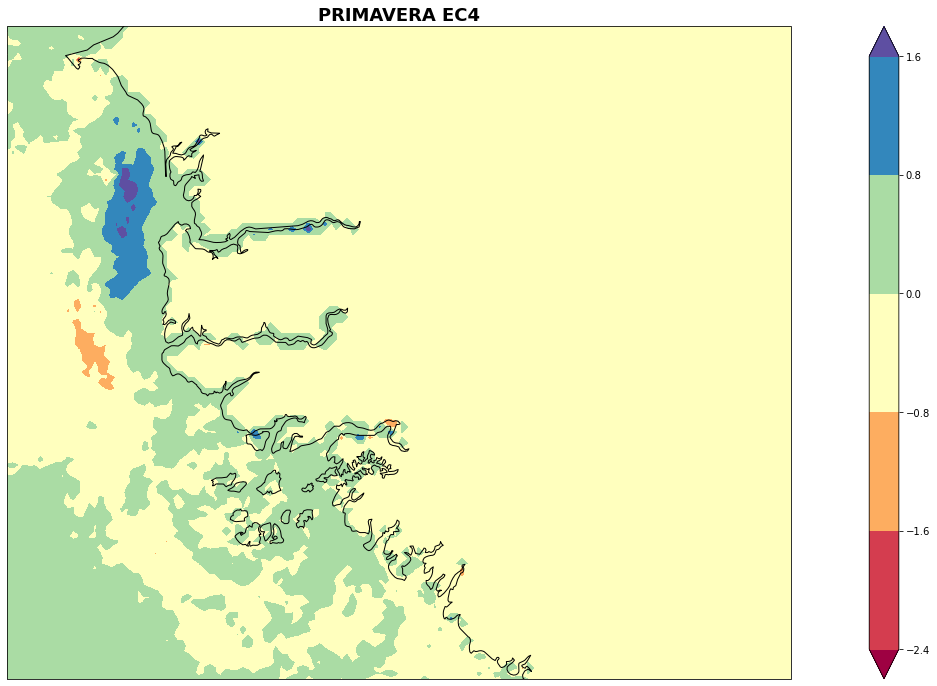

In [781]:
nm=3
nyears=21
nt=nm*nyears

nm=3
nyears=21
nt=nm*nyears
#CH_pri=CH_pri
C=np.dot(np.transpose(CH_pri),AT_pri)
C.shape

eof,d,eof2=linalg.svd(C,0)

scf=np.power(d,2)/sum(np.power(d,2))
sum(scf[:3])






PC=np.dot(CH_pri,eof[:,:5])

PCs=(PC-np.mean(PC,0))/np.std(PC,0)
PCs.shape

PC=np.dot(AT_pri,eof2[:,:5])
PCss=(PC-np.mean(PC,0))/np.std(PC,0)
PCss.shape
fig,ax = plt.subplots()
plt.plot(np.cumsum(scf[:50]),color='Blue',Marker='o',label='Evolucion de covarianzas cuadradas')
ax.set_xlabel('Modos de SVD')
ax.set_ylabel('Fracción acumulativa de covarianza cuadrada (%)')
plt.legend()
plt.grid()

print('Correlación entre ambas variables CHL1')
print(pearsonr(PCss[:,0],PCs[:,0]))
print(pearsonr(PCss[:,0],PCs[:,1]))
print('Correlación entre ambas variables CHL2')
print(pearsonr(PCss[:,1],PCs[:,0]))
print(pearsonr(PCss[:,1],PCs[:,1]))

CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(CH_pri),np.transpose(PCs[:,0]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,regEOF.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('PRIMAVERA EC1',fontsize=18,weight='bold')


CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(CH_pri),np.transpose(PCs[:,1]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,regEOF.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('PRIMAVERA EC2',fontsize=18,weight='bold')

CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(CH_pri),np.transpose(PCs[:,2]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,regEOF.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('PRIMAVERA EC3',fontsize=18,weight='bold')


CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(CH_pri),np.transpose(PCs[:,3]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,regEOF.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('PRIMAVERA EC4',fontsize=18,weight='bold')

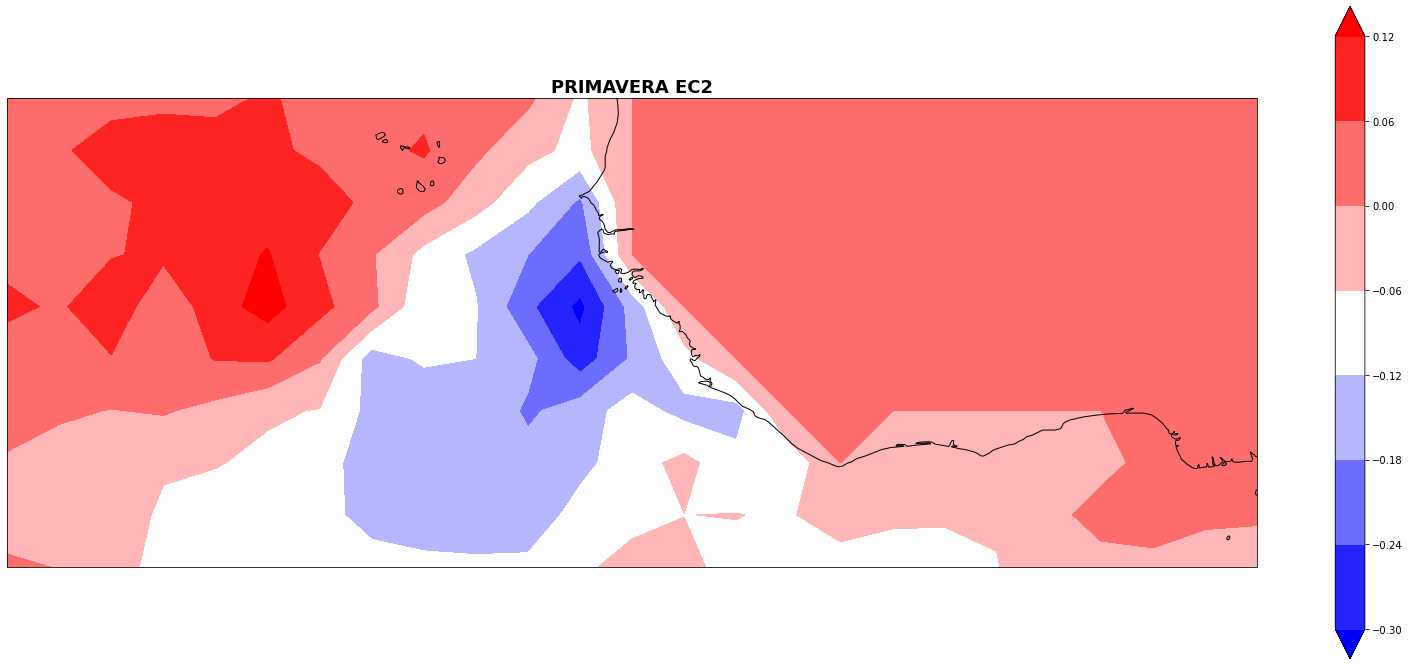

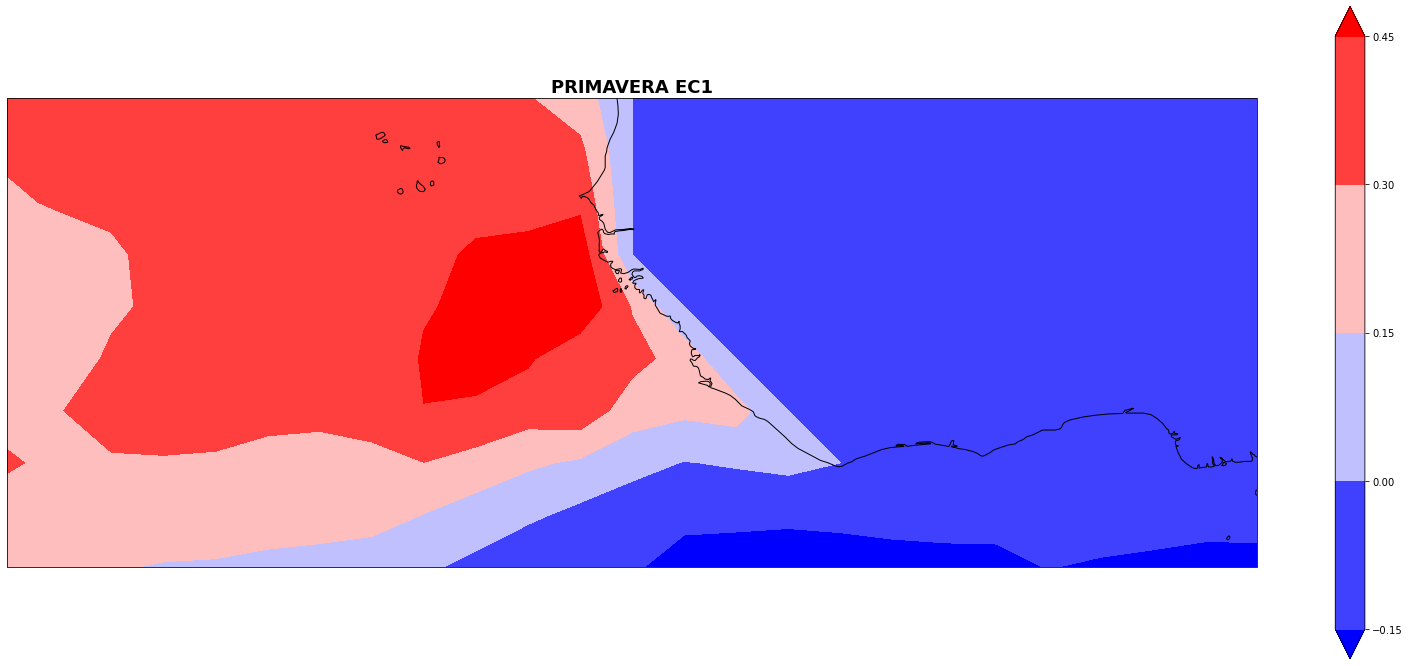

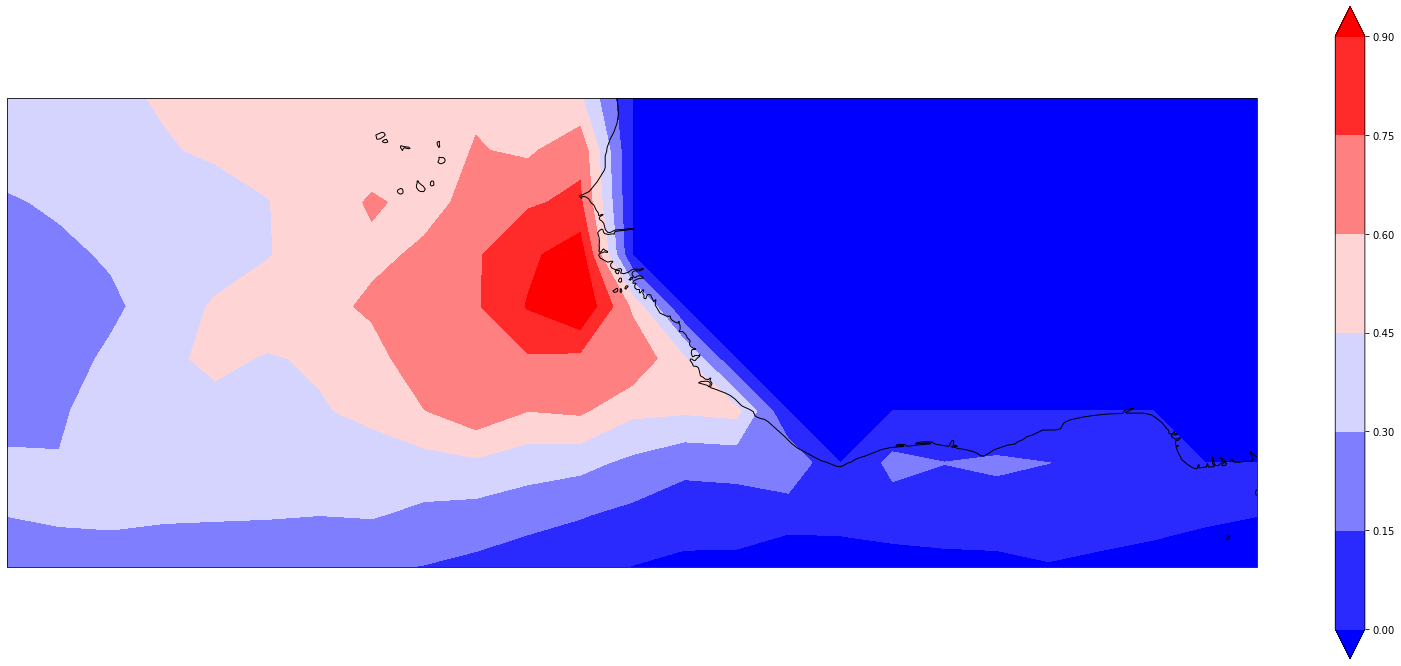

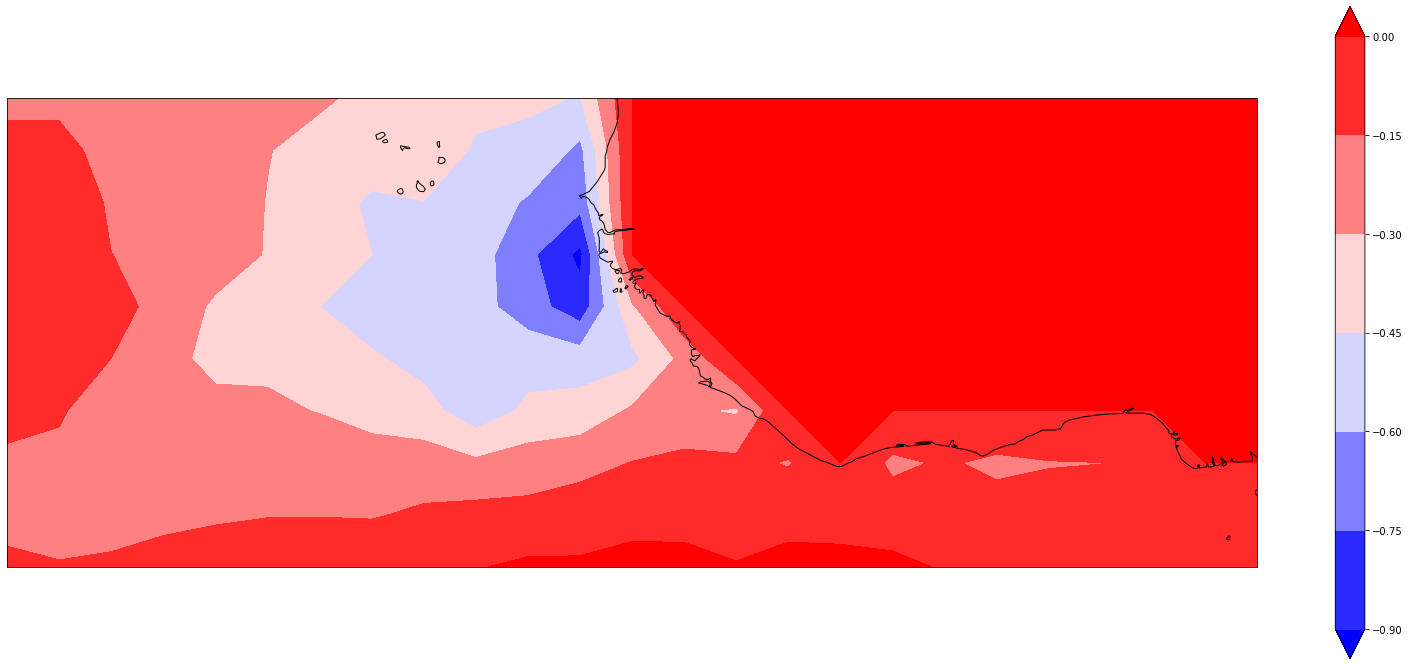

In [782]:
CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT_pri),np.transpose(PCss[:,1]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('PRIMAVERA EC2',fontsize=18,weight='bold')

CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT_pri),np.transpose(PCss[:,0]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('PRIMAVERA EC1',fontsize=18,weight='bold')

CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT_pri),np.transpose(PCss[:,3]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores

CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT_pri),np.transpose(PCss[:,2]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores

<ipython-input-783-2db2d6e0c2e5>:37: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(np.cumsum(scf[:50]),color='Blue',Marker='o',label='Evolucion de covarianzas cuadradas')
C:\Users\Miguel\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Correlación entre ambas variables CHL1
(-0.03665980003657857, 0.7754547599005863)
(0.5548282849333818, 2.373526005839988e-06)
Correlación entre ambas variables CHL2
(-0.23865475983722187, 0.0596125287266353)
(-0.27542297330098736, 0.02890559312757785)


Text(0.5, 1.0, 'VERANO EC4')

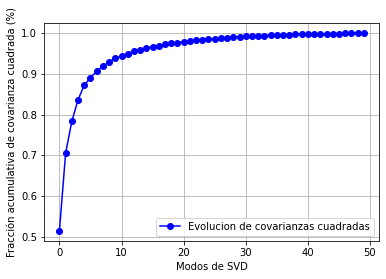

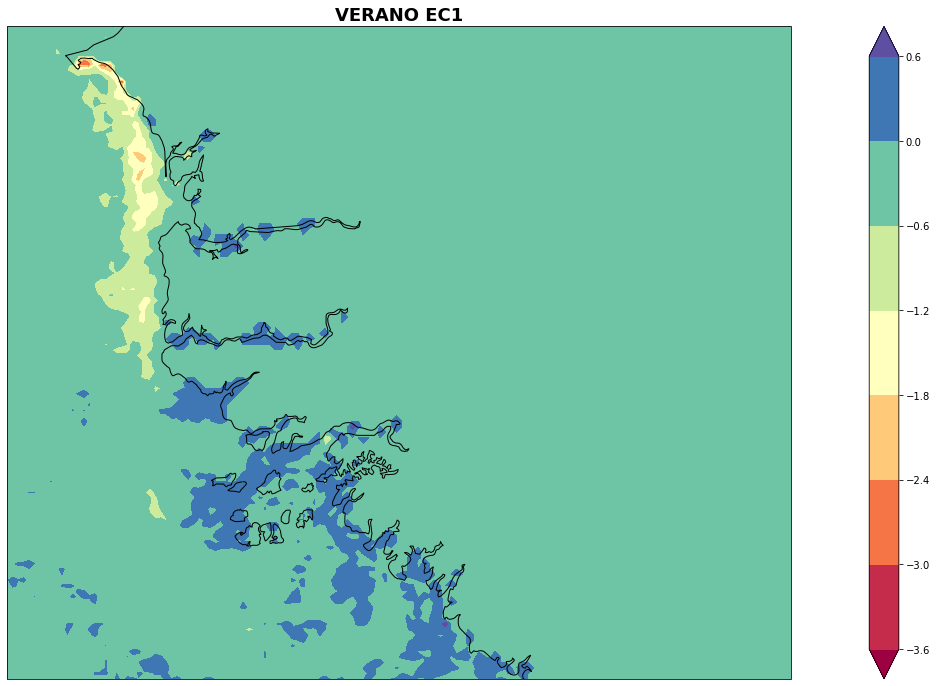

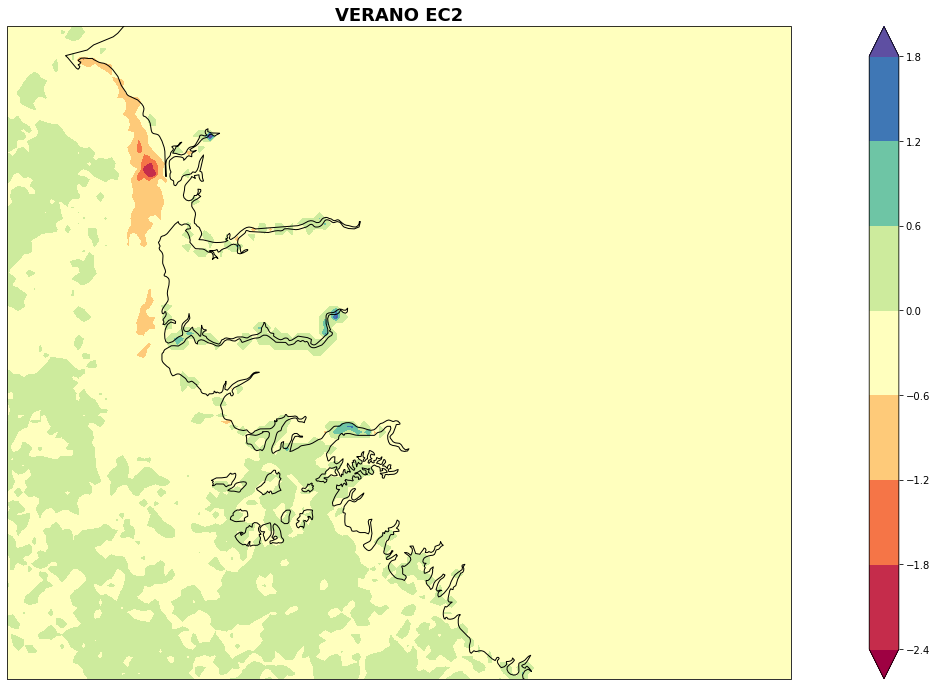

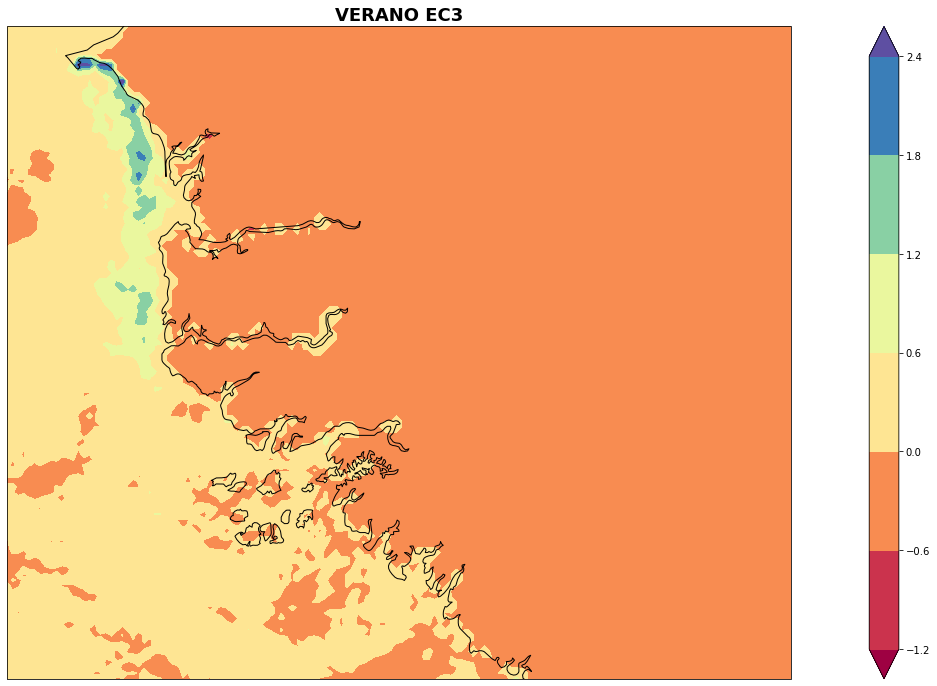

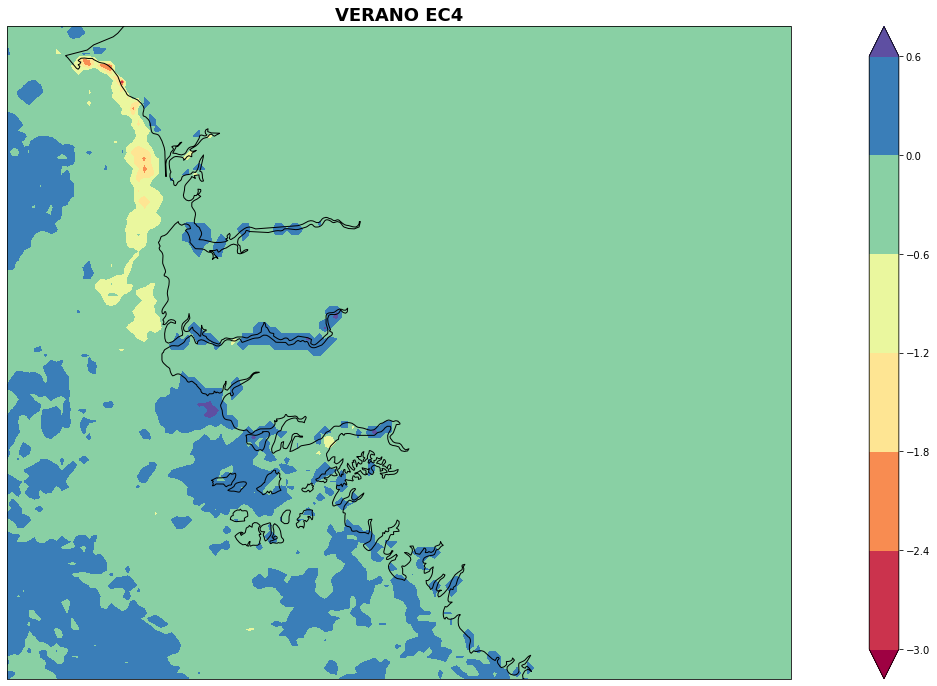

In [783]:
######AQUÍ ESTÁ LA OTRA PARTE PARA SELECCIONAR ESTACIONES

#### SACO DOS MAPAS POR ESTACIÓN PARA PODER VISUALIZAR LOS FENÓMENOS DE NIÑO Y NIÑA

#LA REGEOF ME PINT

nm=3
nyears=21
nt=nm*nyears

nm=3
nyears=21
nt=nm*nyears
#CH_ver=CH_pri
C=np.dot(np.transpose(CH_ver),AT_ver)
C.shape

eof,d,eof2=linalg.svd(C,0)

scf=np.power(d,2)/sum(np.power(d,2))
sum(scf[:3])






PC=np.dot(CH_ver,eof[:,:5])

PCs=(PC-np.mean(PC,0))/np.std(PC,0)
PCs.shape

PC=np.dot(AT_ver,eof2[:,:5])
PCss=(PC-np.mean(PC,0))/np.std(PC,0)
PCss.shape
fig,ax = plt.subplots()
plt.plot(np.cumsum(scf[:50]),color='Blue',Marker='o',label='Evolucion de covarianzas cuadradas')
ax.set_xlabel('Modos de SVD')
ax.set_ylabel('Fracción acumulativa de covarianza cuadrada (%)')
plt.legend()
plt.grid()

print('Correlación entre ambas variables CHL1')
print(pearsonr(PCss[:,0],PCs[:,0]))
print(pearsonr(PCss[:,0],PCs[:,1]))
print('Correlación entre ambas variables CHL2')
print(pearsonr(PCss[:,1],PCs[:,0]))
print(pearsonr(PCss[:,1],PCs[:,1]))

CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(CH_ver),np.transpose(PCs[:,0]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,regEOF.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('VERANO EC1',fontsize=18,weight='bold')


CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(CH_ver),np.transpose(PCs[:,1]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,regEOF.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('VERANO EC2',fontsize=18,weight='bold')

CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(CH_ver),np.transpose(PCs[:,2]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,regEOF.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('VERANO EC3',fontsize=18,weight='bold')

CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(CH_ver),np.transpose(PCs[:,3]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,regEOF.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('VERANO EC4',fontsize=18,weight='bold')

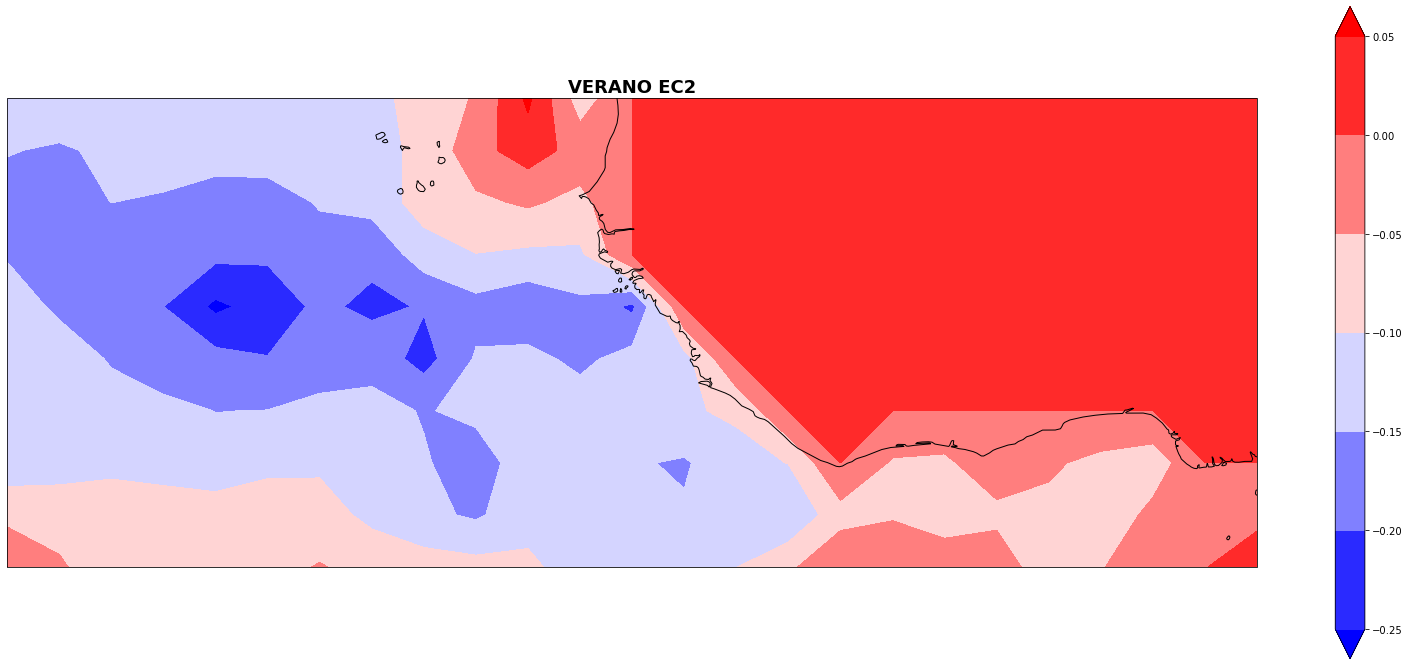

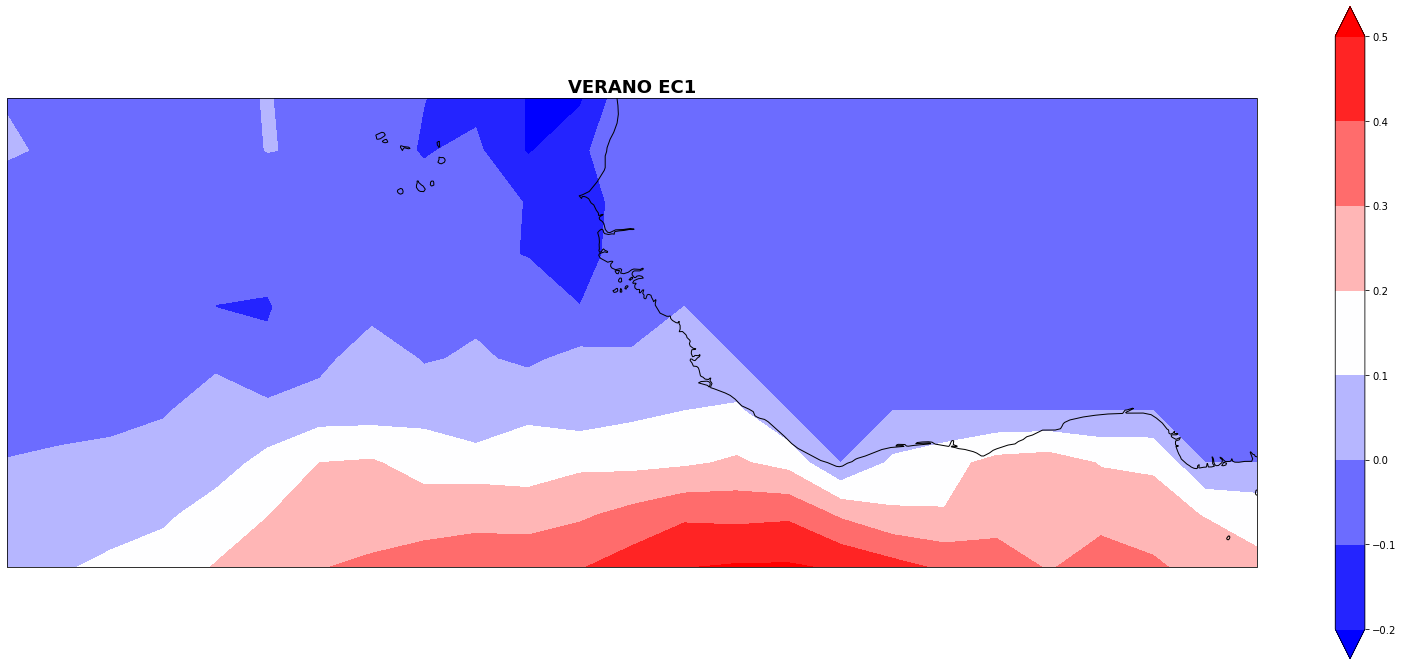

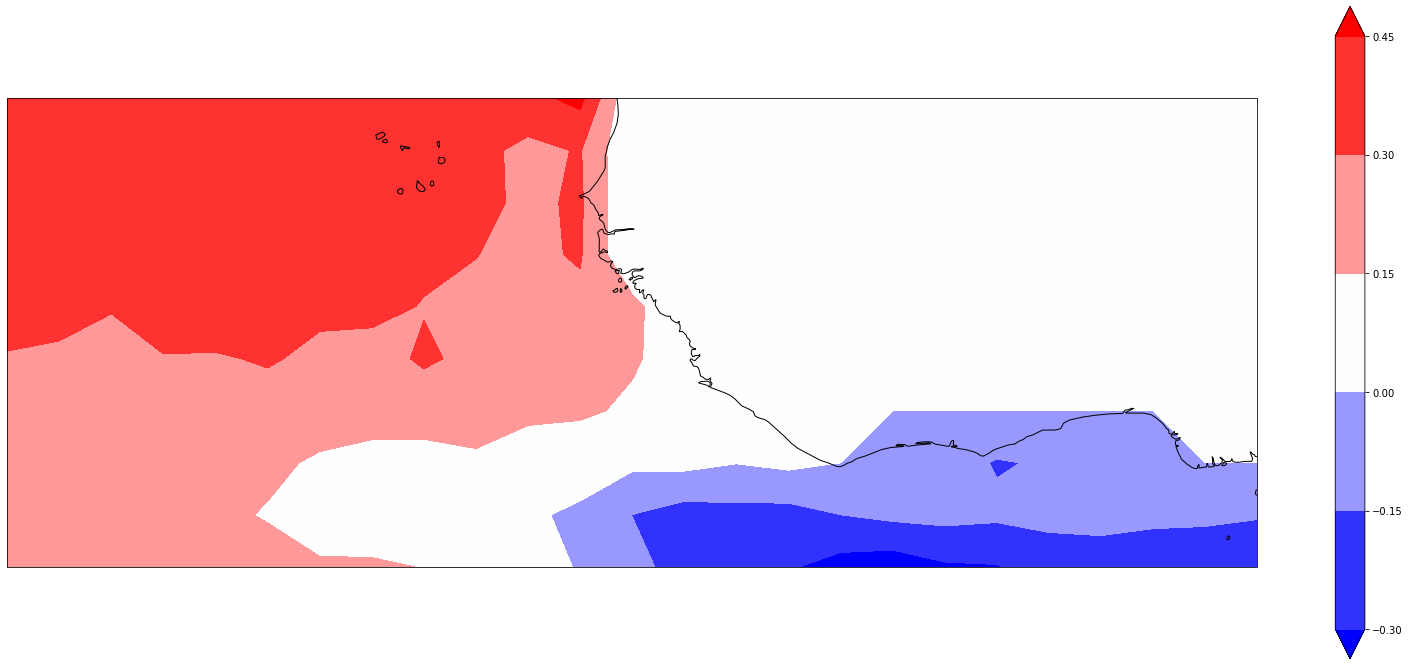

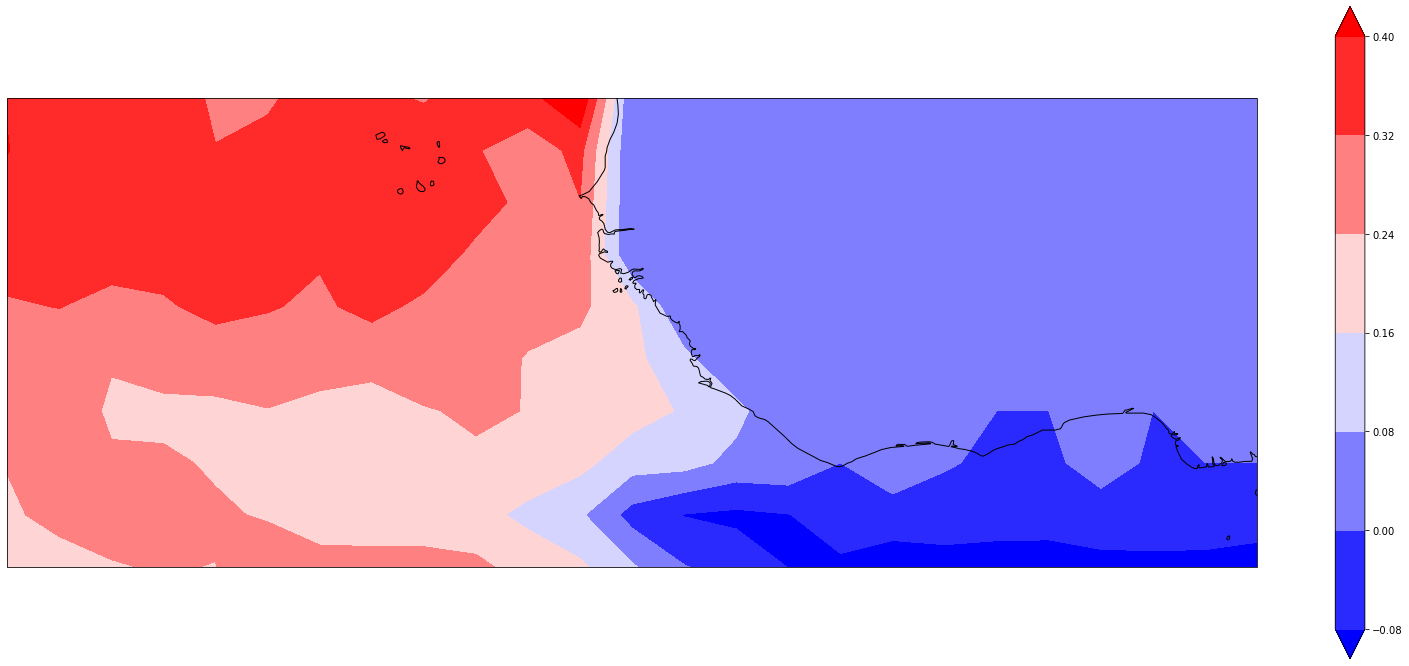

In [784]:
CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT_ver),np.transpose(PCss[:,1]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('VERANO EC2',fontsize=18,weight='bold')

CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT_ver),np.transpose(PCss[:,0]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('VERANO EC1',fontsize=18,weight='bold')

CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT_ver),np.transpose(PCss[:,3]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores

CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT_ver),np.transpose(PCss[:,2]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores

<ipython-input-785-3ef99e8b9cc6>:31: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(np.cumsum(scf[:50]),color='Blue',Marker='o',label='Evolucion de covarianzas cuadradas')
C:\Users\Miguel\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Correlación entre ambas variables CHL1
(0.2754032736074528, 0.028917523508850122)
(-0.289789558217184, 0.02123682616083086)
Correlación entre ambas variables CHL2
(-0.5575804171688197, 2.0640358935910534e-06)
(0.37750507027959945, 0.0022878814101098275)


Text(0.5, 1.0, 'OTOÑO EC2')

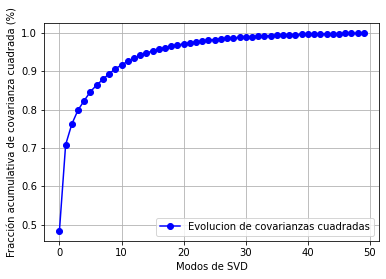

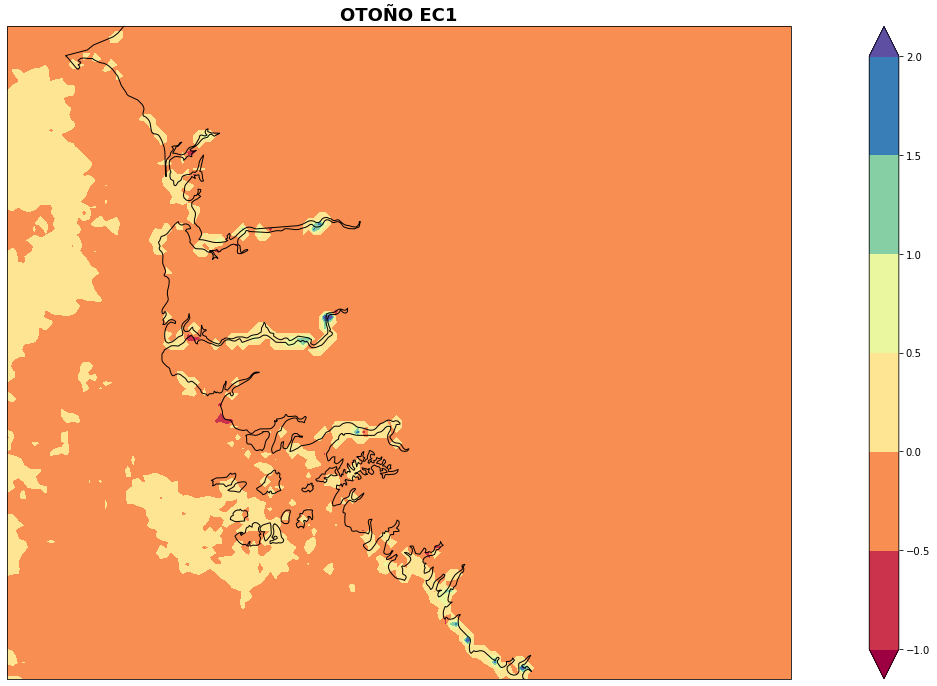

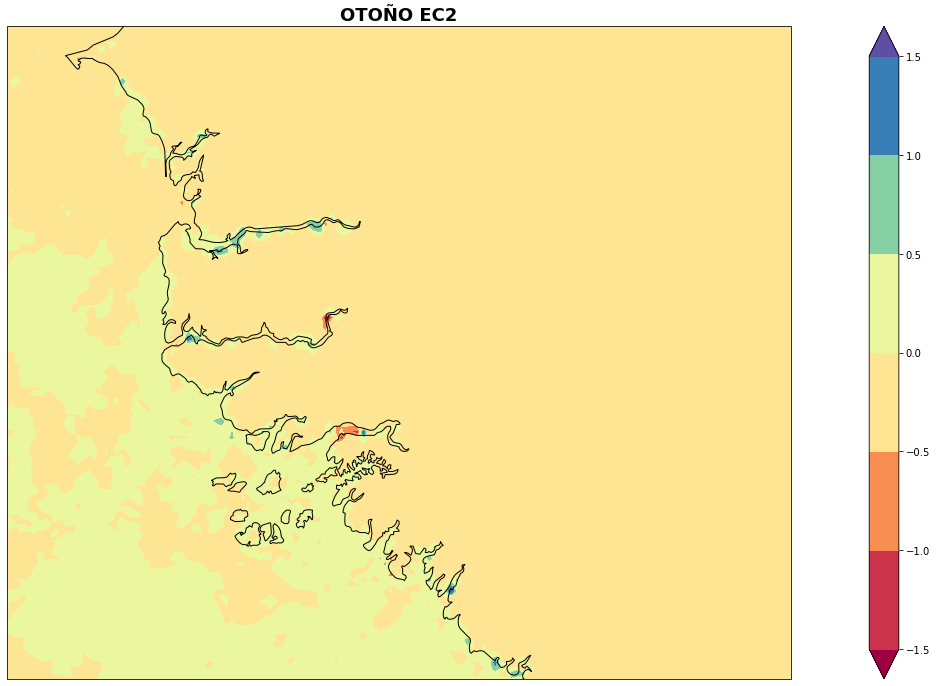

In [785]:
nm=3
nyears=21
nt=nm*nyears

nm=3
nyears=21
nt=nm*nyears
#CH_oto=CH_pri
C=np.dot(np.transpose(CH_oto),AT_oto)
C.shape

eof,d,eof2=linalg.svd(C,0)

scf=np.power(d,2)/sum(np.power(d,2))
sum(scf[:3])






PC=np.dot(CH_oto,eof[:,:5])

PCs=(PC-np.mean(PC,0))/np.std(PC,0)
PCs.shape

PC=np.dot(AT_oto,eof2[:,:5])
PCss=(PC-np.mean(PC,0))/np.std(PC,0)
PCss.shape
fig,ax = plt.subplots()
plt.plot(np.cumsum(scf[:50]),color='Blue',Marker='o',label='Evolucion de covarianzas cuadradas')
ax.set_xlabel('Modos de SVD')
ax.set_ylabel('Fracción acumulativa de covarianza cuadrada (%)')
plt.legend()
plt.grid()

print('Correlación entre ambas variables CHL1')
print(pearsonr(PCss[:,0],PCs[:,0]))
print(pearsonr(PCss[:,0],PCs[:,1]))
print('Correlación entre ambas variables CHL2')
print(pearsonr(PCss[:,1],PCs[:,0]))
print(pearsonr(PCss[:,1],PCs[:,1]))



CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(CH_oto),np.transpose(PCs[:,0]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,regEOF.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('OTOÑO EC1',fontsize=18,weight='bold')


CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(CH_oto),np.transpose(PCs[:,1]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,regEOF.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('OTOÑO EC2',fontsize=18,weight='bold')

Text(0.5, 1.0, 'OT EC1')

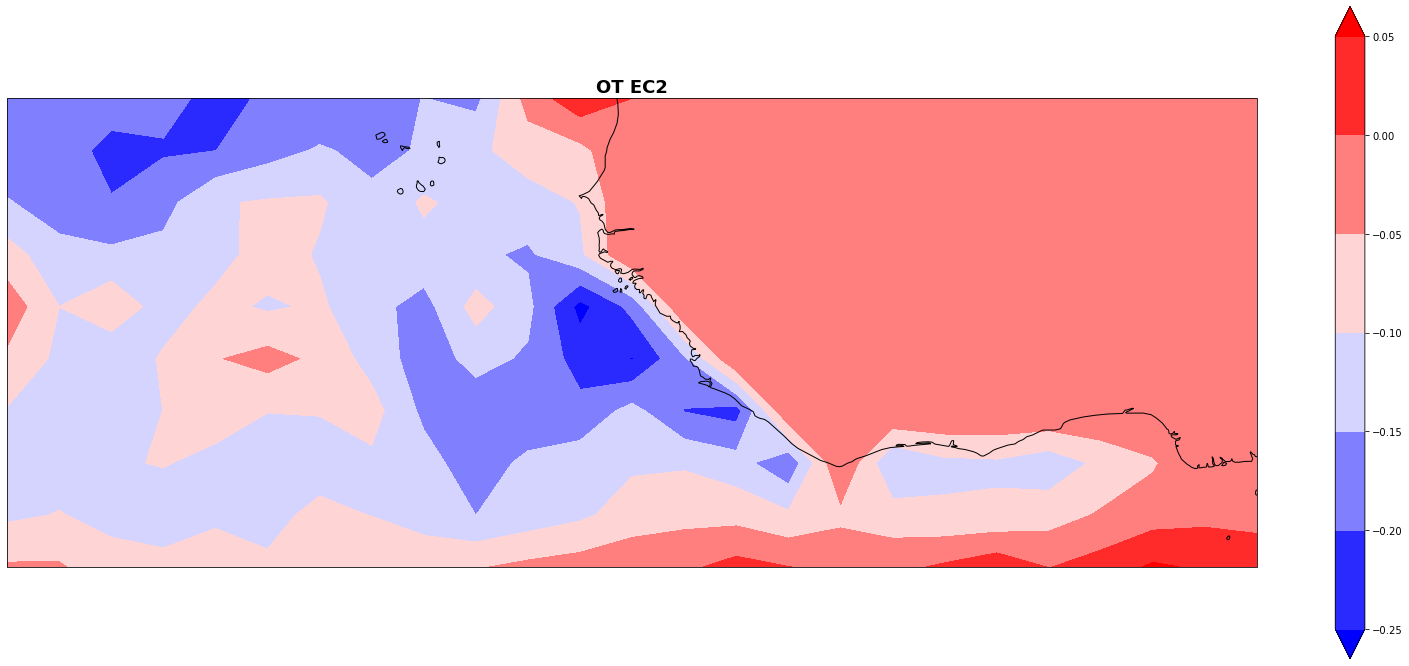

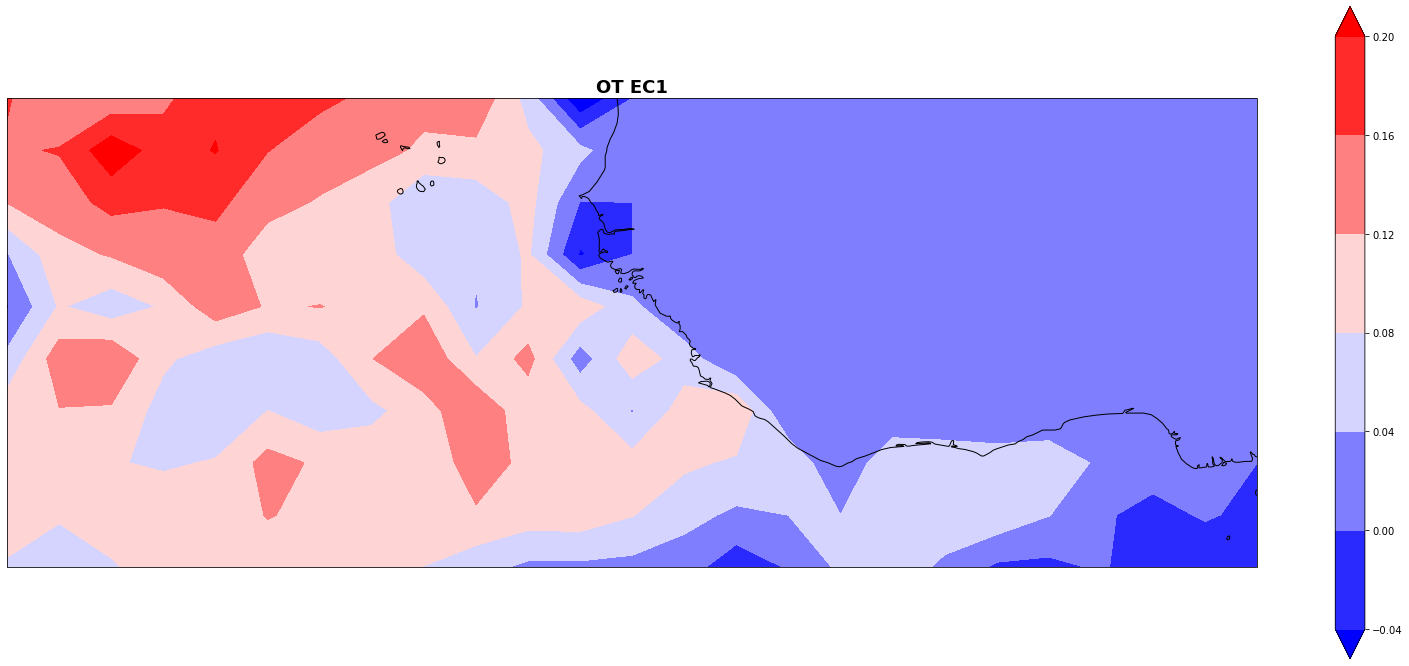

In [786]:

CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT_pri),np.transpose(PCss[:,1]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('OT EC2',fontsize=18,weight='bold')

CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT_pri),np.transpose(PCss[:,0]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('OT EC1',fontsize=18,weight='bold')

<ipython-input-787-af623c876245>:31: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(np.cumsum(scf[:50]),color='Blue',Marker='o',label='Evolucion de covarianzas cuadradas')
C:\Users\Miguel\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Correlación entre ambas variables CHL1
(0.29844178052891024, 0.01751133778372537)
(-0.03836857423280726, 0.765281404871184)
Correlación entre ambas variables CHL2
(0.31659887214670357, 0.011471441706253308)
(0.2205937583808506, 0.08233092228998652)
Correlación entre ambas variables CHL1
(0.34337329548248263, 0.005866076902013153)
(-0.1789229057564865, 0.16059629699978129)
Correlación entre ambas variables CHL2
(0.4640125230145125, 0.00012793330711783688)
(0.17416368453868764, 0.17220324449053973)


Text(0.5, 1.0, 'INVIERNO EC2')

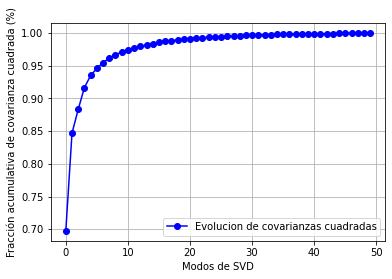

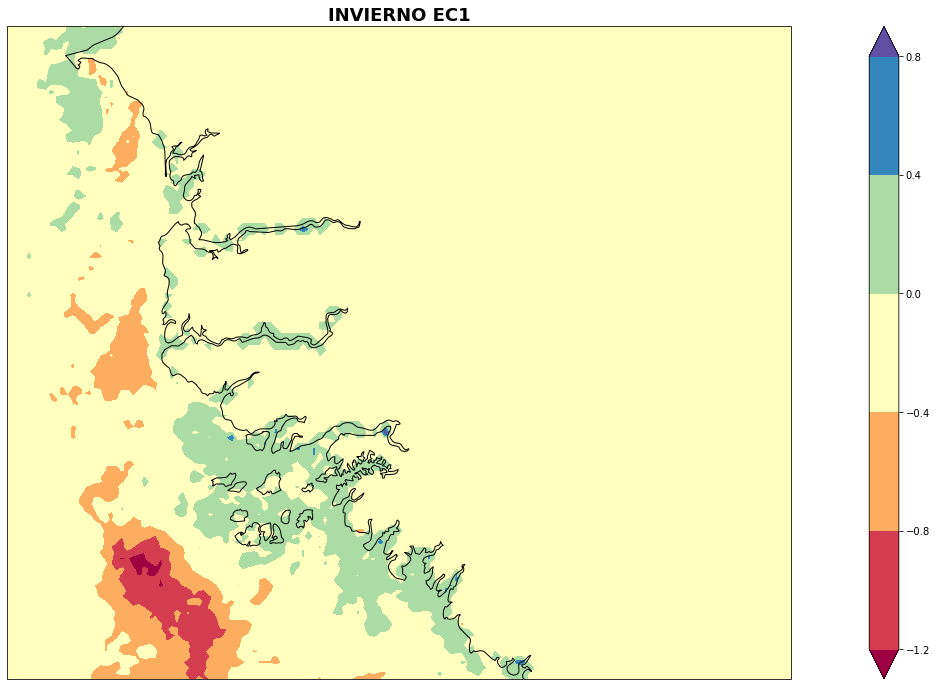

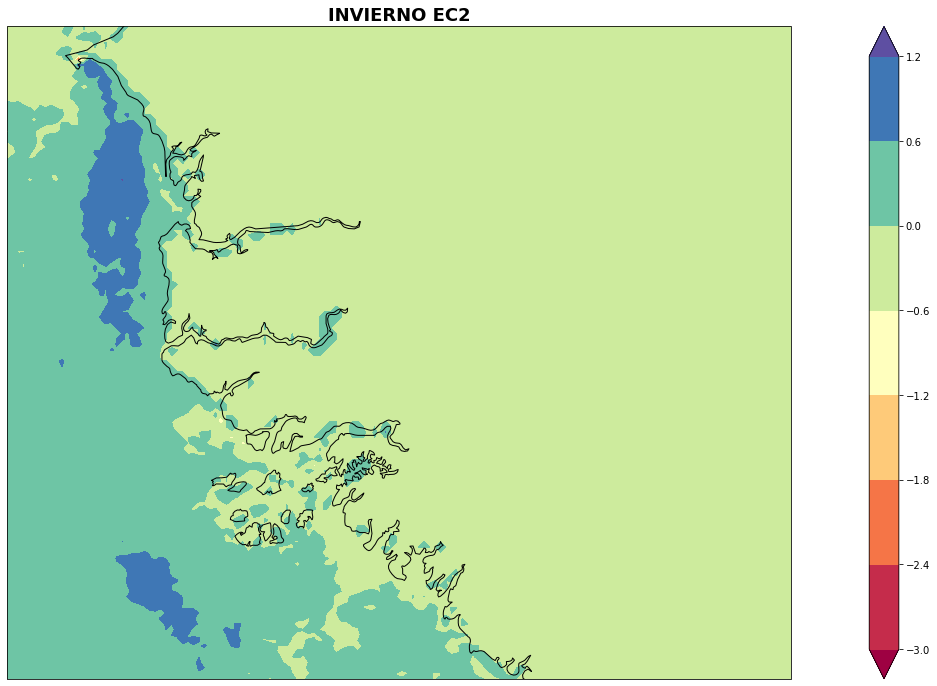

In [787]:
nm=3
nyears=21
nt=nm*nyears

nm=3
nyears=21
nt=nm*nyears
#CH_inv=CH_pri
C=np.dot(np.transpose(CH_inv),AT_inv)
C.shape

eof,d,eof2=linalg.svd(C,0)

scf=np.power(d,2)/sum(np.power(d,2))
sum(scf[:3])






PC=np.dot(CH_inv,eof[:,:5])

PCs=(PC-np.mean(PC,0))/np.std(PC,0)
PCs.shape

PC=np.dot(AT_inv,eof2[:,:5])
PCss=(PC-np.mean(PC,0))/np.std(PC,0)
PCss.shape
fig,ax = plt.subplots()
plt.plot(np.cumsum(scf[:50]),color='Blue',Marker='o',label='Evolucion de covarianzas cuadradas')
ax.set_xlabel('Modos de SVD')
ax.set_ylabel('Fracción acumulativa de covarianza cuadrada (%)')
plt.legend()
plt.grid()

print('Correlación entre ambas variables CHL1')
print(pearsonr(PCss[:,0],PCs[:,0]))
print(pearsonr(PCss[:,0],PCs[:,1]))
print('Correlación entre ambas variables CHL2')
print(pearsonr(PCss[:,1],PCs[:,0]))
print(pearsonr(PCss[:,1],PCs[:,1]))
print('Correlación entre ambas variables CHL1')
print(pearsonr(PCss[:,2],PCs[:,0]))
print(pearsonr(PCss[:,2],PCs[:,1]))
print('Correlación entre ambas variables CHL2')
print(pearsonr(PCss[:,3],PCs[:,0]))
print(pearsonr(PCss[:,3],PCs[:,1]))

CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(CH_inv),np.transpose(PCs[:,0]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,regEOF.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('INVIERNO EC1',fontsize=18,weight='bold')


CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(CH_inv),np.transpose(PCs[:,1]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,regEOF.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('INVIERNO EC2',fontsize=18,weight='bold')

Text(0.5, 1.0, 'INVIERNO EC4')

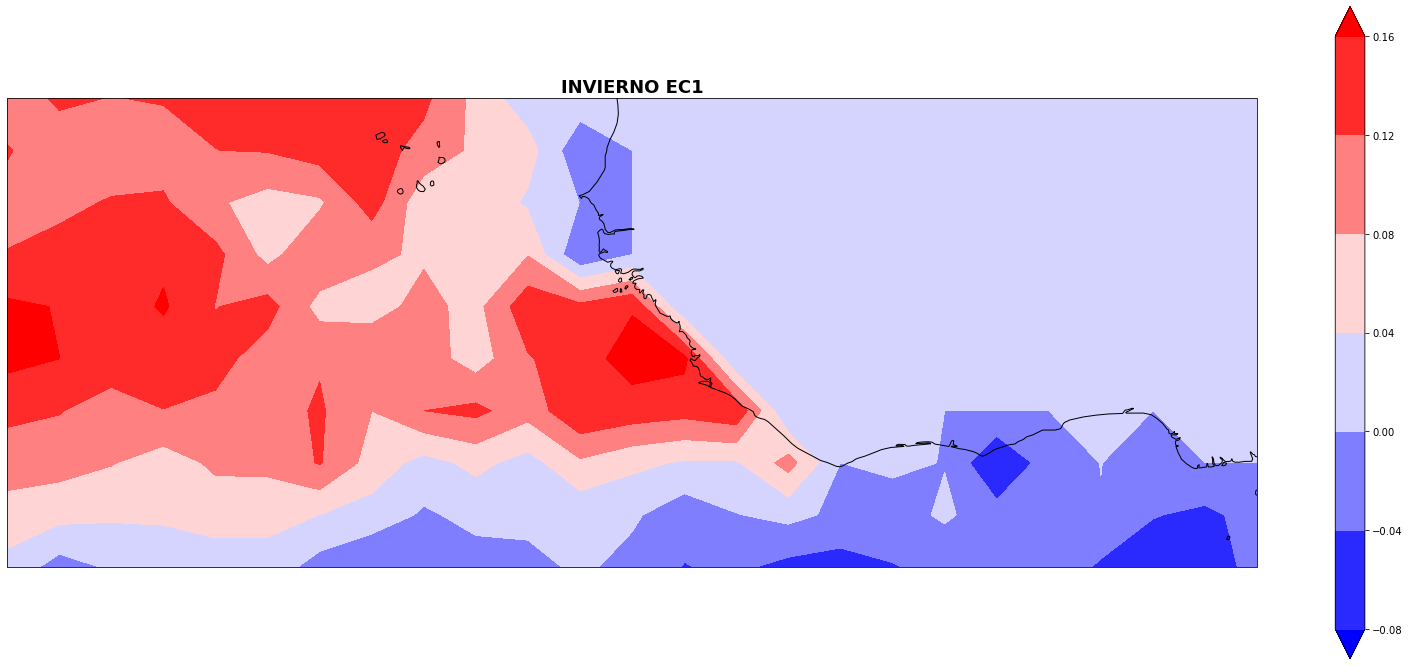

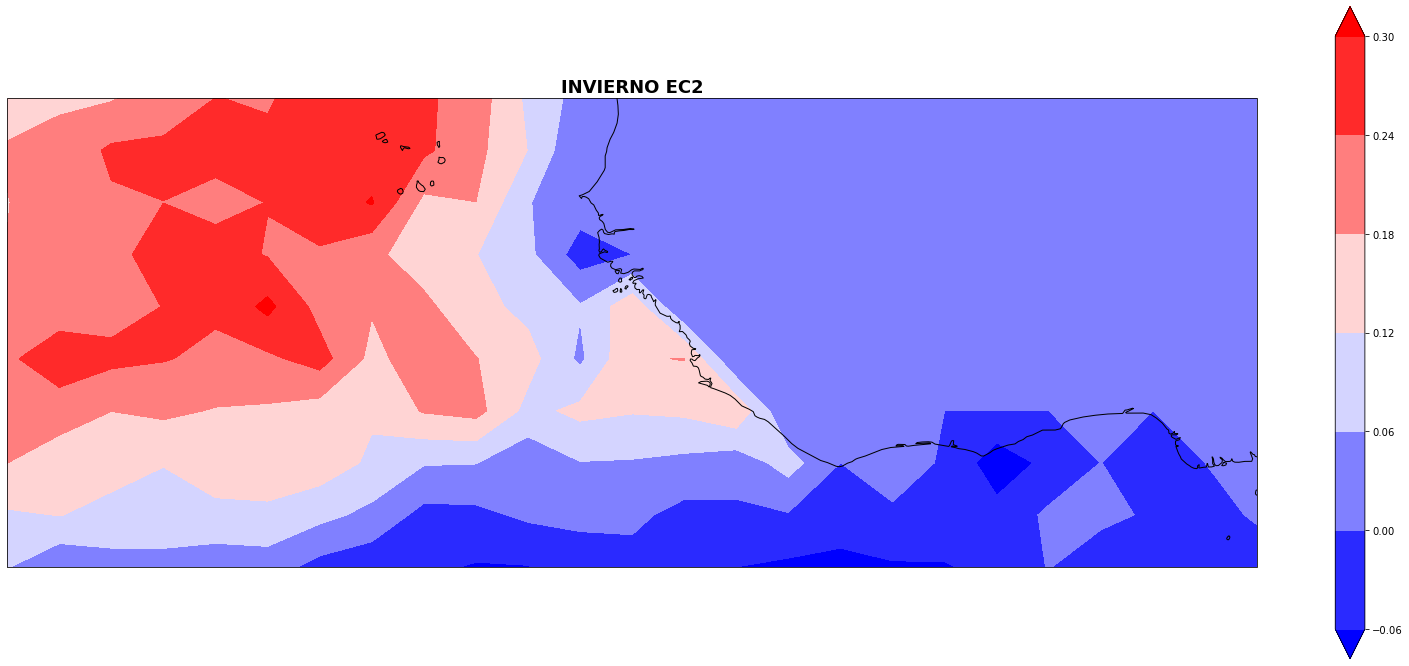

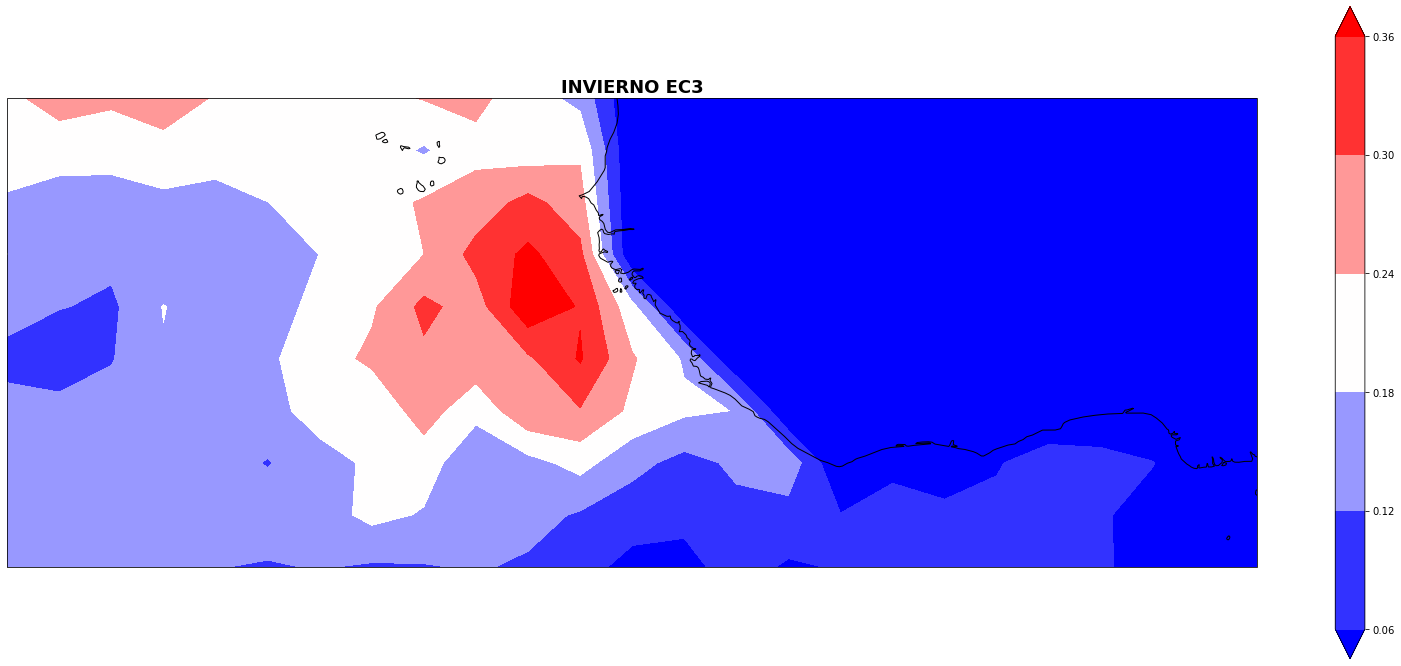

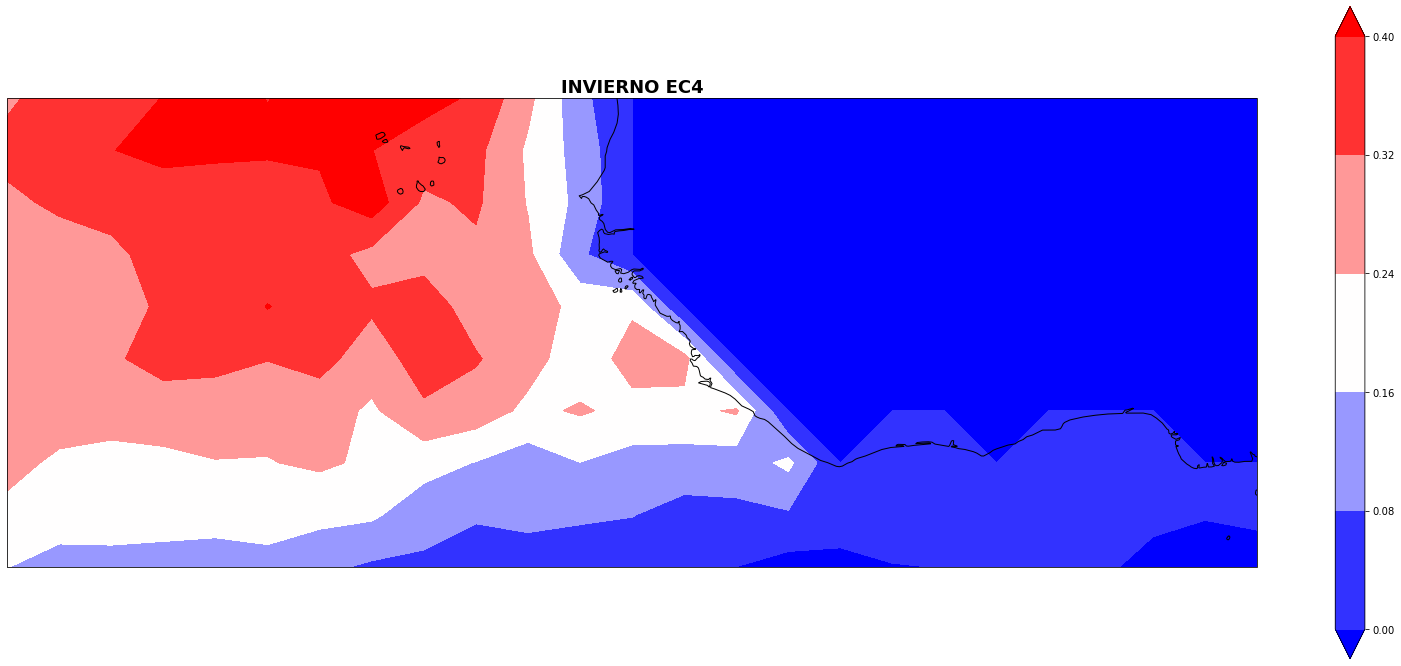

In [788]:
CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT_pri),np.transpose(PCss[:,0]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('INVIERNO EC1',fontsize=18,weight='bold')
CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT_pri),np.transpose(PCss[:,1]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('INVIERNO EC2',fontsize=18,weight='bold')
CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT_pri),np.transpose(PCss[:,2]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('INVIERNO EC3',fontsize=18,weight='bold')
CEOF, sigEOF, CEOF_sig, regEOF, regEOF_sig=IndexRegression(np.transpose(AT_pri),np.transpose(PCss[:,3]),0.01)
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,regEOF.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('INVIERNO EC4',fontsize=18,weight='bold')

In [789]:
#ANALIZO LA CONCENTRACIÓN DE CLOROFILA EN LA PRIMAVERA DE 2009, DONDE SE DIÓ UN FENÓMENO DE NIÑA DAKAR

Text(0.5, 1.0, 'SSTA ENERO 2009 ')

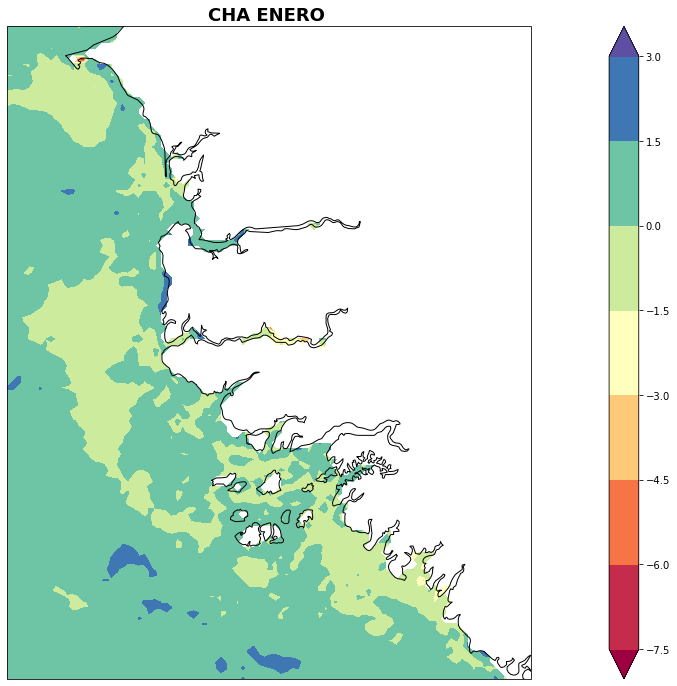

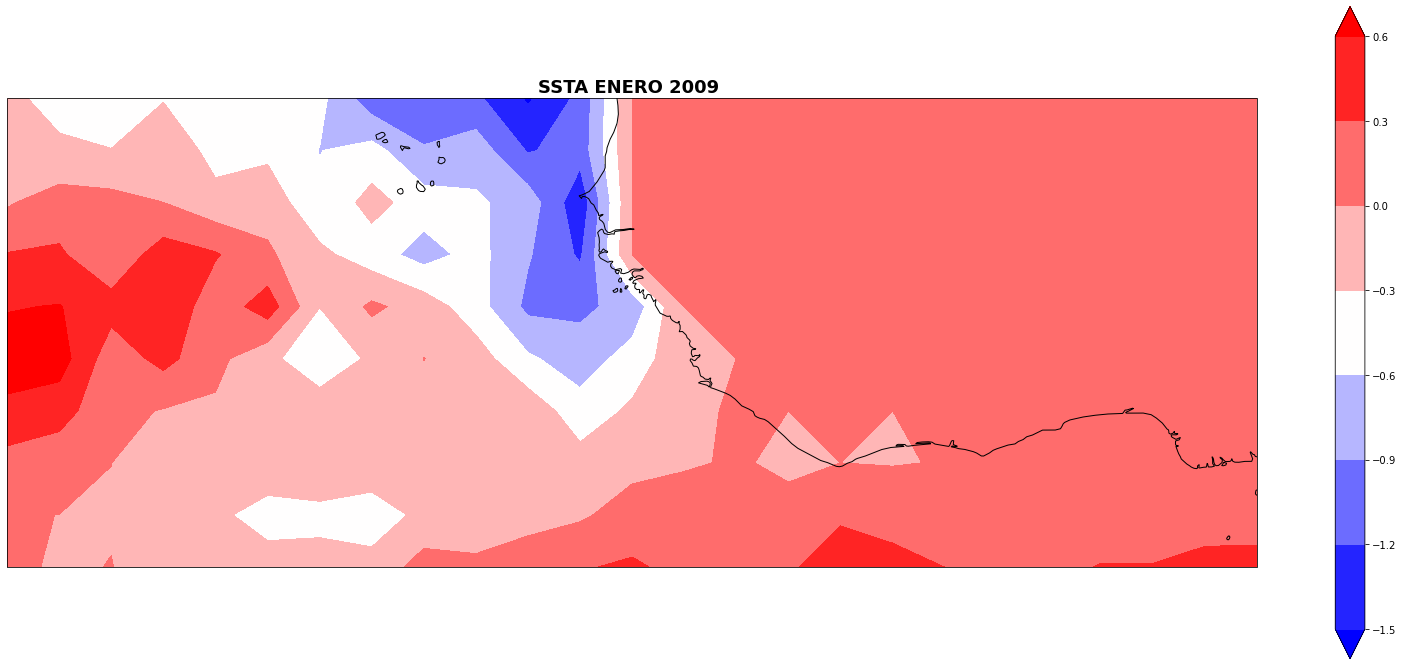

In [790]:
X=CH_e[yrs==2009]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,X.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('CHA ENERO ',fontsize=18,weight='bold')

Y=AT_e[yrs==2009]

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('SSTA ENERO 2009 ',fontsize=18,weight='bold')


Text(0.5, 1.0, 'SSTA FEBRERO 2009 ')

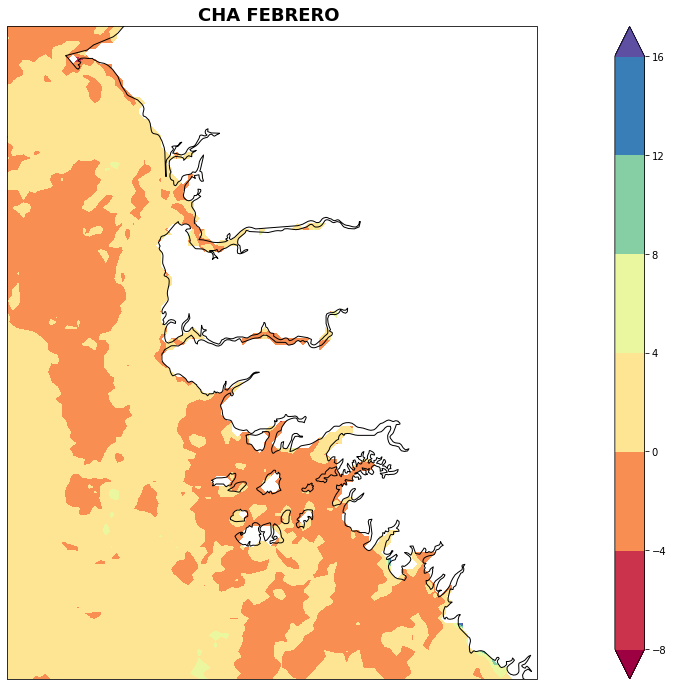

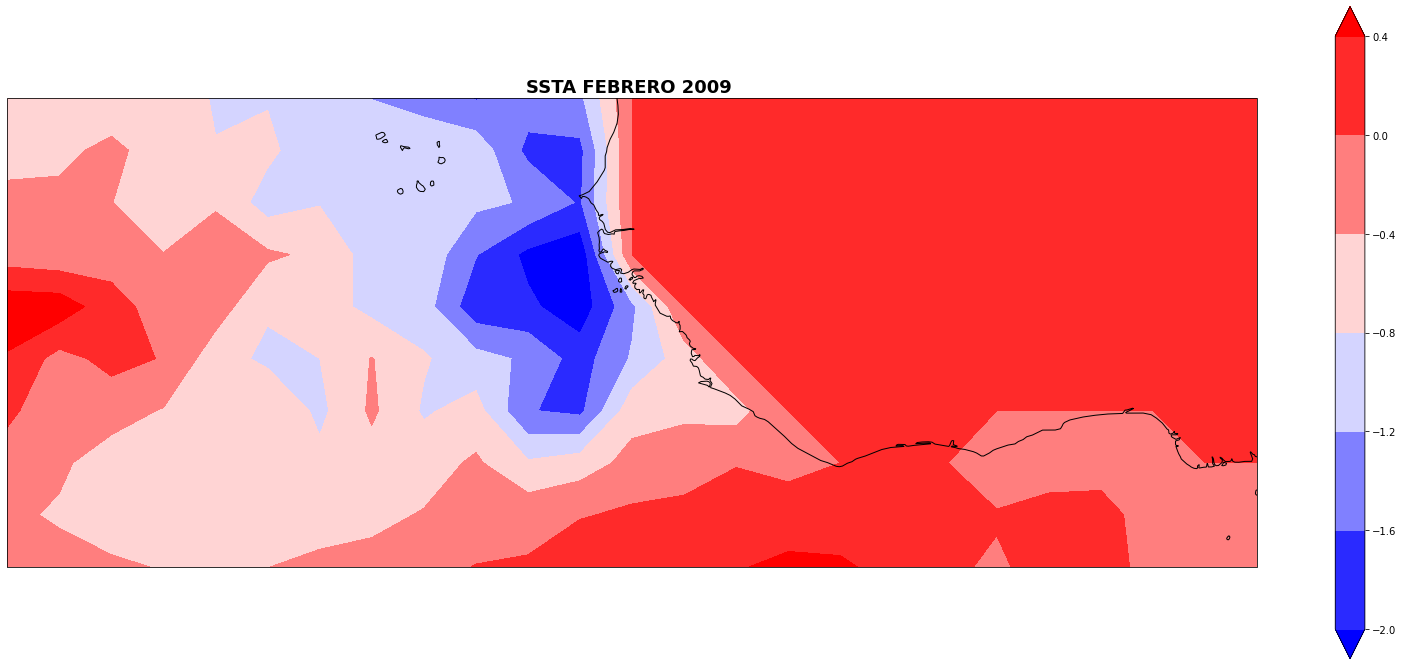

In [791]:
X=CH_f[yrs==2009]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,X.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('CHA FEBRERO ',fontsize=18,weight='bold')

Y=AT_f[yrs==2009]

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('SSTA FEBRERO 2009 ',fontsize=18,weight='bold')

Text(0.5, 1.0, 'SSTA MARZO 2009 ')

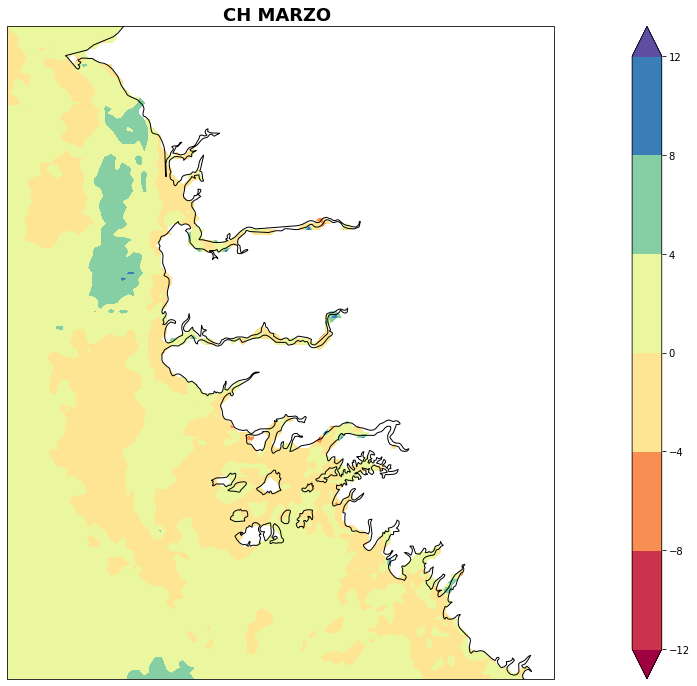

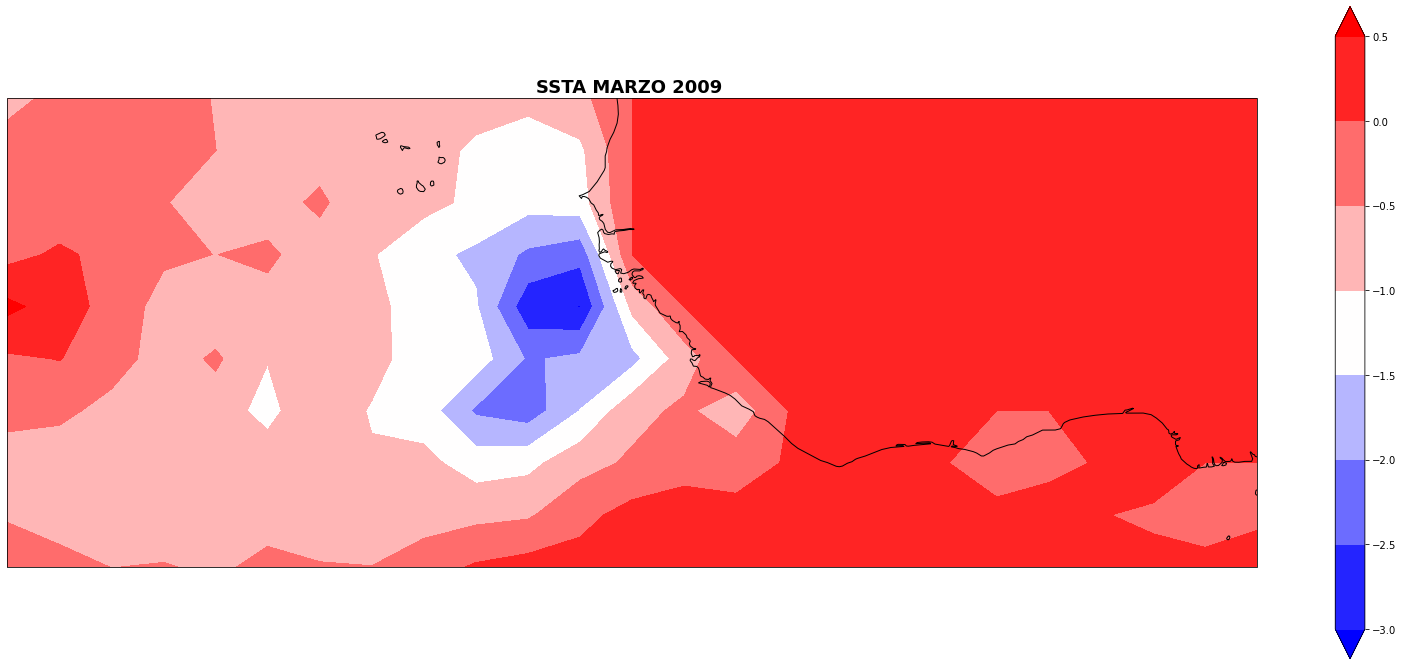

In [792]:
X=CH_m[yrs==2009]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,X.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('CH MARZO ',fontsize=18,weight='bold')

Y=AT_m[yrs==2009]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('SSTA MARZO 2009 ',fontsize=18,weight='bold')

Text(0.5, 1.0, 'SSTA ABRIL 2009 ')

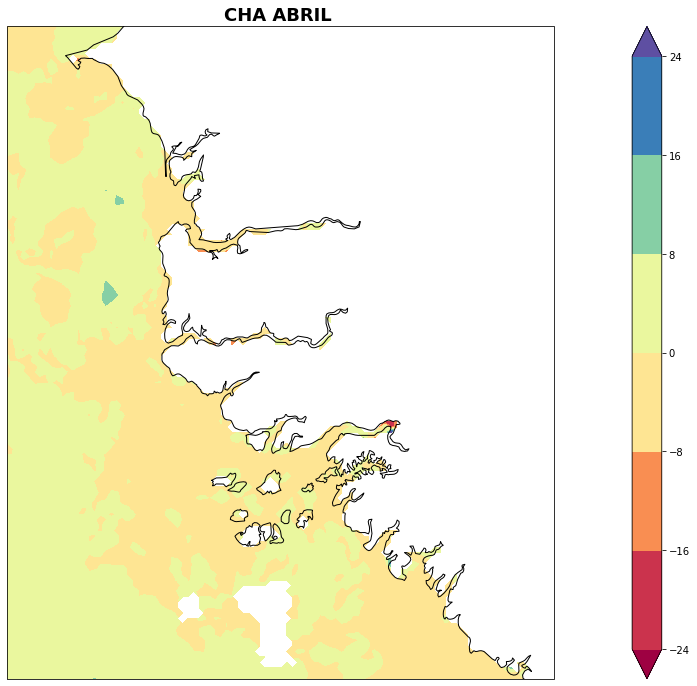

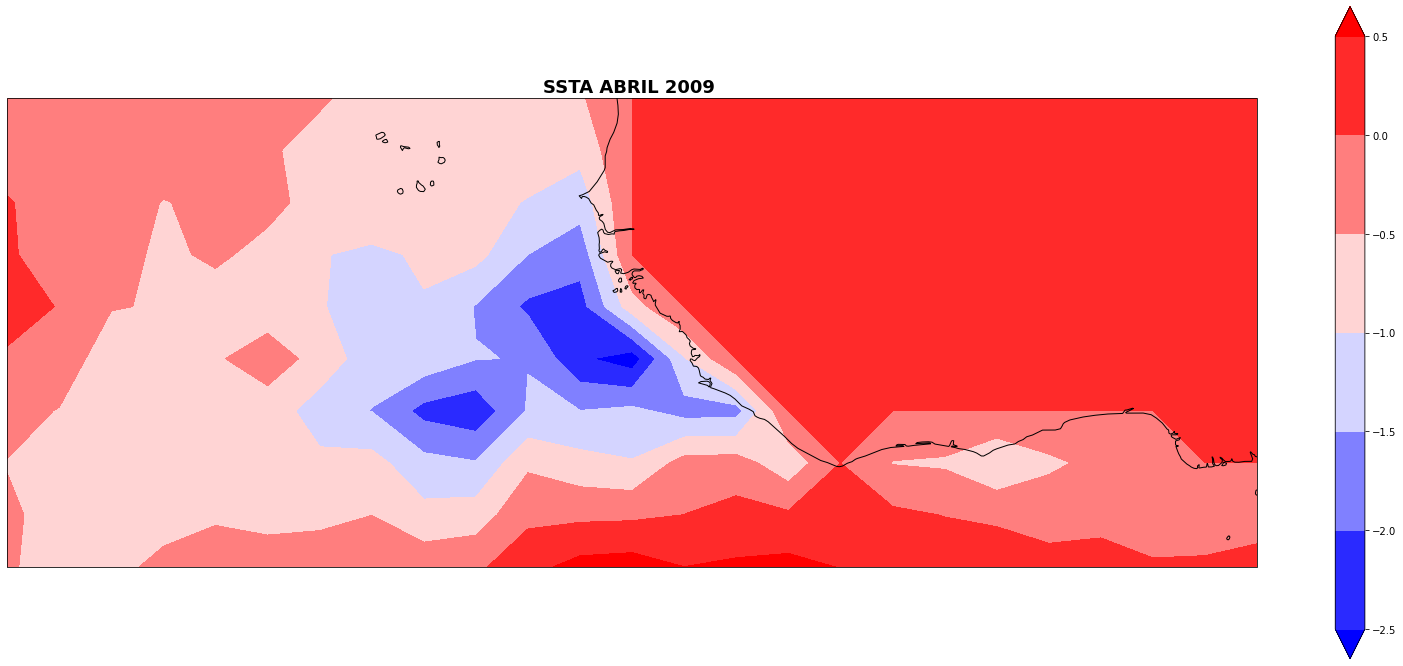

In [793]:
X=CH_a[yrs==2009]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,X.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('CHA ABRIL ',fontsize=18,weight='bold')

Y=AT_a[yrs==2009]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('SSTA ABRIL 2009 ',fontsize=18,weight='bold')


Text(0.5, 1.0, 'SSTA MAYO 2009 ')

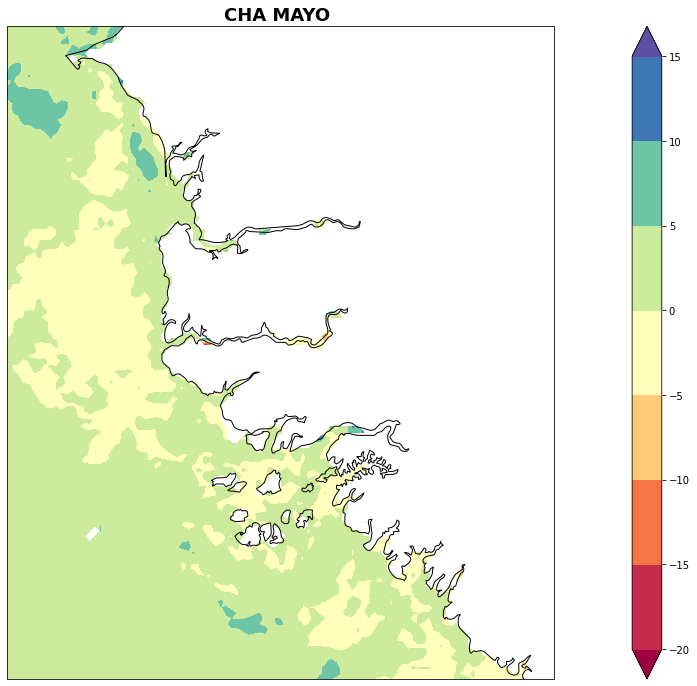

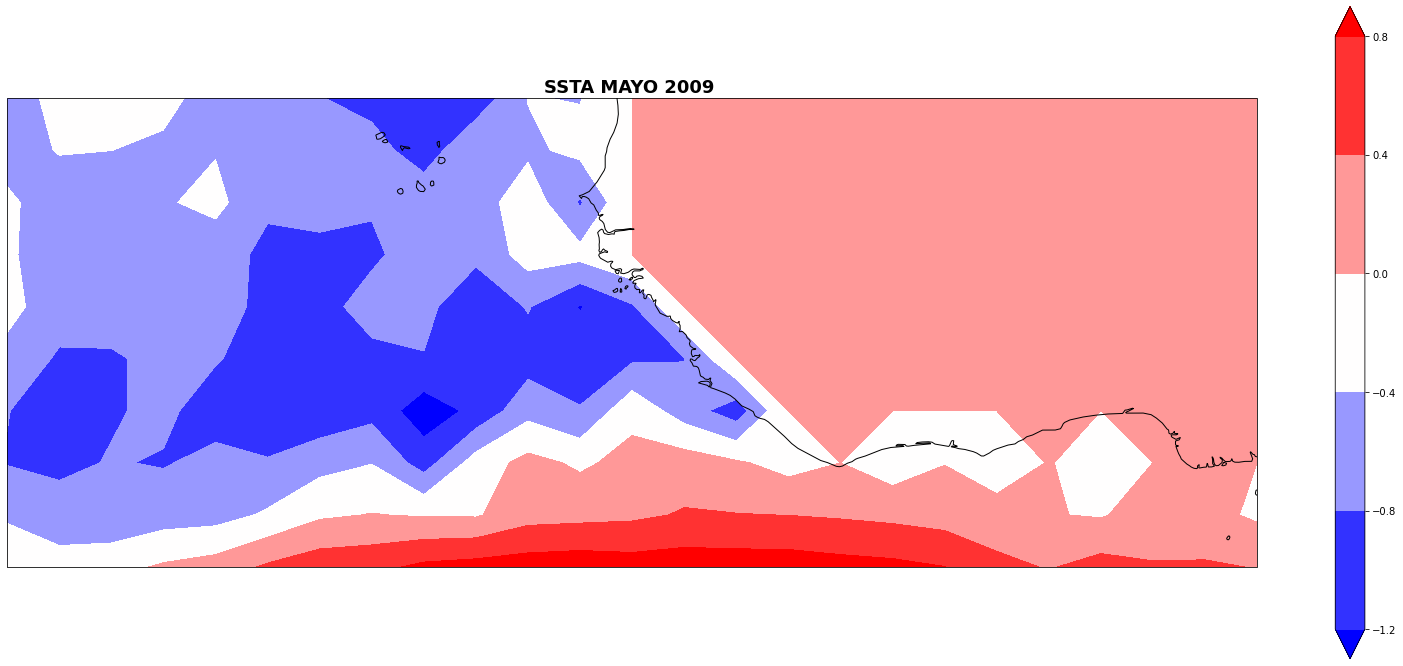

In [794]:
X=CH_y[yrs==2009]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,X.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('CHA MAYO ',fontsize=18,weight='bold')

Y=AT_y[yrs==2009]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('SSTA MAYO 2009 ',fontsize=18,weight='bold')

Text(0.5, 1.0, 'SSTA MARZO 2012 ')

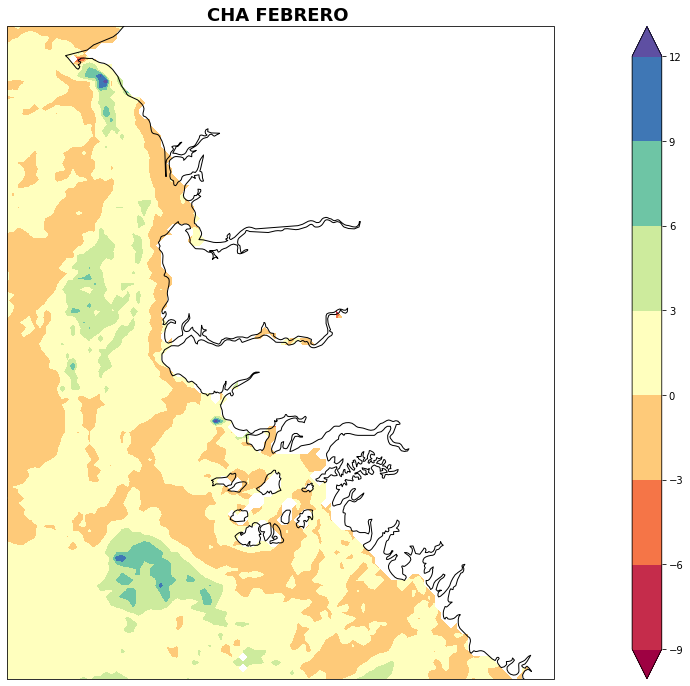

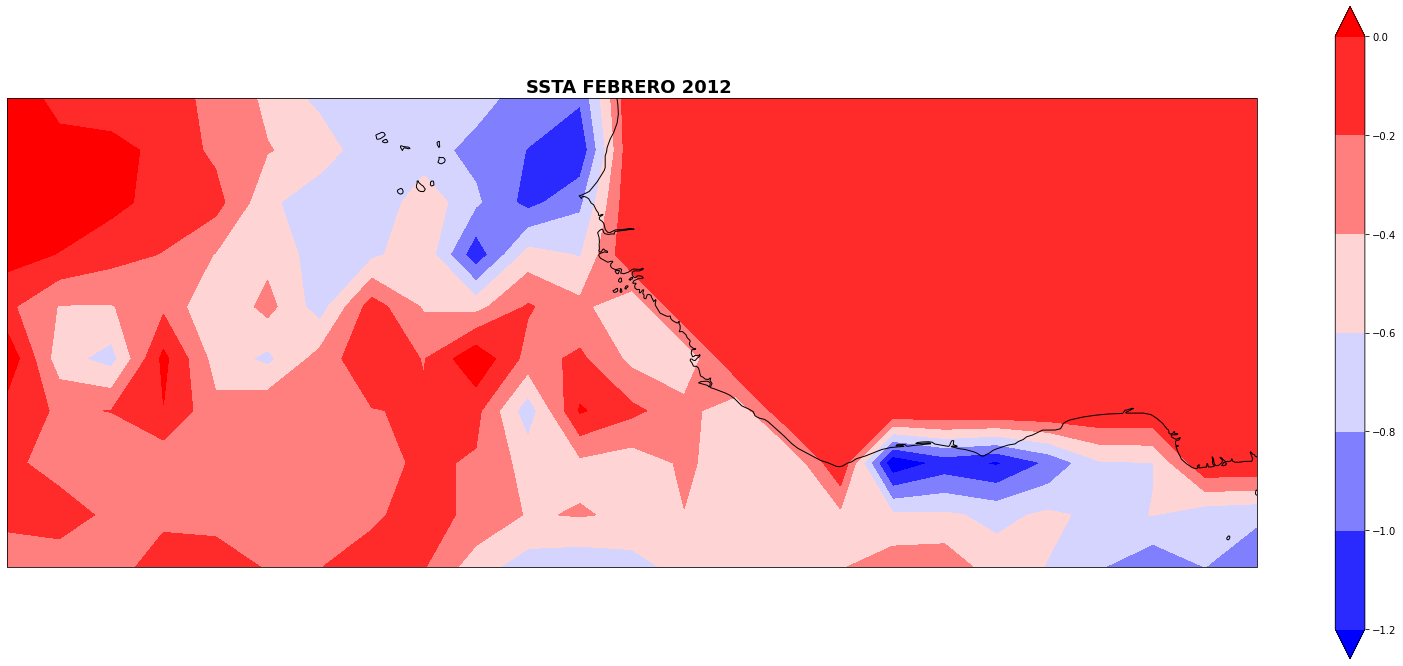

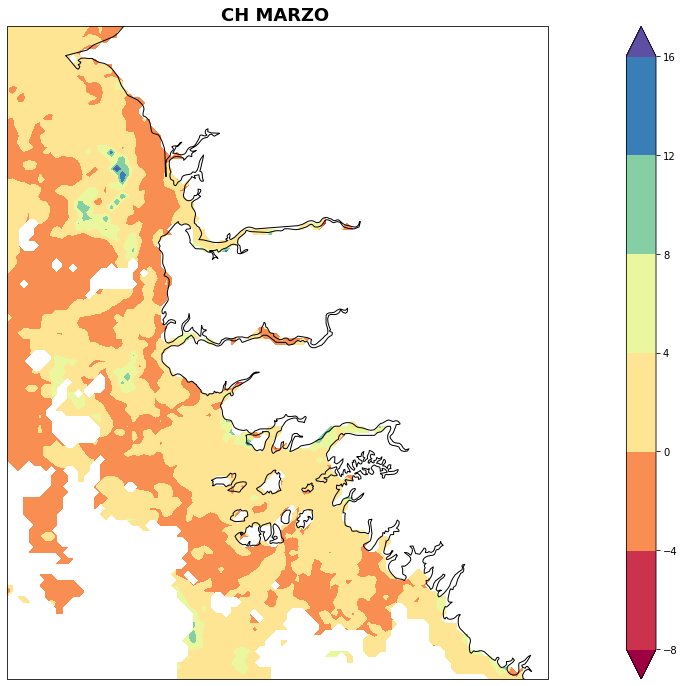

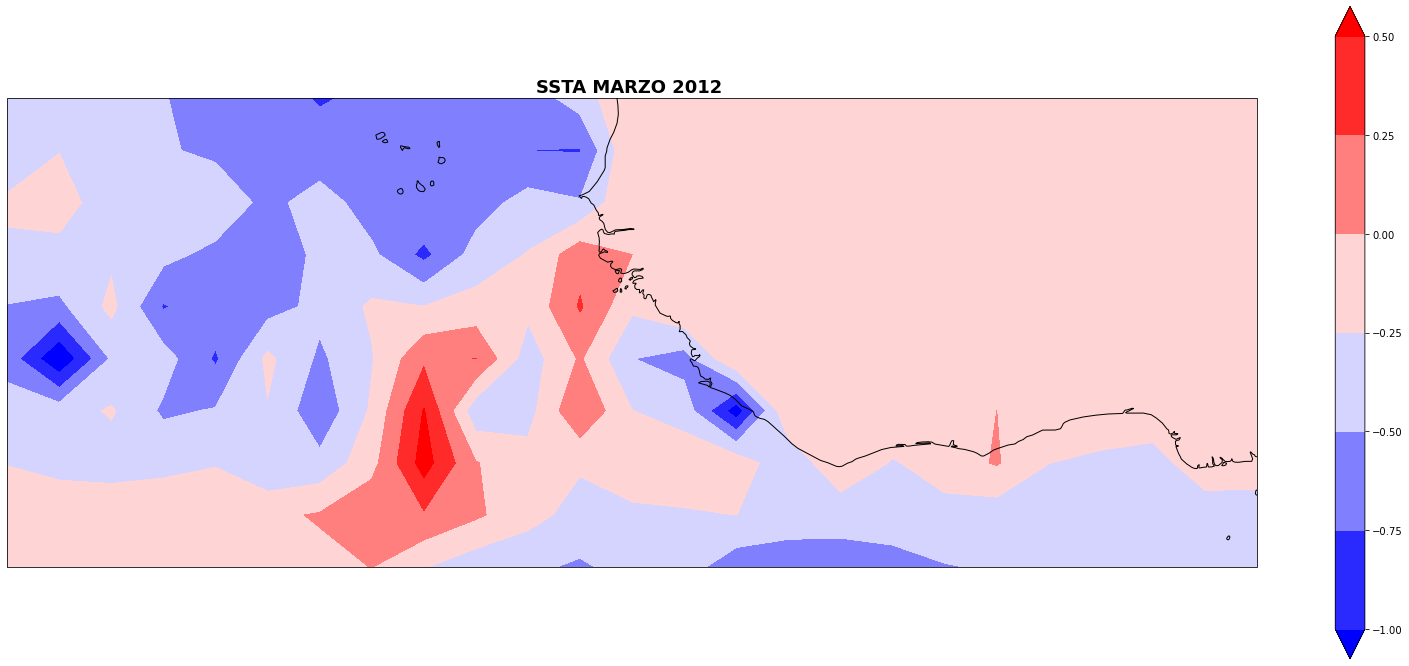

In [77]:
X=CH_f[yrs==2012]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,X.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('CHA FEBRERO ',fontsize=18,weight='bold')

Y=AT_f[yrs==2012]

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('SSTA FEBRERO 2012 ',fontsize=18,weight='bold')

X=CH_m[yrs==2012]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,X.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('CH MARZO ',fontsize=18,weight='bold')

Y=AT_m[yrs==2012]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('SSTA MARZO 2012 ',fontsize=18,weight='bold')

Text(0.5, 1.0, 'SSTA MARZO 2013 ')

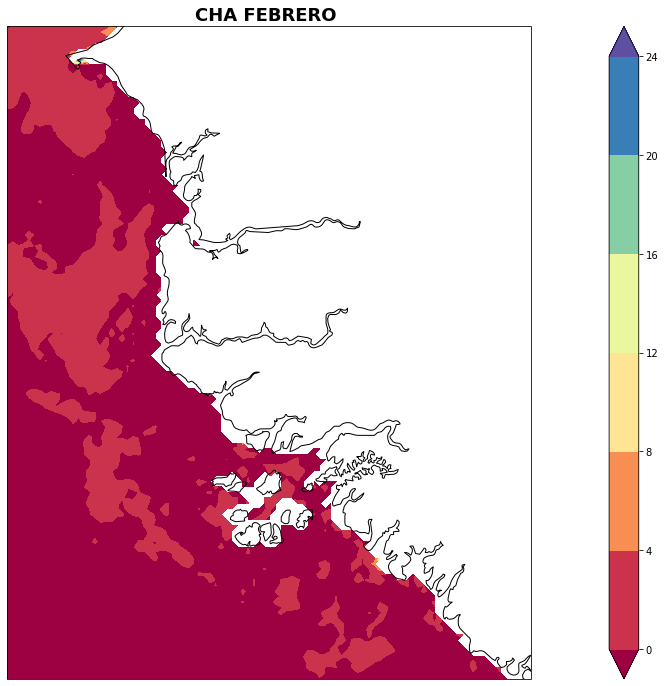

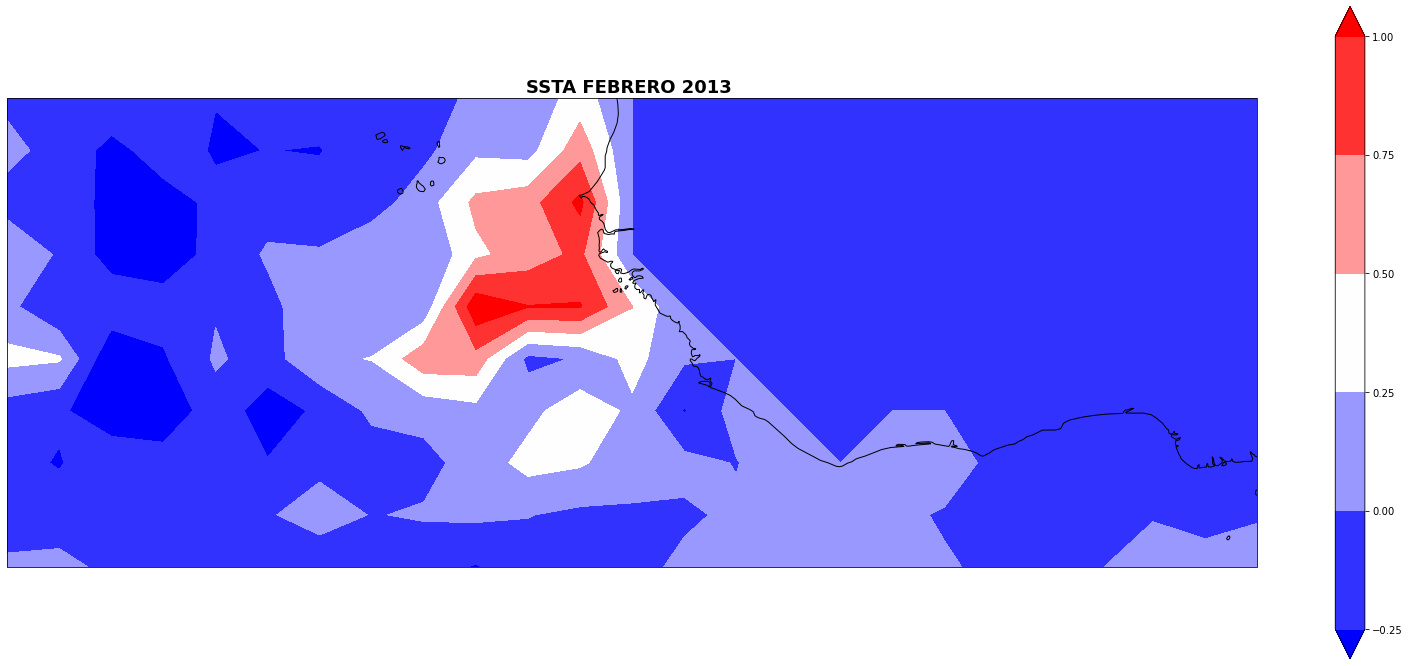

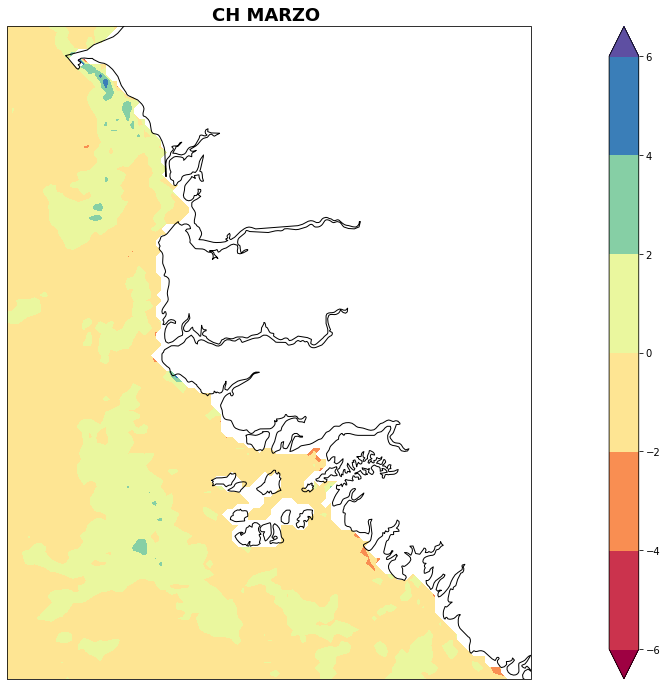

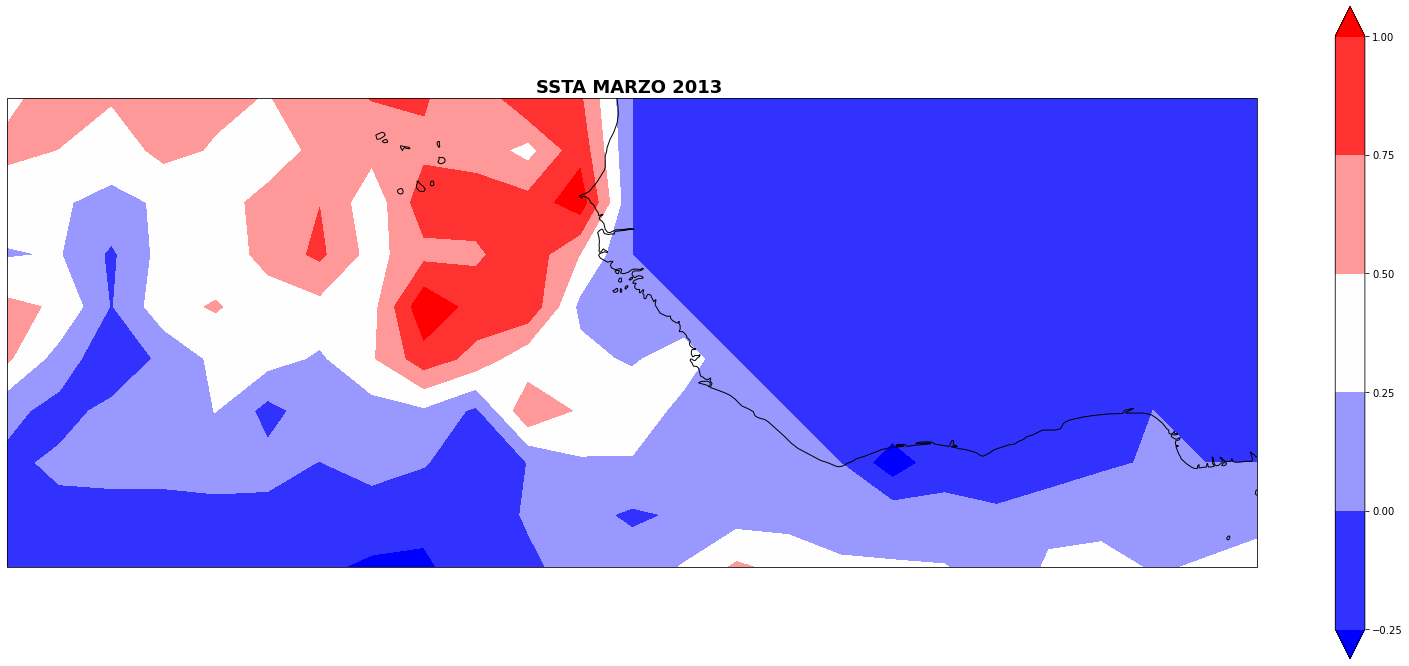

In [78]:
X=CH_f[yrs==2013]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,X.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('CHA FEBRERO ',fontsize=18,weight='bold')

Y=AT_f[yrs==2013]

fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('SSTA FEBRERO 2013 ',fontsize=18,weight='bold')

X=CH_m[yrs==2013]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_CH,lat_CH,X.reshape(len(lat_CH),len(lon_CH)),cmap='Spectral',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('CH MARZO ',fontsize=18,weight='bold')

Y=AT_m[yrs==2013]
fig = plt.figure(figsize=(28,12)) 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
im = ax.contourf(lon_AT,lat_AT,Y.reshape(len(lat_AT),len(lon_AT)),cmap='bwr',extend='both'
               ,transform = ccrs.PlateCarree())
#fíjate que divido por 100 para que quede en hectopascales (hPa)
ax.coastlines()
fig.colorbar(im,ax=ax) #Para la barra de colores
ax.set_title('SSTA MARZO 2013 ',fontsize=18,weight='bold')